<a href="https://colab.research.google.com/github/noamKayzer/Eye-movements-classification/blob/main/ICMS_eye_movement_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data reading 

In [2]:
sac_axis=307

import os 
import copy
import shutil
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly
import pdb
import seaborn as sns
import random
import torch as th
import torch
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import time
from datetime import datetime
from functools import partial
import sys
!pip install optuna
import optuna
from optuna.visualization import plot_optimization_history,plot_intermediate_values,plot_slice

!pip install einops
import einops

import tensorflow as tf
!pip -q install vit_pytorch linformer
import vit_pytorch
from vit_pytorch.efficient import ViT 
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
!pip install linformer-pytorch
import linformer_pytorch
from tqdm.notebook import tqdm
import warnings
import plotly.graph_objects as go
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import pydotplus
from scipy import signal
from sklearn.tree import DecisionTreeClassifier,plot_tree
import matplotlib.image as pltimg
from io import StringIO
from sklearn.inspection import permutation_importance
import plotly.io as pio
%load_ext google.colab.data_table

import plotly
#%unload_ext google.colab.data_table


pio.renderers.default = "colab"

     |████████████████████████████████| 308 kB 13.1 MB/s 
     |████████████████████████████████| 80 kB 7.8 MB/s 
     |████████████████████████████████| 210 kB 30.4 MB/s 
     |████████████████████████████████| 75 kB 3.8 MB/s 
     |████████████████████████████████| 49 kB 5.2 MB/s 
     |████████████████████████████████| 113 kB 39.1 MB/s 
     |████████████████████████████████| 149 kB 44.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=d8f52cd69f39dd02f18d50fa4689ac7f296e531518d3c965abb12dfe6bdb275c
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
     |████████████████████████████████| 50 kB 5.2 MB/s 


In [3]:
class data_read():
  def __init__(self):
    self.cd = '/content/drive/MyDrive/eye_pos_new' 
    #find sess list
    self.sess_files_list=[]
    self.timeline = np.arange(-496,1004,4)
    for file in os.listdir(self.cd):
      if file.endswith("_eye.mat"):
          self.sess_files_list.append(os.path.join(self.cd, file))
    self.sess_list = [sess[(sess.rindex('eye_pos_new/')+12):-8] for sess in self.sess_files_list]
  def get_data(self):
    if not hasattr(self,'x'):
      x,y,sac2RF,sac2RF_sacn = self.open_files()
      self.x_wo_perm = x 
      self.y_wo_perm = y 
      self.sac2RF_wo_perm = sac2RF
      self.sac2RF_sacn_wo_perm = sac2RF_sacn
      self.x = x
      self.y = y
      self.sac2RF = sac2RF
      self.sac2RF_sacn = sac2RF_sacn
      return x,y,sac2RF,sac2RF_sacn
    else:
      return self.x,self.y,self.sac2RF,self.sac2RF_sacn

  def open_files(self):
    x = np.empty((0,375,2))
    y = np.empty((0))
    sac2RF = np.empty((0))
    sac2RF_sacn = np.empty((0))
    for i in range(len(self.sess_files_list)):
      file = self.sess_files_list[i]
      sess = self.sess_list[i]
      x_temp,y_temp,sac2RF_temp,sac2RF_sacn_temp = self.open_mat(file,sess)
      if 'leg' in sess:
        # rotation of monkey legolas trials in x axis (due to diffrent hemisphere stimultion)
        x_temp[:,:,0] = - x_temp[:,:,0]
      x_temp  = x_temp[:,1:,:] #removing first point (-500ms) for getting 375 time points (-496:4:1000)
      x = np.concatenate((x,x_temp),axis=0)
      y = np.concatenate((y,y_temp),axis=0)
      sac2RF = np.concatenate((sac2RF,sac2RF_temp),axis=0)
      sac2RF_sacn = np.concatenate((sac2RF_sacn,sac2RF_sacn_temp),axis=0)
    y = np.array(y,dtype='i')
    self.total_trials = x.shape[0]
    print(f'Total trials:{self.total_trials}, labels:{y.shape[0]}. ICMS trials:{np.sum(y==1)}, blank trials:{np.sum(y==0)}')
    return x,y,sac2RF,sac2RF_sacn
  def check(self,trial):
        max_val = 12 #12
        min_val = -12 #-12
        below_max = not all([True if a<max_val else False for a in list(trial.flatten())])
        over_min = not all([True if a>min_val else False for a in list(trial.flatten())])
        if  below_max or over_min:
          print('Out of boundry, deleting Trial.')
          return False
        elif np.mean(np.diff(trial))==0:
          print('Static trial (w\o any change in eye movements), deleting Trial.')
          return False
        else:
          return True
  def shuffle(self):
      self.perm = np.random.permutation(self.total_trials)
      x = copy.deepcopy(self.x_wo_perm[self.perm,:,:])
      y = copy.deepcopy(self.y_wo_perm[self.perm])
      sac2RF = copy.deepcopy(self.sac2RF_wo_perm[self.perm])
      sac2RF_sacn = copy.deepcopy(self.sac2RF_sacn_wo_perm[self.perm])
      return x,y,sac2RF,sac2RF_sacn

  def open_mat(self,file,sess):
    eye = scipy.io.loadmat(file)
    xdata = eye['eyex'][0]
    ydata = eye['eyey'][0]
    cond = eye['binCond'][0]
    sac2RF = eye['sac2RF'][0]
    sac2RF_sacn = eye['sac2RF_sacn'][0]
    arr = np.empty((xdata.shape[0],2, xdata[0].shape[0]))
    cond_arr = np.array(np.empty(cond.shape[0]))
    sac2RF_arr = np.array(np.empty(sac2RF.shape[0]))
    sac2RF_sacn_arr = np.array(np.empty(sac2RF_sacn.shape[0]))
    k=-1
    for i in range(xdata.shape[0]):
      k+=1
      arr[k][0][:] = np.concatenate(xdata[i])
      arr[k][1][:] = np.concatenate(ydata[i])
      arr[k][0][:] -= np.mean(arr[k][0][86:123])
      arr[k][1][:] -= np.mean(arr[k][1][86:123])
      cond_arr[k] = int(cond[i]) 
      sac2RF_arr[k] = int(sac2RF[i]) 
      sac2RF_sacn_arr[k] = sac2RF_sacn[i] if sac2RF_sacn[i].size>0 else 0
      #sac2RF_sacn_arr[k] -=1
      #cancaled - no sac2rf encode as saccade on -1 place
      if not self.check(arr[k,:,:]):
        k-=1
    if i>k:
      arr = arr[:k-i]
      cond_arr = cond_arr[:k-i]
      sac2RF_arr = sac2RF_arr[:k-i]
      sac2RF_sacn_arr = sac2RF_sacn_arr[:k-i]
    arr = np.swapaxes(arr,1,2)
    print(f'{sess}:{arr.shape}')
    return arr,cond_arr,sac2RF_arr,sac2RF_sacn_arr
  def scale_num_of_trials(self,with_sac2rf):
      # when only sac2rf trials or ICMS trials w/o sac2RF are requested, this function can balance the number of trials from each label
      x,y,sac2RF,sac2RF_sacn = self.shuffle()
      icms_trials = np.logical_and(y==1,sac2RF==with_sac2rf)
      restrict_blank_trials = (y==0)
      max_trial = np.where(restrict_blank_trials)[0][np.sum(icms_trials)] #the nuber of trial which we can take for equel numer of trials in the sac2rf trials and the blank
      restrict_blank_trials[max_trial:]=False #restirct to same number of trials as in sac2rf trials
      #restrict_blank_trials = np.random.choice(restrict_blank_trials, np.sum(icms_trials), replace=False)
      x = x[np.logical_or(icms_trials,restrict_blank_trials)]
      y= y[np.logical_or(icms_trials,restrict_blank_trials)]
      sac2RF = sac2RF[np.logical_or(icms_trials,restrict_blank_trials)]
      sac2RF_sacn = sac2RF_sacn[np.logical_or(icms_trials,restrict_blank_trials)]
      print(f'{sum(icms_trials)} icms trials were taken.\n{sum(restrict_blank_trials)} blank trials were taken.')
      perm = np.random.permutation(x.shape[0])
      x = x[perm,:,:]
      y = y[perm]
      sac2RF = sac2RF[perm]
      sac2RF_sacn = sac2RF_sacn[perm]
      return x,y,sac2RF,sac2RF_sacn

In [4]:
data_class = data_read()
x,y,sac2RF,sac2RF_sacn = data_class.get_data()
timeline=data_class.timeline
mean_x_axis = x[:,:,0].mean()
mean_y_axis = x[:,:,1].mean()
std_x_axis = x[:,:,0].std()
std_y_axis = x[:,:,1].std()
print(f'mean x axis:{mean_x_axis} (+-SD:{std_x_axis}) mean y axis:{mean_y_axis} (+-SD:{std_y_axis})')

Arg_2705B:(37, 376, 2)
Arg_2805A:(50, 376, 2)
Arg_2805B:(43, 376, 2)
Arg_2805C:(101, 376, 2)
Arg_2306A:(118, 376, 2)
Arg_2406B:(125, 376, 2)
Arg_2406D:(37, 376, 2)
Arg_0709A:(77, 376, 2)
Arg_0709B:(69, 376, 2)
Arg_0709C:(84, 376, 2)
leg_1803F:(78, 376, 2)
leg_1803G:(69, 376, 2)
leg_1803H:(36, 376, 2)
arg_0307A:(98, 376, 2)
Arg_2707A:(59, 376, 2)
Arg_2707B:(31, 376, 2)
Arg_2707C:(46, 376, 2)
arg_0307B:(72, 376, 2)
arg_2606B:(77, 376, 2)
Arg_2907NEW_A:(31, 376, 2)
arg_2606C:(83, 376, 2)
Total trials:1421, labels:1421. ICMS trials:703, blank trials:718
mean x axis:0.03655771362065639 (+-SD:0.7451057468682486) mean y axis:-0.00028761895847506105 (+-SD:0.5136429437740297)


In [5]:
#Engbert Algo
def vecvel(x,Fs):    
  vel = np.empty((x.shape[0],2))
  vel[:] = np.nan
  for i in range(2):
    trial = x[:,i]
    vel[3-1:-2,i] = (trial[5-1:]+trial[4-1:-1]-trial[2-1:-3]-trial[1-1:-4])*(Fs/6)
    vel[1,i] = (trial[2]-trial[0])*(Fs/2)
    vel[-2,i] = (trial[-1]-trial[-3])*(Fs/2)
  return vel

def microsacc(x,vel,std_thrs,mindur):
  VFAC = std_thrs
  #compute threshold: msd-minimum significant difference
  msdx = np.sqrt( np.nanmedian(vel[:,0]**2) - (np.nanmedian(vel[:,0]))**2 )
  msdy = np.sqrt( np.nanmedian(vel[:,1]**2) - (np.nanmedian(vel[:,1]))**2 )
  radiusx = VFAC*msdx
  radiusy = VFAC*msdy
  test = (vel[:,0]/radiusx)**2 + (vel[:,1]/radiusy)**2
  indx, = np.where(test>1)
  N = len(indx)
  sac = pd.DataFrame()
  nsac = 0
  dur = 1
  aa = 0
  k = 0
  onset,offset,dx,dy,dX,dY = [],[],[],[],[],[]
  while k<N-1:
    if indx[k+1]-indx[k]==1:
        dur = dur + 1
    else:
        if dur>=mindur:
            nsac = nsac + 1
            bb = k
            onset.append(indx[aa])
            offset.append(indx[bb])
        aa = k+1
        dur = 1
    k = k + 1
  if dur>=mindur:
    nsac = nsac + 1
    bb = k
    onset.append(indx[aa])
    offset.append(indx[bb])
  sac['onset'] = onset
  sac['offset'] = offset
  #sac['nsac']=nsac
  vpeak_list=[]
  
  for s in range(nsac):
    # onset and offset
    aa = onset[s] 
    bb = offset[s]
    # saccade peak velocity (vpeak)
    vpeak = np.nanmax( np.sqrt( vel[aa:bb,0]**2 + vel[aa:bb,1]**2 ))
    vpeak_list.append( vpeak)
    # saccade vector (dx,dy)
    dx.append(x[bb,0]-x[aa,0])
    dy.append(x[bb,1]-x[aa,1])
    # saccade amplitude (dX,dY)
    i = np.arange(aa,bb)
    minx = np.min(x[i,0])
    ix1 = np.argmin(x[i,0])
    maxx = np.max(x[i,0])
    ix2 = np.argmax(x[i,0])
    miny, iy1 = np.min(x[i,1]),np.argmin(x[i,1])
    maxy, iy2 = np.max(x[i,1]),np.argmax(x[i,1])
    dX.append(np.sign(ix2-ix1)*(maxx-minx))
    dY.append(np.sign(iy2-iy1)*(maxy-miny))
  sac['peak_velocity'] = vpeak_list
  sac['dx'] = dx
  sac['dy'] = dy
  sac['max_amp x'] = dX
  sac['max_amp y'] =dY
  # dx and dy are the diffrence in each axes before and after the MS
  # max_amplitude is the maximal diffrence in the MS times. 
  #sac_df = pd.DataFrame(sac,columns=['onset','offset','peak_velocity','dx','dy','max_amp x','max_amp y'])
  sac['max_amp'] = np.sqrt(np.power(dX,2)+np.power(dY,2))
  rad = np.arctan2(dY, dX) # In radians
  sac['deg'] =  rad * (180 / np.pi)
  sac['correction x'] = np.subtract(dX,dx) 
  sac['correction y'] = np.subtract(dX,dy)
  deg_diff_between_sac_axis_and_ms = sac_axis-sac['deg']
  sac['sac_axis_proj'] = sac['max_amp']*np.cos(deg_diff_between_sac_axis_and_ms/180*np.pi)
  deg_diff_between_orth_axis_and_ms = (sac_axis-90)-sac['deg']
  sac['orth_axis_proj'] = sac['max_amp']*np.cos(deg_diff_between_orth_axis_and_ms/180*np.pi)
  return sac

In [6]:
std_thrs = 5.5 
mindur = 4
Fs=250
sac_axis = 307
class find_first_ms_class():
  def __init__(self,x,y,sac2RF,sac2RF_sacn,select_max_proj_sac=False,return_type='df'):
    self.total_trials = x.shape[0]
    self.ms=[0]*self.total_trials
    self.x=copy.deepcopy(x)
    self.y=copy.deepcopy(y)
    self.sac2RF=copy.deepcopy(sac2RF)
    self.sac2RF_sacn=copy.deepcopy(sac2RF_sacn)
    self.return_type=return_type
    self.select_max_proj_sac=select_max_proj_sac
    for trial in range(self.total_trials):
      cur_trial = copy.deepcopy(x[trial,:,:])
      vel = vecvel(cur_trial,Fs)
      self.ms[trial]= microsacc(cur_trial,vel,std_thrs,mindur)

  def find_first_ms(self,time_before_and_after_ms=24,
                    ms_min_time_after_onset=48,ms_max_time_after_onset=500,min_amp=0.2):
    first_ms_np = np.zeros_like(x)
    first_ms_np[:]=np.nan
    sap_bef_aft=int(time_before_and_after_ms/4)
    self.ms_min_time_after_onset=ms_min_time_after_onset
    self.ms_max_time_after_onset=ms_max_time_after_onset
    self.min_amp_for_polar=str(min_amp)
    amp_first_ms = np.full(self.total_trials,np.nan)
    deg_first_ms = np.full(self.total_trials,np.nan)
    peakv_first_ms = np.full(self.total_trials,np.nan)
    corx_first_ms = np.full(self.total_trials,np.nan)
    cory_first_ms = np.full(self.total_trials,np.nan)
    latency = np.full(self.total_trials,np.nan)
    sac_axis_proj_first_ms = np.full(self.total_trials,np.nan)
    orth_axis_proj_first_ms = np.full(self.total_trials,np.nan)
    for trial in range(self.total_trials):
      max_sac_axis_proj_for_trial=0
      ms_df = self.ms[trial]
      cur_trial = self.x[trial,:,:]
      sac_vec_idx=np.array([])
      sample2time = lambda t: t*4-500
      nsac = len(ms_df)

      for i in range(nsac):
        onset = ms_df['onset'].loc[i]
        offset = ms_df['offset'].loc[i]
        amp = ms_df['max_amp'].loc[i]
        deg = ms_df['deg'].loc[i]
        peakv = ms_df['peak_velocity'].loc[i]
        correction_x = ms_df['correction x'].loc[i]
        correction_y = ms_df['correction y'].loc[i]
        sac_axis_proj = ms_df['sac_axis_proj'].loc[i]
        orth_axis_proj = ms_df['orth_axis_proj'].loc[i]
        '''
        if sac2RF_sacn[trial]>0 :
          #if  int(sac2RF_sacn[trial])== i+1:
          if  int(sac2RF_sacn[trial])== i+1:
            this_sac =True

        el
        '''
        if ms_max_time_after_onset>sample2time(onset)>ms_min_time_after_onset and amp>min_amp:
          if (not self.select_max_proj_sac) or (sac_axis_proj>max_sac_axis_proj_for_trial):
            cur_trial_sac = cur_trial[(onset-sap_bef_aft):(offset+sap_bef_aft),:]
            first_ms_np[trial,:cur_trial_sac.shape[0],:] = cur_trial_sac
            amp_first_ms[trial] = amp
            deg_first_ms[trial] = deg
            peakv_first_ms[trial] = peakv
            corx_first_ms[trial] =correction_x
            cory_first_ms[trial] = correction_y
            sac_axis_proj_first_ms[trial] = sac_axis_proj
            orth_axis_proj_first_ms[trial] = orth_axis_proj
            latency[trial] = sample2time(onset)
            assert latency[trial]>0, 'Latency value sholdn\'t be negative'
            max_sax_axis_proj_for_trial = sac_axis_proj
            if (not self.select_max_proj_sac):
              break
    first_ms_df = pd.DataFrame(data=np.stack((amp_first_ms,deg_first_ms,peakv_first_ms,corx_first_ms,
                                              cory_first_ms,sac_axis_proj_first_ms,orth_axis_proj_first_ms,latency,self.y,self.sac2RF)).T
                           ,columns=['max_amp','deg','peak_velocity','correction_x','correction_y','sac_axis_proj','orth_axis_proj','latency','icms','sac2RF'])
    if self.return_type =='np':
      return first_ms_np
    else:
      return first_ms_df
def plot_spec_for_plot_trial(s_arr,title,ax,f,t):
      ax.pcolormesh(t, f[:s_arr.shape[0]], s_arr, shading='gouraud')
      ax.set_title(title)
      ax.set_ylabel('Frequency [Hz]')
      ax.set_xlabel('Time [sec]')

## Characteristics of MS evoked by ICMS

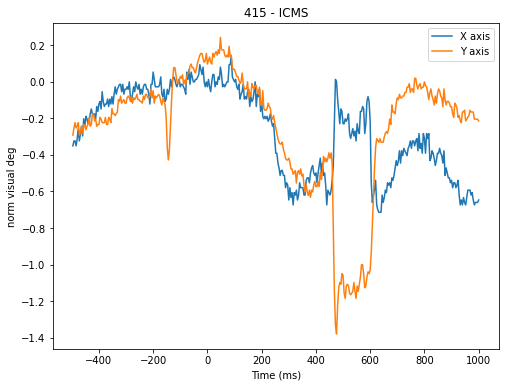

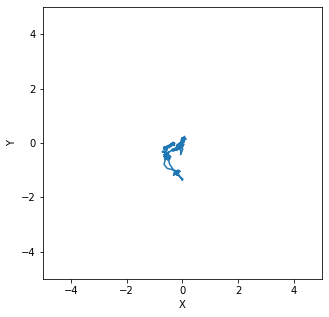

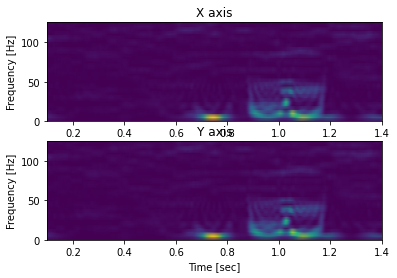

In [7]:
trial_num = 415 #@param {type:"slider", min:0, max:1500, step:1}
if trial_num >= x.shape[0]:
  print(f'Trial_num exceed maximum trials.\n Showing last trial:{x.shape[0]}')
  trial_num = x.shape[0]-1
def plot_trial(x,cond=None,trial_num='',x_std=False,time_vec=timeline):
  x=copy.deepcopy(x)
  
  assert not all(list((x==0).flatten()))
  lim=5

  if isinstance(x,th.Tensor):
    x_size = x.size()
    x_size = x_size[0]
    if x_size==2:
      x=th.transpose(x,1,0)
  elif isinstance(x,np.ndarray):
    x_size = x.shape[0]
    if x_size==2:
      x=x.transpose(1,0)
  plt.figure(figsize=(8,6))
  if not np.any(x_std):
    plt.plot(time_vec,x[:,0],label='X axis')
    plt.plot(time_vec,x[:,1],label='Y axis')  
    fig = plotly.graph_objs.Figure()
    fig = fig.add_trace(plotly.graph_objs.Scatter(x=time_vec,y=x[:,0],name='x'))
    fig = fig.add_trace(plotly.graph_objs.Scatter(x=time_vec,y=x[:,1],name='y'))
  else:
    plt.errorbar(time_vec,x[:,0],yerr=x_std[:,0],alpha=0.2)
    plt.plot(time_vec,x[:,0],'b',label='X axis')
    plt.errorbar(time_vec,x[:,1],yerr=x_std[:,1],alpha=0.2)
    plt.plot(time_vec,x[:,1],'r',label='Y axis')
    
    fig = plotly.graph_objs.Figure()
    err = lambda a,b: plotly.graph_objs.scatter.ErrorY(array=a,color=b)
    fig = fig.add_trace(plotly.graph_objs.Scatter(x=time_vec,y=x[:,0],name='x'))
    fig = fig.add_trace(plotly.graph_objs.Scatter(x=time_vec,y=x[:,1],name='y'))
    fig = fig.add_trace(plotly.graph_objs.Scatter(x=time_vec,y=x[:,0],name='std(x)',error_y=err(x_std[:,0],'blue'), opacity=0.1))
    fig = fig.add_trace(plotly.graph_objs.Scatter(x=time_vec,y=x[:,1],name='std(y)',error_y=err(x_std[:,1],'red'), opacity=0.1))
  if cond==1:
    cond_title = ' - ICMS'
  elif cond == 0 :
    cond_title = ' - No Stim.'
  else:
    cond_title=''
  fig.update_yaxes(title_text='deg')
  fig.update_xaxes(title_text='Time(ms)'+cond_title)
  if x_std is False:
    std_thrs = 5.5 
    mindur = 3
    Fs=250
    vel = vecvel(x,Fs)
    ms_df = microsacc(x,vel,std_thrs,mindur)
    sac_vec_idx=np.array([])
    sample2time = lambda t: t*4-500
    nsac = len(ms_df)
    for i in range(nsac):
      #pdb.set_trace()
      onset = sample2time(ms_df['onset'].loc[i])
      offset = sample2time(ms_df['offset'].loc[i]+1)
      sac_vec_idx = np.append(sac_vec_idx ,np.arange(onset,offset))
      if trial_num and sac2RF_sacn[trial_num]>0 and int(sac2RF_sacn[trial_num])== i+1:
        sac_n_idx = np.arange(onset,offset)
    y_of_sac = np.zeros_like(sac_vec_idx)
    fig = fig.add_trace(plotly.graph_objs.Scatter(
        x=sac_vec_idx,y=y_of_sac,
        name='MS times. N:'+str(nsac),mode='markers'))
    if 'sac_n_idx' in locals():
      fig = fig.add_trace(plotly.graph_objs.Scatter(
        x=sac_n_idx,y=np.zeros_like(sac_n_idx),
        name='sac2RF sac ('+str(sac2RF_sacn[trial_num])+') times',mode='markers'))
    fig.show()
    plt.title(str(trial_num) + cond_title)
    '''
    plt.ylabel('X')
    plt.subplot(212)
    plt.plot(timeline,x[:,1])
    plt.ylabel('Y')
    '''
    plt.xlabel('Time (ms)')
    plt.ylabel('norm visual deg')
    plt.legend()
    plt.figure(figsize=(5,5))
    plt.plot(x[:,0],x[:,1])
    plt.ylim([-lim,lim])
    plt.xlim([-lim,lim])
    plt.ylabel('Y')
    plt.xlabel('X')
    plt.show()

    #create one saccade for plotting, with x[645,:,:]
    '''
    plt.legend()
    plt.figure(figsize=(5,5))
    plt.plot(x[179:187,0],x[179:187,1])
    plt.ylim([-2.5,2.5])
    plt.xlim([-2.5,2.5])
    plt.ylabel('Y')
    plt.xlabel('X')
    plt.show()
    '''
    nperseg = 50
    noverlap = nperseg - 1
    f,t,S = scipy.signal.spectrogram(x[:,0],fs=250,nperseg=nperseg,noverlap=noverlap)
    f_grid =  np.tile(f,(len(t),1)).T
    fig,(ax1,ax2)=plt.subplots(2,1)
    plot_spec_for_plot_trial(S*f_grid,'X axis',ax1,f,t)
    f,t,S = scipy.signal.spectrogram(x[:,0],fs=250,nperseg=nperseg,noverlap=noverlap)
    plot_spec_for_plot_trial(S*f_grid,'Y axis',ax2,f,t)
    plt.show()
  if 'models_list_all' in globals() or 'models_list_all' in locals():
    for i,cur_model in enumerate(models_name):
      correct,_ = cal_acc(models_list_all[i],th.tensor(x.swapaxes(0,1)).unsqueeze(dim=0).to(device),th.tensor([cond]).to(device))
      if correct==1:
        print('{cur_model} prediction is correct!')
      elif correct==0:
        print('{cur_model} Net prediction is wrong...')
      cur_net = models_list_all[i]
    '''
      if 'Hybrid' in cur_model or 'ransformer' in cur_model:
         for module in cur_net.modules():
            ai = th.tensor(x.swapaxes(0,1),dtype=th.float).unsqueeze(dim=0).to(device)#th.unsqueeze(th.tensor(np.swapaxes(x,0,1),dtype=th.double).to(device),0)
            if isinstance(module, nn.Sequential):
              ai=module(ai)
              if module == 'transformer.seq.0.fn.heads.0.E.weight':
                break
         
          for i in cur_net.named_parameters():
            x=i[1](x)
            i[0]='transformer.seq.0.fn.heads.0.E.weight'
          print(x)
         px.line(a)
         '''
  if 'net' in globals() or 'net' in locals():
      correct,_ = cal_acc(net,th.tensor(x.swapaxes(0,1)).unsqueeze(dim=0).to(device),th.tensor([cond]))
      if correct==1:
        print('Net prediction is correct!')
      elif correct==0:
        print('Net prediction is wrong...')
  if trial_num and trial_num is not '':
    if 'train_sampler' in globals() or 'train_sampler' in locals():
      catg='None'
      if trial_num in train_sampler.indices:
        catg = 'Train'
      elif trial_num in val_sampler.indices:
        catg='CV'
      elif trial_num in test_sampler.indices:
        catg='Test'
      print(f'Trial {trial_num} is from the {catg} group.')
  
plot_trial(x[trial_num,:,:],y[trial_num],trial_num)

find saccs larges than False:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning:

Mean of empty slice



icms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: RuntimeWarning:

Mean of empty slice



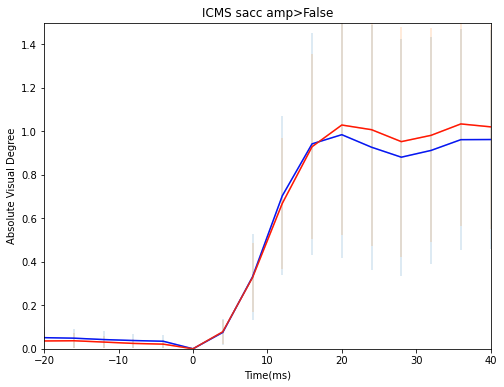

w/o icms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: RuntimeWarning:

Mean of empty slice



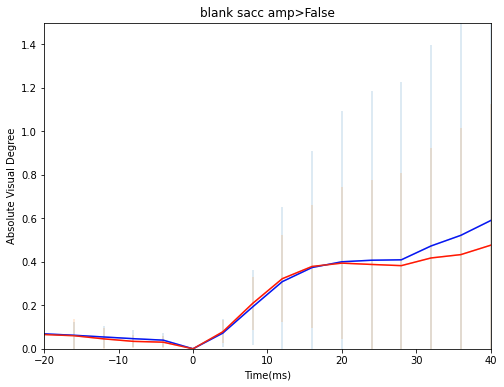

find saccs larges than 0:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning:

Mean of empty slice



icms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: RuntimeWarning:

Mean of empty slice



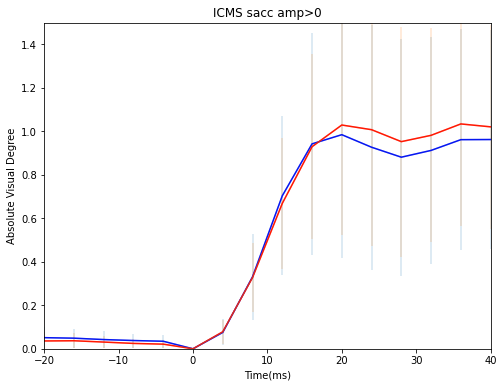

w/o icms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: RuntimeWarning:

Mean of empty slice



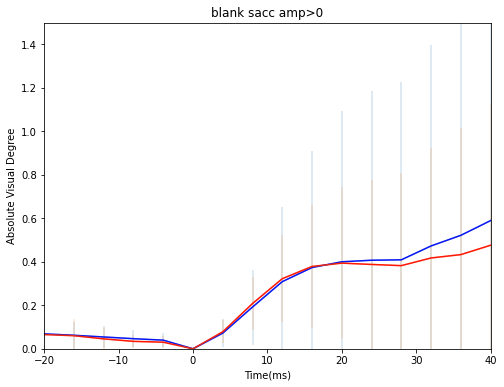

find saccs larges than 0.4:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning:

Mean of empty slice



icms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: RuntimeWarning:

Mean of empty slice



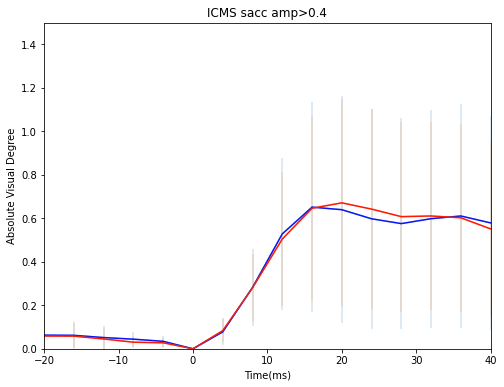

w/o icms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: RuntimeWarning:

Mean of empty slice



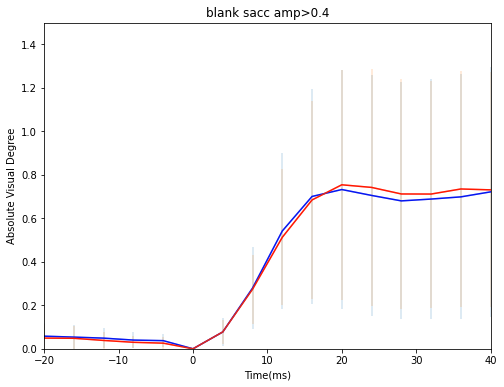

find saccs larges than 0.5:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: RuntimeWarning:

Mean of empty slice



icms


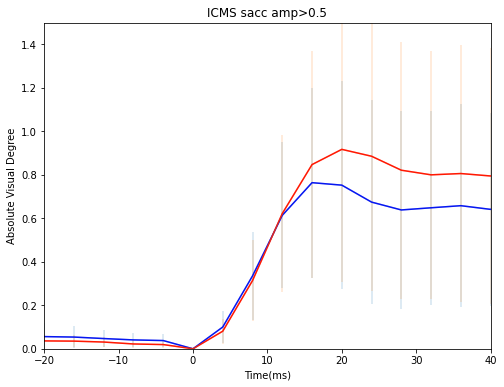

w/o icms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: RuntimeWarning:

Mean of empty slice



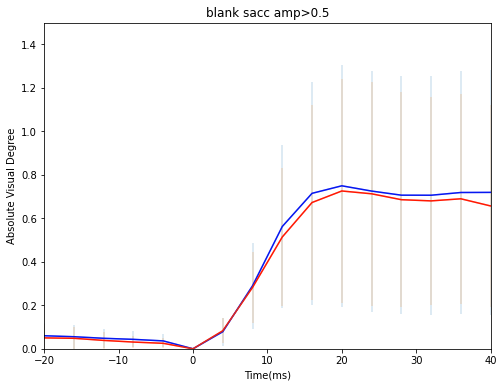

find saccs larges than 0.8:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: RuntimeWarning:

Mean of empty slice



icms


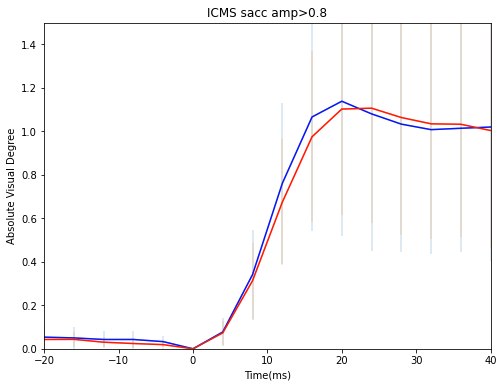

w/o icms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: RuntimeWarning:

Mean of empty slice



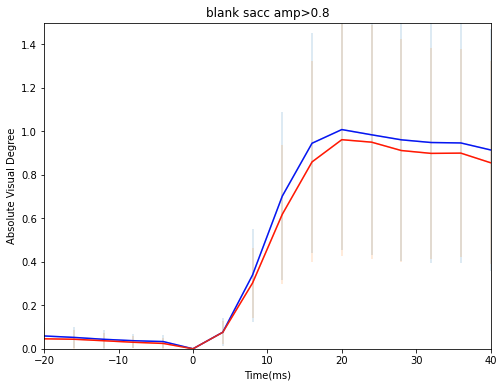

find saccs larges than 1:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: RuntimeWarning:

Mean of empty slice



icms


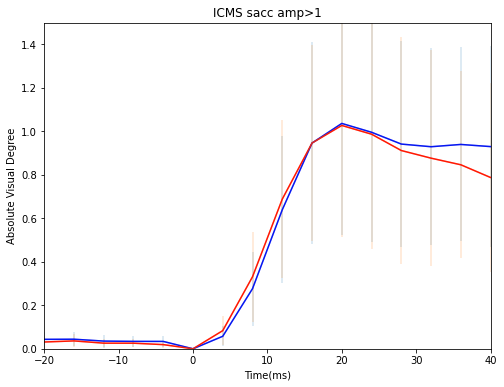

w/o icms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: RuntimeWarning:

Mean of empty slice



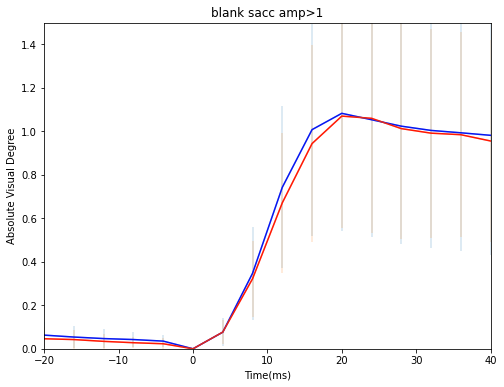

find saccs larges than 0.8:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: RuntimeWarning:

Mean of empty slice

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: RuntimeWarning:

Mean of empty slice



icms


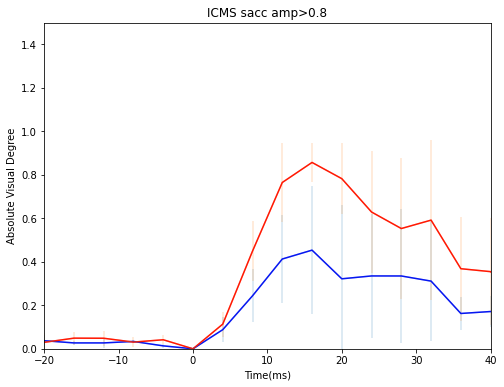

w/o icms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: RuntimeWarning:

Mean of empty slice



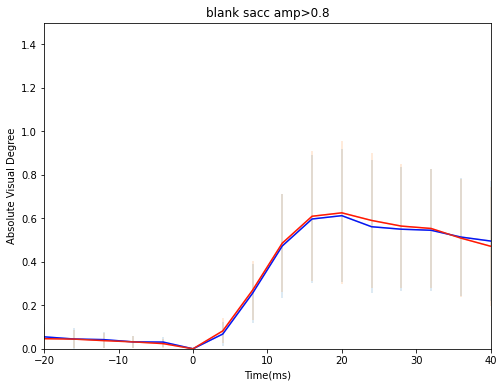

icms
blank Vs. icms
max_amp P:Ttest_indResult(statistic=8.19387579897912, pvalue=1.3703092295637145e-15)
deg P:Ttest_indResult(statistic=-4.232524824565131, pvalue=2.6971057604452814e-05)
peak_velocity P:Ttest_indResult(statistic=10.797980606870905, pvalue=2.972570150477579e-25)
correction_x P:Ttest_indResult(statistic=4.0091113560744205, pvalue=6.927847097862437e-05)
correction_y P:Ttest_indResult(statistic=13.149511526905941, pvalue=5.778698588519322e-36)
sac_axis_proj P:Ttest_indResult(statistic=13.709235942094908, pvalue=1.1654536090412775e-38)
blank Vs. icms w/o sac2rf
max_amp P:Ttest_indResult(statistic=1.084309430420618, pvalue=0.27906787715052433)
deg P:Ttest_indResult(statistic=-0.3552486779659399, pvalue=0.7226431175252648)
peak_velocity P:Ttest_indResult(statistic=0.9633519432651336, pvalue=0.33609201372252406)
correction_x P:Ttest_indResult(statistic=1.7253962581197426, pvalue=0.08511663295224435)
correction_y P:Ttest_indResult(statistic=1.2807408415691026, pvalue=0.2013041

In [8]:
#find mean sac of ICMS
import warnings

import plotly.graph_objects as go
time_before_and_after_ms=24
first_ms_dataset = find_first_ms_class(x,y,sac2RF,sac2RF_sacn)
first_ms_df = first_ms_dataset.find_first_ms(time_before_and_after_ms=time_before_and_after_ms,
                                             min_amp=0.2)
min_amp_for_polar=first_ms_dataset.min_amp_for_polar
polar_title = 'first ms ('+str(first_ms_dataset.ms_min_time_after_onset)+':'+str(first_ms_dataset.ms_max_time_after_onset)+' after onset .min of max ms amp is '+str(first_ms_dataset.min_amp_for_polar) +')' 
fig = plotly.subplots.make_subplots(rows=1, cols=2,
                                    x_title=polar_title,
                                    specs=[[{'type': 'polar'}]*2])

n_icms = str(len(first_ms_df.query('icms==1 and `max_amp`>'+min_amp_for_polar)))
n_no_icms = str(len(first_ms_df.query('icms==0 and `max_amp`>'+min_amp_for_polar)))
fig.add_trace(go.Scatterpolar(
      name = "icms N:"+n_icms,
      r =first_ms_df.query('icms==1 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['max_amp'],
      theta = first_ms_df.query('icms==1 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['deg'],
      thetaunit = "degrees",
      #fill='toself',
      mode = 'markers',
    ), 1, 1)
fig.add_trace(go.Scatterpolar(
      name = "no icms N:"+n_no_icms,
      r = first_ms_df.query('icms==0 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['max_amp'],
      theta = first_ms_df.query('icms==0 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['deg'],
      thetaunit = "degrees",
      #fill='toself',
      mode = 'markers',
    ), 1, 2)

fig.show()
polar_title = 'first ms ('+str(first_ms_dataset.ms_min_time_after_onset)+':'+str(first_ms_dataset.ms_max_time_after_onset)+' after onset .min of max ms amp is '+first_ms_dataset.min_amp_for_polar +')' 
fig = plotly.subplots.make_subplots(rows=1, cols=2,
                                    x_title=polar_title,
                                    specs=[[{'type': 'polar'}]*2])
n_sac2RF = str(len(first_ms_df.query('sac2RF==1 and `max_amp`>'+min_amp_for_polar)))
n_no_sac2RF = str(len(first_ms_df.query('sac2RF==0 and icms==1 and `max_amp`>'+min_amp_for_polar)))
fig.add_trace(go.Scatterpolar(
      name = "sac2rf N:"+n_sac2RF,
      r =first_ms_df.query('sac2RF==1 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['max_amp'],
      theta = first_ms_df.query('sac2RF==1 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['deg'],
      thetaunit = "degrees",
      #fill='toself',
      mode = 'markers',
    ), 1, 1)
fig.add_trace(go.Scatterpolar(
      name = "no sac2rf N:"+n_no_sac2RF,
      r = first_ms_df.query('sac2RF==0 and icms==1 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['max_amp'],
      theta = first_ms_df.query('sac2RF==0 and icms==1 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['deg'],
      thetaunit = "degrees",
      #fill='toself',
      mode = 'markers',
    ), 1, 2)

fig.show()
'''
fig = px.histogram(first_ms_df.query('`max_amp`>0'), x='max_amp', color="icms");fig.update_layout(barmode='overlay');fig.update_traces(opacity=0.75);fig.show();
fig = px.histogram(first_ms_df.query('peak_velocity>0'), x='peak_velocity', color="icms");fig.update_layout(barmode='overlay');fig.update_traces(opacity=0.75);fig.show();
fig = px.histogram(first_ms_df, x='correction_x', color="icms");fig.update_layout(barmode='overlay');fig.update_traces(opacity=0.75);fig.show();
fig = px.histogram(first_ms_df, x='correction_y', color="icms");fig.update_layout(barmode='overlay');fig.update_traces(opacity=0.75);fig.show();
fig = px.histogram(first_ms_df, x='sac_axis_proj', color="icms");fig.update_layout(barmode='overlay');fig.update_traces(opacity=0.75);fig.show();
fig = px.histogram(first_ms_df, x='latency', color="icms",nbins=50);fig.update_layout(barmode='overlay');fig.update_traces(opacity=0.75);fig.show();
'''
def sacc_icms_vs_blank(max_amp_larger_then=False,max_amp_lowest_then=4):
  print(f'find saccs larges than {max_amp_larger_then}:')
  max_amp_larger_idx = first_ms_df.max_amp.between(max_amp_larger_then,max_amp_lowest_then)
  if max_amp_larger_then:
    first_ms_dataset_np = find_first_ms_class(x[max_amp_larger_idx,:,:],y[max_amp_larger_idx],sac2RF[max_amp_larger_idx],sac2RF_sacn[max_amp_larger_idx],return_type='np')
  else:
      first_ms_dataset_np = find_first_ms_class(x,y,sac2RF,sac2RF_sacn,return_type='np')
  time_before_and_after_ms=20#in ms
  first_ms = first_ms_dataset_np.find_first_ms(time_before_and_after_ms=time_before_and_after_ms)
  first_ms = first_ms[:,~np.isnan(np.nanmean(first_ms,axis=(0,2))),:]
  icms_trial = np.logical_and(y==1,sac2RF==1)
  no_icms_trial = np.where(y==0)[0]
  print('icms')
  icms_first_ms = first_ms_dataset_np.find_first_ms(time_before_and_after_ms=time_before_and_after_ms)[icms_trial,:,:]
  last_idx = lambda fir: np.where(np.isnan(np.nanmean(fir,axis=(0,2))))[0][0]
  time_vec = lambda fir:np.arange(-time_before_and_after_ms,fir*4-time_before_and_after_ms,4)
  icms_last_idx = last_idx(icms_first_ms)
  onset_idx = np.ceil(time_before_and_after_ms/4).astype(int)
  icms_first_ms_x = icms_first_ms[:,:icms_last_idx,0]-icms_first_ms[:,onset_idx,0].reshape((-1,1))
  icms_first_ms_y = icms_first_ms[:,:icms_last_idx,1]-icms_first_ms[:,onset_idx,1].reshape((-1,1))
  icms_first_ms = np.stack((icms_first_ms_x,icms_first_ms_y),axis=2)
  plot_trial(np.nanmean(np.abs(icms_first_ms),axis=0),
            x_std=np.nanstd(np.abs(icms_first_ms),axis=0),time_vec=time_vec(icms_last_idx))
  plt.xlim((-20,40))
  plt.xlabel('Time(ms)')
  plt.ylabel('Absolute Visual Degree')
  plt.ylim((0,1.5))
  plt.title(f'ICMS sacc amp>{max_amp_larger_then}')
  plt.show()
  print('w/o icms')
  no_icms_first_ms = first_ms_dataset_np.find_first_ms(time_before_and_after_ms=time_before_and_after_ms)[no_icms_trial,:,:]
  no_icms_last_idx = last_idx(no_icms_first_ms)
  no_icms_first_ms_x = no_icms_first_ms[:,:no_icms_last_idx,0]-no_icms_first_ms[:,onset_idx,0].reshape((-1,1))
  no_icms_first_ms_y = no_icms_first_ms[:,:no_icms_last_idx,1]-no_icms_first_ms[:,onset_idx,1].reshape((-1,1))
  no_icms_first_ms = np.stack((no_icms_first_ms_x,no_icms_first_ms_y),axis=2)
  plot_trial(np.nanmean(np.abs(no_icms_first_ms),axis=0),
            x_std=np.nanstd(np.abs(no_icms_first_ms),axis=0),time_vec=time_vec(no_icms_last_idx))
  plt.xlim((-20,40))
  plt.xlabel('Time(ms)')
  plt.ylim((0,1.5))
  plt.ylabel('Absolute Visual Degree')
  plt.title(f'blank sacc amp>{max_amp_larger_then}')
  plt.show()
sacc_icms_vs_blank()
sacc_icms_vs_blank(max_amp_larger_then=0)
sacc_icms_vs_blank(max_amp_larger_then=0.4)
sacc_icms_vs_blank(max_amp_larger_then=0.5)
sacc_icms_vs_blank(max_amp_larger_then=0.8)
sacc_icms_vs_blank(max_amp_larger_then=1)
sacc_icms_vs_blank(max_amp_larger_then=0.8,max_amp_lowest_then=1.2)
'''
plt.plot(deg_amp_mat,x=range(time_len),y=deg_bins_arr)
plt.pcolormesh(deg_amp_mat)
fig = px.imshow(deg_amp_mat,
                #labels=dict(x="time", y="deg"),
                x=range(time_len),
                y=deg_bins_arr
               )
import plotly.graph_objects as go

plt.show()
plt.subplot(211)
plt.pcolormesh(first_ms_pol[...,0])
plt.subplot(212)
plt.pcolormesh(first_ms_pol[...,1])
plt.show()
ms_time_vec =np.arange(0,mean_3d_sac.shape[0]*4,4)
plot3d_time,plot3d_amp,plot3d_deg = np.meshgrid(ms_time_vec,mean_3d_sac[:,0],mean_3d_sac[:,1])
plt.contourf(ms_time_vec,mean_3d_sac[:,0],mean_3d_sac[:,1])
plt.imshow((plot3d_time,plot3d_amp,plot3d_deg), vmin=plot3d_amp.min(), vmax=plot3d_amp.max(), origin='lower',
           extent=[plot3d_time.min(), plot3d_time.max(), plot3d_deg.min(), plot3d_deg.max()])
'''
def plot_ms_matrix(first_ms):
  with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    figure = plt.figure(figsize=(10,90))
    cond_trial_num = first_ms.shape[0]
    x_axis = np.arange(first_ms.shape[1])
    ax = plt.axes()
    for sbplot in range(cond_trial_num):
      fig= plt.subplot(cond_trial_num,5,sbplot+1)
      plt.plot(x_axis,first_ms[sbplot,:,0]-np.nanmean(first_ms[sbplot,:,0]),'b')
      #plt.ylim((-2,2))
      plt.plot(x_axis,first_ms[sbplot,:,1]-np.nanmean(first_ms[sbplot,:,1]),'r')
      #plt.ylim((-2,2))
      fig.axes.axis("off")
  plt.show()
print('icms')
no_icms_idx = first_ms_df.query('icms==0').index
icms_idx = first_ms_df.query('icms==1').index
import scipy
print('blank Vs. icms')
for var in ['max_amp','deg','peak_velocity','correction_x','correction_y','sac_axis_proj']:
  p=scipy.stats.ttest_ind(first_ms_df.loc[icms_idx,var], first_ms_df.loc[no_icms_idx,var], axis=0, equal_var=False, nan_policy='omit')
  print(f'{var} P:{p}')
no_icms_idx = first_ms_df.query('icms==0').index
no_sac2rf_idx = first_ms_df.query('sac2RF==0 and icms==1').index
print('blank Vs. icms w/o sac2rf')
for var in ['max_amp','deg','peak_velocity','correction_x','correction_y','sac_axis_proj']:
  p=scipy.stats.ttest_ind(first_ms_df.loc[no_sac2rf_idx,var], first_ms_df.loc[no_icms_idx,var], axis=0, equal_var=False, nan_policy='omit')
  print(f'{var} P:{p}')
#plot_ms_matrix(icms_first_ms)
print('w/o icms')
#plot_ms_matrix(no_icms_first_ms)

In [9]:
'''x_axis = np.arange(first_ms.shape[1])
for trial in range(50,80,3):
  plt.plot(np.arange(-200,4*136-200,4),first_ms[trial,:,0]-np.nanmean(first_ms[trial,30:50,0]),'b')
  #for i in first_ms_df[trial].
  plt.ylabel('X (visual deg)')
  plt.xlabel('Time (ms)')
  plt.show()
  '''

"x_axis = np.arange(first_ms.shape[1])\nfor trial in range(50,80,3):\n  plt.plot(np.arange(-200,4*136-200,4),first_ms[trial,:,0]-np.nanmean(first_ms[trial,30:50,0]),'b')\n  #for i in first_ms_df[trial].\n  plt.ylabel('X (visual deg)')\n  plt.xlabel('Time (ms)')\n  plt.show()\n  "

In [10]:
'''def spectrogram(samples, sample_rate, stride_ms = 8.0, 
                          window_ms = 16.0, max_freq = None, eps = 1e-14):

    stride_size = int(0.004 * sample_rate * stride_ms)
    window_size = int(0.004 * sample_rate * window_ms)

    # Extract strided windows
    truncate_size = (len(samples) - window_size) % stride_size
    samples = samples[:len(samples) - truncate_size]
    nshape = (window_size, (len(samples) - window_size) // stride_size + 1)
    nstrides = (samples.strides[0], samples.strides[0] * stride_size)
    windows = np.lib.stride_tricks.as_strided(samples, 
                                          shape = nshape, strides = nstrides)
    
    assert np.all(windows[:, 1] == samples[stride_size:(stride_size + window_size)])

    # Window weighting, squared Fast Fourier Transform (fft), scaling
    weighting = np.hanning(window_size)[:, None]
    
    fft = np.fft.rfft(windows * weighting, axis=0)
    fft = np.absolute(fft)
    fft = fft**2
    
    scale = np.sum(weighting**2) * sample_rate
    fft[1:-1, :] *= (2.0 / scale)
    fft[(0, -1), :] /= scale
    
    # Prepare fft frequency list
    freqs = float(sample_rate) / window_size * np.arange(fft.shape[0])
    
    # Compute spectrogram feature
    ind = np.where(freqs <= max_freq)[0][-1] + 1
    specgram = np.log(fft[:ind, :] + eps)
    return specgram
Sxx = spectrogram(x[0,:,0],250,max_freq=125)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
'''

"def spectrogram(samples, sample_rate, stride_ms = 8.0, \n                          window_ms = 16.0, max_freq = None, eps = 1e-14):\n\n    stride_size = int(0.004 * sample_rate * stride_ms)\n    window_size = int(0.004 * sample_rate * window_ms)\n\n    # Extract strided windows\n    truncate_size = (len(samples) - window_size) % stride_size\n    samples = samples[:len(samples) - truncate_size]\n    nshape = (window_size, (len(samples) - window_size) // stride_size + 1)\n    nstrides = (samples.strides[0], samples.strides[0] * stride_size)\n    windows = np.lib.stride_tricks.as_strided(samples, \n                                          shape = nshape, strides = nstrides)\n    \n    assert np.all(windows[:, 1] == samples[stride_size:(stride_size + window_size)])\n\n    # Window weighting, squared Fast Fourier Transform (fft), scaling\n    weighting = np.hanning(window_size)[:, None]\n    \n    fft = np.fft.rfft(windows * weighting, axis=0)\n    fft = np.absolute(fft)\n    fft = fft**2

latency P:Ttest_indResult(statistic=-7.3885963954884115, pvalue=4.662817542548545e-13)
mean icms:166.52818991097922 +-99.66171240984399
 mean blank:229.76969696969698 +-119.90731896899544


max_amp P:Ttest_indResult(statistic=11.188170350532372, pvalue=1.4961050702544158e-26)
mean icms:1.4648146629196015 +-0.7031245897255023
 mean blank:0.7411625255547603 +-0.9446124269516221


sac_axis_proj P:Ttest_indResult(statistic=15.977894483057108, pvalue=9.888253406239154e-44)
mean icms:1.4470718430482 +-0.6556622251654898
 mean blank:0.4447482508663175 +-0.653510658006787


nsperarg=128 --1


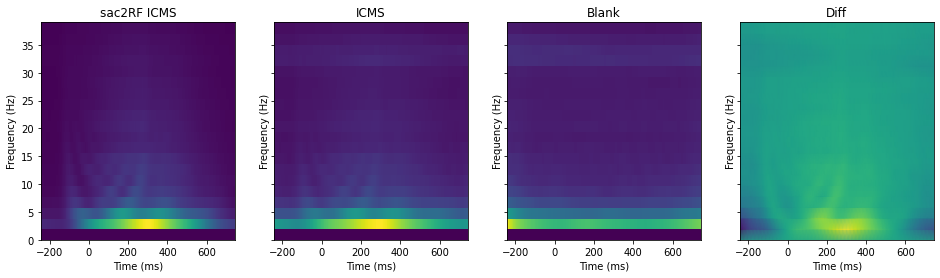

nsperarg=128 --2


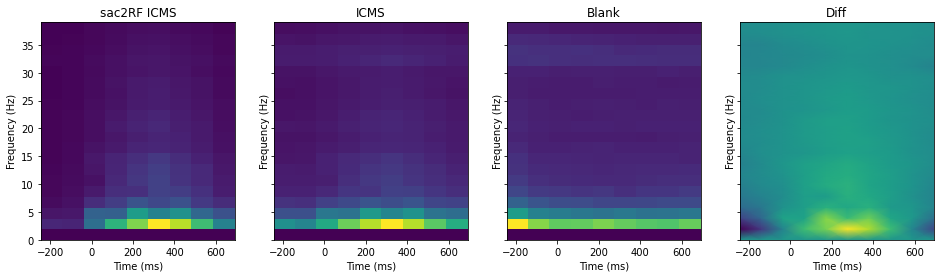

nsperarg=128 --3


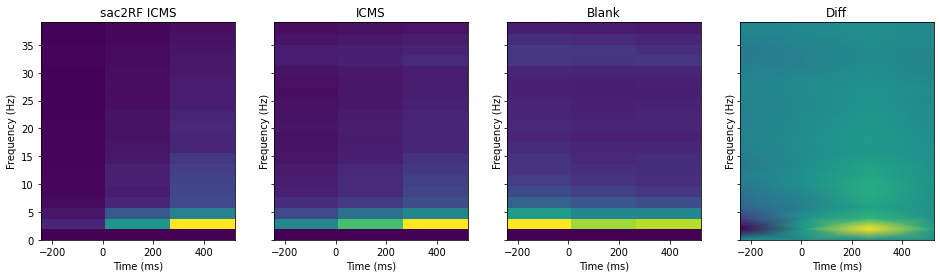

nsperarg=100 --1


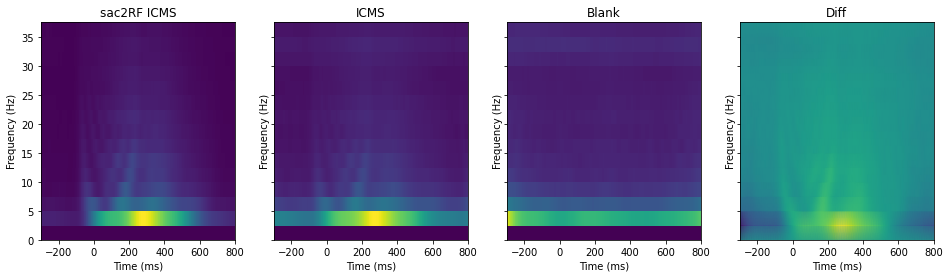

nsperarg=100 --2


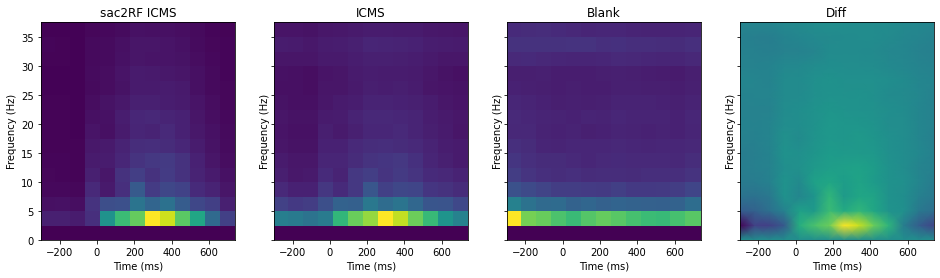

nsperarg=100 --3


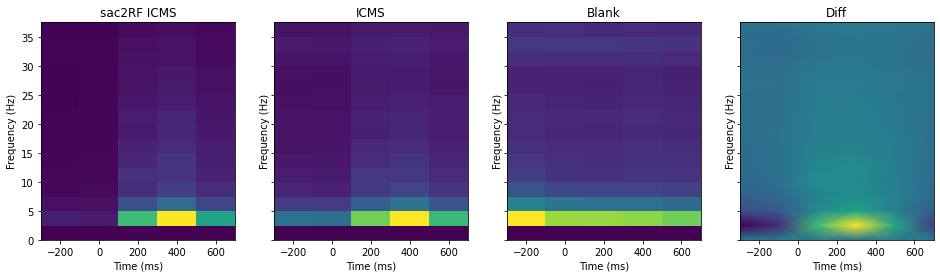

nsperarg=64 --1


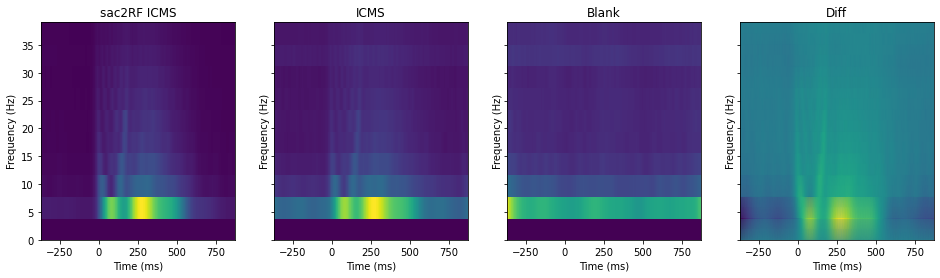

nsperarg=64 --2


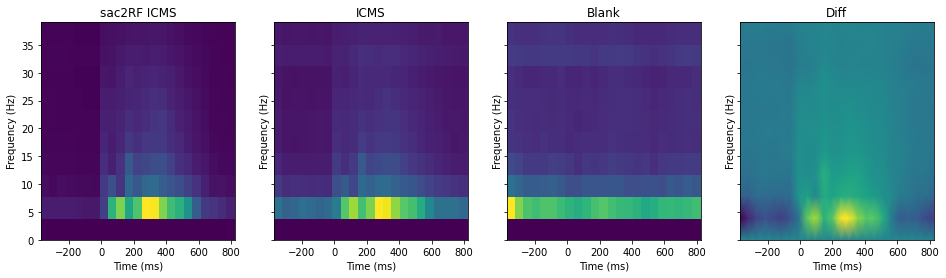

nsperarg=64 --3


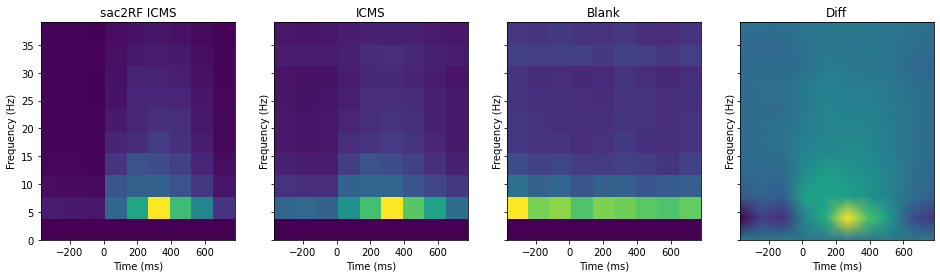

nsperarg=57 --1


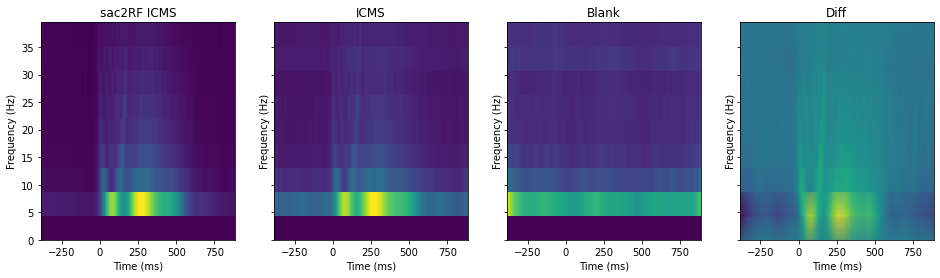

nsperarg=57 --2


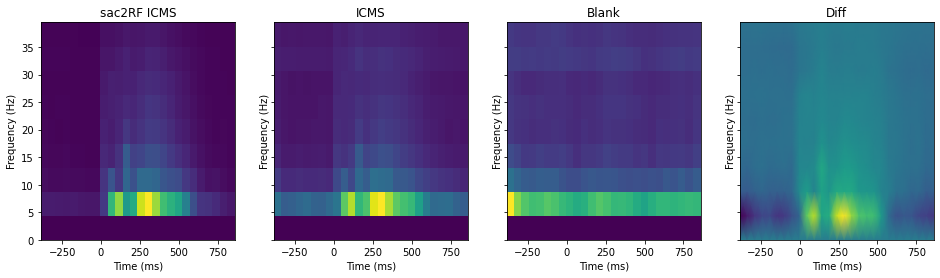

nsperarg=57 --3


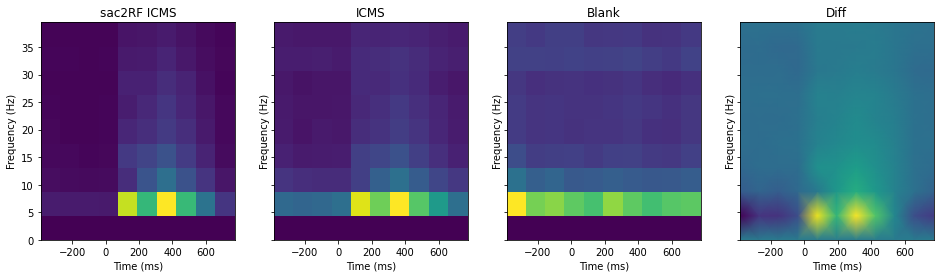

nsperarg=53 --1


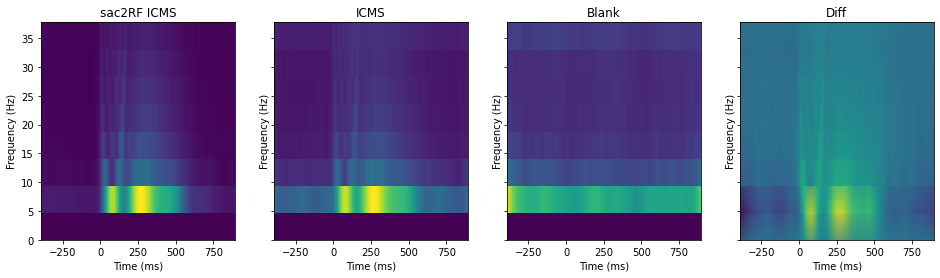

nsperarg=53 --2


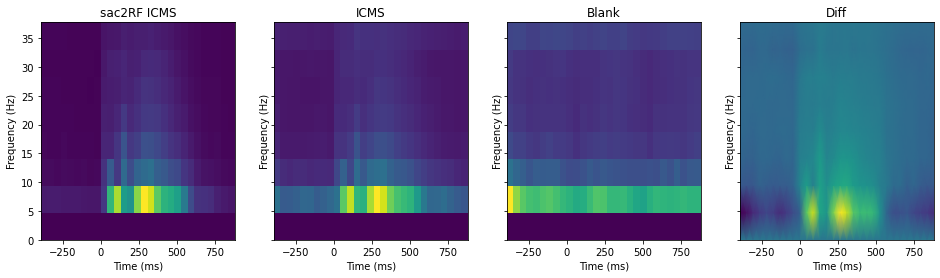

nsperarg=53 --3


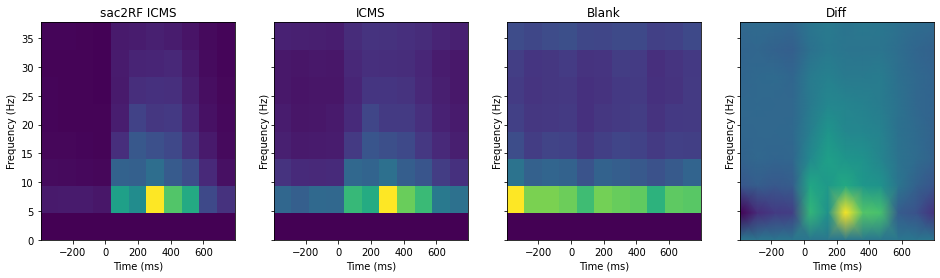

nsperarg=50 --1


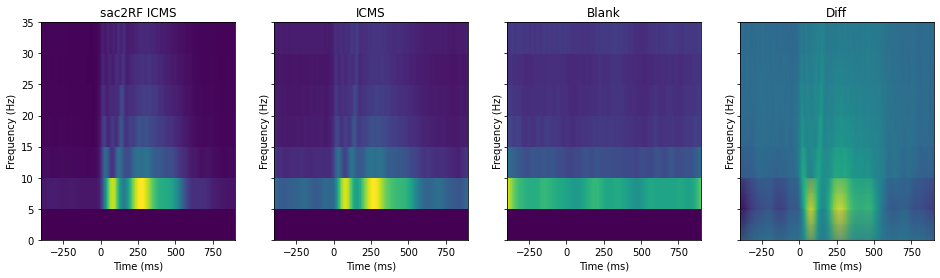

nsperarg=50 --2


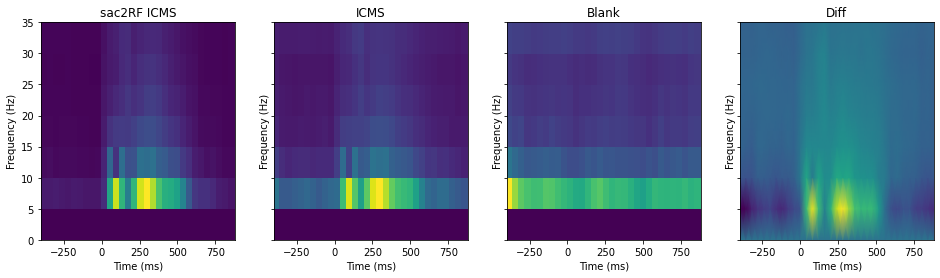

nsperarg=50 --3


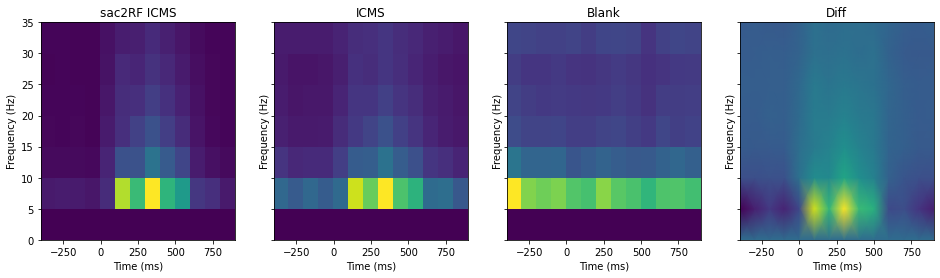

nsperarg=45 --1


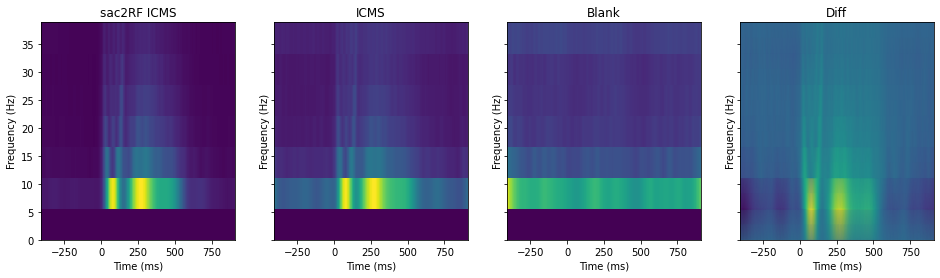

nsperarg=45 --2


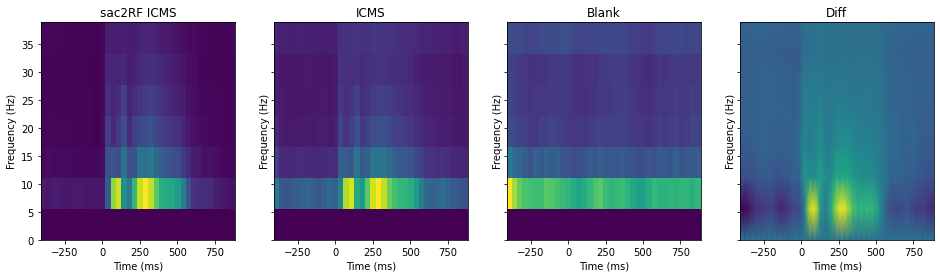

nsperarg=45 --3


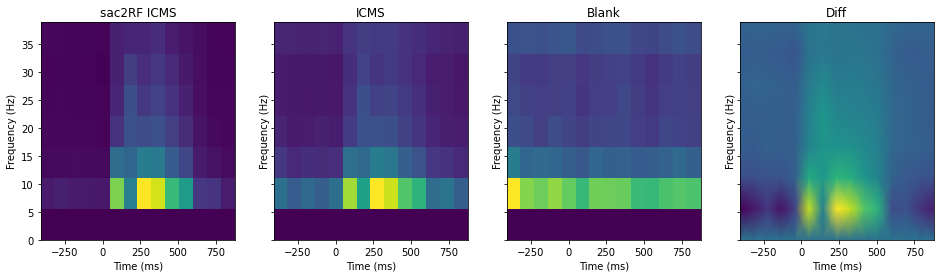

nsperarg=32 --1


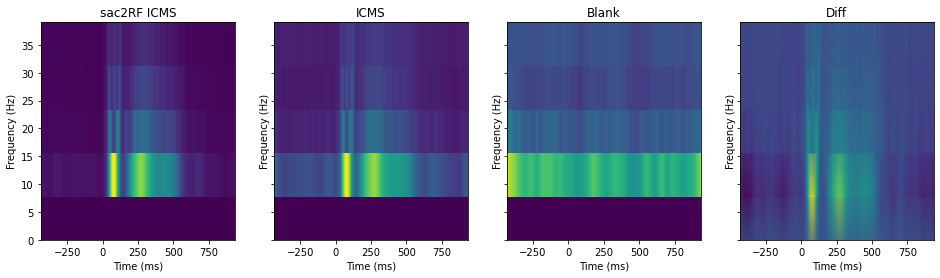

nsperarg=32 --2


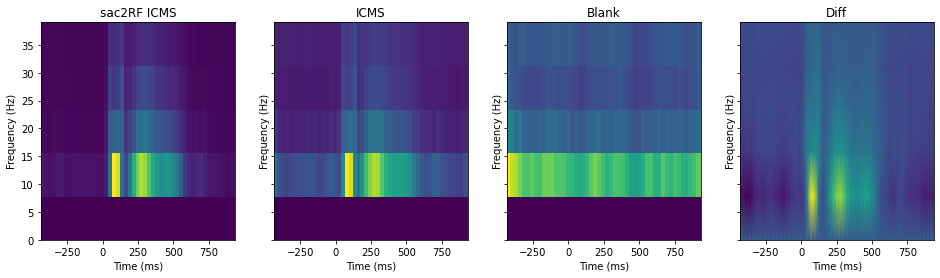

nsperarg=32 --3


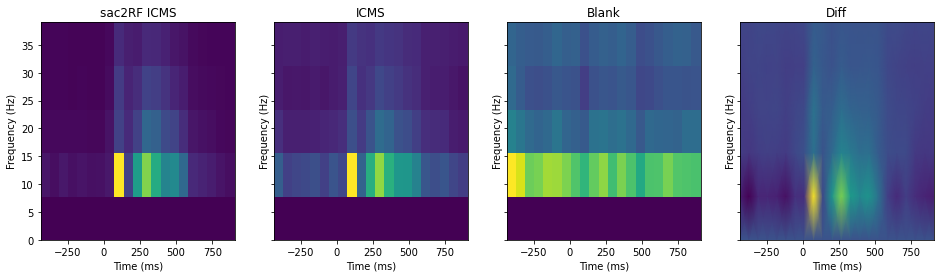

In [11]:
import plotly.figure_factory as ff

def dist_plot(df,feat,bin_range=1,cond=False,color='icms',show=True,only_sac2rf_icms_and_blank=False,fig=False,x_title=False):
  df=df.copy()
  if cond:
    df =df.query(cond)
  if only_sac2rf_icms_and_blank:
    df=df.query('(icms==1 and sac2RF==1) or icms==0')
  #fig = px.histogram(df, x=feat, color=color);
  
  #fig = px.density_heatmap(df,x=feat, color=color)
  #fig.update_layout(barmode='overlay');
  #fig.update_traces(opacity=0.75);
  icms_values=df.loc[df['icms']==1,feat].to_numpy()
  no_icms_values=df.loc[df['icms']==0,feat].to_numpy()
  #bin_range=np.ptp(np.concatenate((icms_values,no_icms_values)).flatten())/20
  if not fig:
    fig = ff.create_distplot([icms_values,no_icms_values], ['ICMS','Blank'],
                             curve_type='kde',bin_size =bin_range,histnorm='probability')
  #  else
  #fig.add_
  fig.update_layout(title_text=feat)
  fig.update_yaxes(title='Normalized Probability')
  if x_title:
    fig.update_xaxes(title=x_title)
  p=scipy.stats.ttest_ind(icms_values, no_icms_values, axis=0, equal_var=False, nan_policy='omit')
  print(f'{feat} P:{p}')
  print(f'mean icms:{np.mean(icms_values)} +-{np.std(icms_values)}\n mean blank:{np.mean(no_icms_values)} +-{np.std(no_icms_values)}')
  if show:
    fig.show()
  else:
    return fig
dist_plot(first_ms_df,'latency',cond='latency>0 and max_amp>0.2',color='icms',only_sac2rf_icms_and_blank=True,x_title='Time (ms)',bin_range=20)
dist_plot(first_ms_df,'max_amp',cond='max_amp>0.2',color='icms',only_sac2rf_icms_and_blank=True, x_title='Visual degree',bin_range=0.2)
dist_plot(first_ms_df,'sac_axis_proj',cond='sac_axis_proj>0 and max_amp>0.2',color='icms',only_sac2rf_icms_and_blank=True, x_title='Visual degree',bin_range=0.2)
#dist_plot(first_ms_df,'peak_velocity',cond='peak_velocity>0',color='icms',only_sac2rf_icms_and_blank=False)
fig = plotly.graph_objs.Figure()
po = first_ms_df.query('icms==1 and sac2RF==1')
fig = fig.add_trace(plotly.graph_objs.Scatter(x=po.query('latency>0 and max_amp>0.2')['latency'],y=po.query('latency>0 and max_amp>0.2')['max_amp'],mode='markers',name='ICMS'))
po = first_ms_df.query('icms==0')
fig = fig.add_trace(plotly.graph_objs.Scatter(x=po.query('latency>0 and max_amp>0.2')['latency'],y=po.query('latency>0 and max_amp>0.2')['max_amp'],mode='markers',name='blank'))
fig.update_xaxes(title='Latency (ms)')
fig.update_yaxes(title='Max amp (visual degree)')
fig.show()
fig = plotly.graph_objs.Figure()
po = first_ms_df.query('icms==1 and sac2RF==1')
fig = fig.add_trace(plotly.graph_objs.Scatter(x=po.query('latency>0 and max_amp>0.2')['latency'],y=po.query('latency>0 and max_amp>0.2')['max_amp'],mode='markers',name='ICMS'))
po = first_ms_df.query('icms==0')
fig = fig.add_trace(plotly.graph_objs.Scatter(x=po.query('latency>0 and max_amp>0.2')['latency'],y=po.query('latency>0 and max_amp>0.2')['sac_axis_proj'],mode='markers',name='blank'))
fig.update_xaxes(title='Latency (ms)')
fig.update_yaxes(title='sac axis proj (visual degree)')
fig.show()
def sac_axis_proj(x,axis_deg = sac_axis):
  rad = np.arctan2(x[:,1], x[:,0]) # In radians
  deg=  rad * (180 / np.pi)
  deg_diff_between_sac_axis_and_ms = axis_deg-deg
  max_amp = np.sqrt(np.power(x[:,0],2)+np.power(x[:,1],2))
  sac_axis_proj = max_amp*np.cos(deg_diff_between_sac_axis_and_ms/180*np.pi)
  return sac_axis_proj
def plot_spec(s_arr,idx,title,ax,f,t):
      t = t*1000-500
      #avg_func = partial(np.nanmean)
      if isinstance(idx,int) and idx ==-1:
        ax.pcolormesh(t, f[:s_arr.shape[0]], s_arr,cmap='viridis', shading='gouraud')
      else:
        ax.pcolormesh(t, f[:s_arr.shape[0]], np.nanmean(s_arr[:,:,idx],axis=2),cmap='viridis')
      ax.set_title(title)
      ax.set_ylabel('Frequency (Hz)')
      ax.set_xlabel('Time (ms)')
for q in (128,100,64,57,53,50,45,32):
  for d in (1,2,3):
    print(f'nsperarg={q} --{d}')
    nsperarg=q
    if d==1:
      noverlap = nsperarg-1
    elif d==2:
      noverlap = int(nsperarg*0.8) 
    else:  
      noverlap = nsperarg//2

    fmax=40
    f, t, Sxx = scipy.signal.spectrogram(x[0,:,0],fs=250,nperseg=nsperarg,noverlap=noverlap)
    limeted_freq_idx = np.where(f<fmax)[0]
    if limeted_freq_idx.shape[0]<=1:
      continue
    #Sxx = spectrogram(x[i,:,0],250,max_freq=fmax,window_ms=nsperarg,stride_ms = nsperarg - noverlap)
    s_arr = np.zeros((len(f),len(t),len(y)))*np.nan
    s_arr = np.zeros((len(limeted_freq_idx),Sxx.shape[1],len(y)))*np.nan
    #size of t is Fs*window_len*ms/overlapping  -> 250*4*0.004/(8-4)
    f, t, Sxx = scipy.signal.spectrogram(x[0,:,0],fs=250,nperseg=nsperarg,noverlap=noverlap)
    f_grid =  np.tile(f,(len(t),1)).T
    for i in range(len(y)):
      #Sxx freq X time_segments
      #Sxx = spectrogram(x[i,:,0],250,max_freq=fmax,window_ms=nsperarg,stride_ms = nsperarg - noverlap)
      f, t, Sxx = scipy.signal.spectrogram(sac_axis_proj(x[i,:,:]),fs=250,nperseg=nsperarg,noverlap=noverlap)
      s_arr[:,:,i] = (Sxx[limeted_freq_idx,:] * f_grid [limeted_freq_idx,:])/sum(Sxx[limeted_freq_idx,:]).sum()
      #s_arr[:,:,i] = (Sxx[limeted_freq_idx,:] )/sum(Sxx[limeted_freq_idx,:]).sum()
    #f, t, Sxx = signal.spectrogram(x, fs)
    blank_idx = np.where(y==0)[0]
    icms_sac2rf_idx = np.logical_and(y==1,sac2RF==1)
    icms_idx = np.where(y==1)[0]
    fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,sharey=True,figsize=(16, 4))
    plot_spec(s_arr,icms_sac2rf_idx,'sac2RF ICMS',ax1,f,t)
    plot_spec(s_arr,icms_idx,'ICMS',ax2,f,t)
    plot_spec(s_arr,blank_idx,'Blank',ax3,f,t)
    plot_spec(s_arr[:,:,icms_idx].mean(axis=2)-s_arr[:,:,blank_idx].mean(axis=2),-1,'Diff',ax4,f,t)
    plt.show()
    '''
    plt.pcolormesh(t, f[:s_arr.shape[0]], np.nanmean(s_arr[:,:,icms_idx],axis=2), shading='gouraud')
    plt.title('ICMS')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
    plt.pcolormesh(t, f[:Sxx.shape[0]], np.nanmean(s_arr[:,:,blank_idx],axis=2), shading='gouraud')
    plt.title('Blank')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()  
    '''

# simple models: DT

## features_extraction class + plot func

In [12]:
class features_extraction():
    def __init__(self,x,split_times=False,split_in_ms=True):
      self.x=x
      self.sampels = x.shape[1]
      self.trials_num = x.shape[0]
      self.timeline = timeline
      self.Fs = 250 #Hz, Sampling rate 
      #split_times contain the idx of times in each split
      self.all_samp_idx = np.arange(self.sampels)
      if not split_times or split_times==1:
        self.split_times = [self.all_samp_idx] #all of the times in the first and only group
        self.split_times_title = ['']
      elif type(split_times) is int:
          # if there is a integar we will split the timeline #split_times times.
        self.split_times = np.array_split(self.all_samp_idx,split_times)
        self.split_times_title = [str(timeline[tit[0]])+':'+str(timeline[tit[-1]]) for tit in self.split_times]
      else:
        self.split_times = split_times
        self.split_times_title = [str(timeline[tit[0]])+':'+str(timeline[tit[-1]]) for tit in self.split_times]
 
    def new_feature(self,feature_function,feature_name,all_trial=False,axes=['x','y']):
      fnum = len(feature_name) if type(feature_name) is list else 1
      if len(axes)>1 and not axes=='both':
        out_df=[None]*len(axes)
        for axis_i,cur_axes_name in enumerate(axes):
          out_np = np.empty((self.trials_num,len(self.split_times)*fnum))
          for times_i, cur_times in enumerate(self.split_times):
              cur_times = self.all_samp_idx if all_trial else cur_times
              for trial_i,trial in enumerate(self.x[:,cur_times,axis_i]):
                f_dim1 = times_i*fnum
                out_np[trial_i,f_dim1:(f_dim1+fnum)] = feature_function(trial,times_i=times_i)
          feature_name_extended = [str(cur_axes_name) +'-'+ cur_feat +' '+ cur_split_times_title for cur_split_times_title in self.split_times_title for cur_feat in feature_name ]
 
          #feature_name_extended = [str(cur_axes_name) +'-'+ feature_name +' '+ cur_split_times_title for cur_split_times_title in self.split_times_title]
          out_df[axis_i] = pd.DataFrame(out_np,columns=feature_name_extended)
        return  pd.concat(out_df,axis=1)
 
      elif len(axes)==1 or axes=='both':
        out_np = np.empty((self.trials_num,len(self.split_times)*fnum))
        for times_i, cur_times in enumerate(self.split_times):
            cur_times = self.all_samp_idx if all_trial else cur_times
            for trial_i,trial in enumerate(self.x[:,cur_times,:]):
              f_dim1 = times_i*fnum
              out_np[trial_i,f_dim1:(f_dim1+fnum)] = feature_function(trial,times_i=times_i)
        feature_name_extended = [cur_feat +' '+ cur_split_times_title for cur_split_times_title in self.split_times_title for cur_feat in feature_name ]
        out_df = pd.DataFrame(out_np,columns=feature_name_extended)
      return out_df
    def max_change(self):
      return self.new_feature(self.max_change_func,['max_change'])
    def max_change_func(self,trial,times_i):
      return np.max(trial) - np.min(trial)
    def trajectory(self):
      return self.new_feature(self.trajectory_func,['traj'],axes='both')
    def trajectory_func(self,trial,times_i):
      delta_x = np.diff(trial[:,0])
      delta_y = np.diff(trial[:,1])
      return np.sum((delta_y**2+delta_x**2)**0.5)/len(delta_x)
    def trajectory_wo_sacc(self):
      return self.new_feature(self.trajectory_wo_sacc_func,['traj_wo_sacc'],all_trial=True,axes='both')
    def trajectory_wo_sacc_func(self,all_trial,times_i):
      vel = vecvel(all_trial,self.Fs)
      ms_df = microsacc(all_trial,vel,self.std_thrs,self.mindur)
      cur_times = self.split_times[times_i]
      sac_was_found = int(len(ms_df))
      sacc_times=np.array([])
      for i, cur_sacc in ms_df.iterrows():
        cur_sacc_times = np.arange(cur_sacc.onset-2,cur_sacc.offset+3)
        sacc_times = np.concatenate((sacc_times, cur_sacc_times))
      no_sacc_times = np.setdiff1d(cur_times,sacc_times)
      delta_x = np.insert(np.diff(all_trial[no_sacc_times,0]),0,0)
      delta_y = np.insert(np.diff(all_trial[no_sacc_times,1]),0,0)
      #print(f'{len(delta_x)} ',end='')
      return np.sum((delta_y**2+delta_x**2)**0.5)/len(delta_x)
    def MSfind(self,sac_num=2):
      self.std_thrs = 5.5 
      self.mindur = 4
      features = ['onset','offset','peak_velocity','dx','dy','max_amp x','max_amp y','max_amp',
                    'deg','correction x','correction y']
      features_full = ['sac' + str(cur_sac+1) + ':' + cur_feature for cur_sac in range(sac_num) for cur_feature in features]
      features_full.insert(0,'nsac')
      print(features_full)
      print(f'MS find thrs:{self.std_thrs} std. mindur:{self.mindur}*4={self.mindur*4}.')
      return self.new_feature(partial(self.MSfind_func,features=features,sac_num=sac_num),
                              features_full,
                              all_trial=True,axes='both')
    def MSfind_func(self,all_trial,times_i,features='all',sac_num=10):
      if features=='all':
        features = ['onset','offset','peak_velocity','dx','dy','max_amp x','max_amp y','max_amp',
                    'deg','correction x','correction y']
 
      vel = vecvel(all_trial,self.Fs)
      ms_df = microsacc(all_trial,vel,self.std_thrs,self.mindur)
      ms=[]
      fill_empty_with =0 #-1000 # or np.nan
      cur_times = self.split_times[times_i]
      sac_was_found = int(len(ms_df))
      sac_was_found_in_this_bin = 0
      for i in range(sac_was_found):
        if ms_df['onset'].iloc[i] in cur_times:
          sac_was_found_in_this_bin +=1 
      for cur_sac in range(sac_num):
        for cur_feature in features:
          if sac_was_found_in_this_bin>cur_sac and ms_df['onset'].iloc[cur_sac] in cur_times :
            ms.append(ms_df[cur_feature].iloc[cur_sac])
          else:
            if cur_feature in ['peak_velocity','dx','dy','max_amp x','max_amp y','max_amp',
                    'deg','correction x','correction y']:
              ms.append(0)
            else:
             ms.append(fill_empty_with)
      ms.insert(0,sac_was_found_in_this_bin)
      if sac_was_found_in_this_bin>sac_num:
        print('Warning: There is a %i microsaccades in this bin when only %i is collected in the dataframe.'%(sac_was_found_in_this_bin,sac_num))
      ms_np=np.array(ms)
      return ms_np
    def freq_power(self,bins_num=40,rotate_axis=False):
      #freq_out = np.arange(0,126,2)
      freq_out = np.arange(2,128,2)
      groups = 11
      freq_groups  = [0]*groups
      cnt=0
      brk=False
      for i in range(groups):
        cur_group = [freq_out[cnt]]
        cnt+=1
        for k in range(i):
          cur_group.append(freq_out[cnt])
          cnt+=1
          if cnt >= len(freq_out):
            brk=True
            break
        freq_groups[i]=cur_group
        if brk:
          print('a')
          break
          '''
      freq_groups = #[*zip(cutt_points[:-1],cutt_points[1:])]
      formatNumber = lambda n: n if n%1 else int(n)
      freq_rounder = lambda freq: formatNumber(np.round(freq,np.int(np.min((3,5/freq)))))
      freq_name = ['freq '+str(freq_rounder(a))+':'+str(freq_rounder(b)) for (a,b) in freq_groups]
      '''
      if not rotate_axis:
        freq_name =['freq '+str(cur_group[0])+':'+str(cur_group[-1]) for cur_group in freq_groups]
        return self.new_feature(partial(self.freq_power_func,freq_groups=freq_groups),
                              freq_name)
      else:
        freq_name =['freq '+str(cur_group[0])+':'+str(cur_group[-1])+' '+str(rotate_axis)+'°' for cur_group in freq_groups]
        return self.new_feature(partial(self.freq_power_func,freq_groups=freq_groups,rotate_axis=rotate_axis),
                              freq_name,axes='both')
    def freq_power_func(self,trial,freq_groups,times_i,rotate_axis=False):
      if not rotate_axis:
        f, Pxx_den = scipy.signal.welch(trial,self.Fs,nperseg=50,noverlap=40)#scipy.signal.periodogram(trial, self.Fs)
      else:
        f, Pxx_den = scipy.signal.welch(sac_axis_proj(trial,rotate_axis),self.Fs,nperseg=50,noverlap=40)#scipy.signal.periodogram(trial, self.Fs)
      #f, Pxx_den = scipy.signal.welch(trial,self.Fs)#scipy.signal.periodogram(trial, self.Fs)
      '''
      pdb.set_trace()
      f,pxx= scipy.signal.welch(trial,Fs)
      plt.plot(f,pxx)
      '''
      powers = np.zeros(len(freq_groups),dtype=np.float64)
      pxx_after_mul_f =np.multiply(Pxx_den,f)
      for i,cur_freq_range in enumerate(freq_groups):
        idx = [idx for idx,val in enumerate(f) if val in cur_freq_range] #np.logical_and(cur_freq_range[0]<f,f<cur_freq_range[1])
 
        powers[i] = np.mean(pxx_after_mul_f[idx])#*np.mean(f[idx]) #normlize the power by the correspanding freq
        #plt.plot([np.mean(cur_grp) for cur_grp in freq_groups],powers)
        #pdb.set_trace()
          #*f[idx]
      return powers
def feat_num(data):
    return copy.deepcopy(len(data.columns))
def select_features(df,y,method=1,k=100,return_all_feat_order=False):
  original_x_dim = feat_num(df)
  from sklearn.feature_selection import VarianceThreshold
 
  #remove features w/o variance
  sel = VarianceThreshold()
  sel.fit(df)
  selected_feat = sel.get_support()
  selected_col = df.columns[selected_feat]
  df = df[selected_col]
  feat_num_after_zeros_0var_discard = len(df.columns)
 
  if (k=='all' or k>feat_num_after_zeros_0var_discard) and not return_all_feat_order:
    k='all'
    return df
  if method==1:
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import mutual_info_classif
    model = SelectKBest(mutual_info_classif,k=k).fit(df,y)
    feat_sorted_by_info = np.argsort(model.scores_)
    selected_feat = model.get_support()
    if return_all_feat_order:
      return df.columns[feat_sorted_by_info]
  elif method ==2:
    #sequntial
    from sklearn.feature_selection import SequentialFeatureSelector
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=2)
    sfs = SequentialFeatureSelector(knn, n_features_to_select=k,n_jobs=-1)
    sfs.fit(df, y)
    selected_feat = sfs.get_support()
  else:
    print('Wrong value for method. feature selection has not been applied')
  selected_col = df.columns[selected_feat]
  df = df[selected_col]
  print(f'features selection reduce the dimensionality from {original_x_dim} ({feat_num_after_zeros_0var_discard} after removing features with zero variance) to {feat_num(df)}.')
  return df


## features dataframe generate

In [13]:
def create_feature_df(x,y,sac2RF,sac2RF_sacn,with_feat_select=False,discard_label=True):
  df=[]
  
  feat_ext3 = features_extraction(x,split_times=3)
  df.append(feat_ext3.max_change())
  
  df.append(feat_ext3.trajectory())
  df.append(feat_ext3.freq_power())
  df.append(feat_ext3.freq_power(rotate_axis=sac_axis))
  df.append(feat_ext3.freq_power(rotate_axis=sac_axis+90))
  df.append(feat_ext3.MSfind(sac_num=6))
  df.append(feat_ext3.trajectory_wo_sacc())
  
  #feat_ext30 = features_extraction(x,split_times=30)
  #df.append(feat_ext30.MSfind(sac_num=1))
  first_ms_dataset = find_first_ms_class(x,y,sac2RF,sac2RF_sacn)
  first_ms_df = first_ms_dataset.find_first_ms().fillna(0)
  if discard_label:
    first_ms_df = first_ms_df.drop(columns=['icms','sac2RF'],axis=1)
  df.append(first_ms_df)
  df = pd.concat(df,axis=1)
  df = df.dropna(axis=1)
  time_from_last_sac_offset=[]
  non_sacc_trials=-1e5
  for all_trial in x:
    vel = vecvel(all_trial,feat_ext3.Fs)
    ms_df = microsacc(all_trial,vel,feat_ext3.std_thrs,feat_ext3.mindur)
    #pdb.set_trace()
    time_from_last_sac_offset_ = np.max(ms_df['offset'][ms_df['offset']<124])#timline[124]=0, is the onset
    if not np.isnan(time_from_last_sac_offset_):
      time_from_last_sac_offset.append(timeline[time_from_last_sac_offset_])
    else:
        time_from_last_sac_offset.append(non_sacc_trials)
  df['time_from_last_sac']=time_from_last_sac_offset
  if with_feat_select:
    df=select_features(df,y,k=160,method=1)
#features = ['nsac','y max_change','x max_change']#df.columns
 
#rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
  display(df)
  return df

In [14]:
df = create_feature_df(x,y,sac2RF,sac2RF_sacn)


a


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars



a
a
['nsac', 'sac1:onset', 'sac1:offset', 'sac1:peak_velocity', 'sac1:dx', 'sac1:dy', 'sac1:max_amp x', 'sac1:max_amp y', 'sac1:max_amp', 'sac1:deg', 'sac1:correction x', 'sac1:correction y', 'sac2:onset', 'sac2:offset', 'sac2:peak_velocity', 'sac2:dx', 'sac2:dy', 'sac2:max_amp x', 'sac2:max_amp y', 'sac2:max_amp', 'sac2:deg', 'sac2:correction x', 'sac2:correction y', 'sac3:onset', 'sac3:offset', 'sac3:peak_velocity', 'sac3:dx', 'sac3:dy', 'sac3:max_amp x', 'sac3:max_amp y', 'sac3:max_amp', 'sac3:deg', 'sac3:correction x', 'sac3:correction y', 'sac4:onset', 'sac4:offset', 'sac4:peak_velocity', 'sac4:dx', 'sac4:dy', 'sac4:max_amp x', 'sac4:max_amp y', 'sac4:max_amp', 'sac4:deg', 'sac4:correction x', 'sac4:correction y', 'sac5:onset', 'sac5:offset', 'sac5:peak_velocity', 'sac5:dx', 'sac5:dy', 'sac5:max_amp x', 'sac5:max_amp y', 'sac5:max_amp', 'sac5:deg', 'sac5:correction x', 'sac5:correction y', 'sac6:onset', 'sac6:offset', 'sac6:peak_velocity', 'sac6:dx', 'sac6:dy', 'sac6:max_amp x', '

,x-max_change -496:0,x-max_change 4:500,x-max_change 504:1000,y-max_change -496:0,y-max_change 4:500,y-max_change 504:1000,traj -496:0,traj 4:500,traj 504:1000,x-freq 8:12 -496:0,x-freq 14:20 -496:0,x-freq 22:30 -496:0,x-freq 32:42 -496:0,x-freq 44:56 -496:0,x-freq 58:72 -496:0,x-freq 74:90 -496:0,x-freq 92:110 -496:0,x-freq 112:126 -496:0,x-freq 8:12 4:500,x-freq 14:20 4:500,x-freq 22:30 4:500,x-freq 32:42 4:500,x-freq 44:56 4:500,x-freq 58:72 4:500,x-freq 74:90 4:500,x-freq 92:110 4:500,x-freq 112:126 4:500,x-freq 8:12 504:1000,x-freq 14:20 504:1000,x-freq 22:30 504:1000,x-freq 32:42 504:1000,x-freq 44:56 504:1000,x-freq 58:72 504:1000,x-freq 74:90 504:1000,x-freq 92:110 504:1000,x-freq 112:126 504:1000,y-freq 8:12 -496:0,y-freq 14:20 -496:0,y-freq 22:30 -496:0,y-freq 32:42 -496:0,...,sac4:max_amp x 504:1000,sac4:max_amp y 504:1000,sac4:max_amp 504:1000,sac4:deg 504:1000,sac4:correction x 504:1000,sac4:correction y 504:1000,sac5:onset 504:1000,sac5:offset 504:1000,sac5:peak_velocity 504:1000,sac5:dx 504:1000,sac5:dy 504:1000,sac5:max_amp x 504:1000,sac5:max_amp y 504:1000,sac5:max_amp 504:1000,sac5:deg 504:1000,sac5:correction x 504:1000,sac5:correction y 504:1000,sac6:onset 504:1000,sac6:offset 504:1000,sac6:peak_velocity 504:1000,sac6:dx 504:1000,sac6:dy 504:1000,sac6:max_amp x 504:1000,sac6:max_amp y 504:1000,sac6:max_amp 504:1000,sac6:deg 504:1000,sac6:correction x 504:1000,sac6:correction y 504:1000,traj_wo_sacc -496:0,traj_wo_sacc 4:500,traj_wo_sacc 504:1000,max_amp,deg,peak_velocity,correction_x,correction_y,sac_axis_proj,orth_axis_proj,latency,time_from_last_sac
0,0.280602,0.257218,0.724888,0.969366,0.955518,0.817037,0.055099,0.050091,0.054270,0.000455,0.001450,0.001582,0.000990,0.000240,0.000301,0.000353,0.000628,0.000801,0.000258,0.000137,0.000218,0.000291,0.000398,0.000098,0.000675,0.000347,0.000470,0.001504,0.000852,0.001275,0.001066,0.001301,0.000227,0.000322,0.000263,0.000958,0.008344,0.009367,0.009301,0.004015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046193,0.051989,0.049990,0.402275,-93.332378,34.046685,-0.046767,0.572084,0.306655,0.260360,156.0,-344.0
1,0.222143,0.748272,0.210451,0.249265,1.135543,0.249265,0.046715,0.060581,0.051880,0.000190,0.000130,0.000287,0.000246,0.000297,0.000270,0.000500,0.000647,0.000589,0.001554,0.000900,0.000783,0.001279,0.000771,0.000681,0.000478,0.000860,0.000497,0.000120,0.000108,0.000152,0.000206,0.000077,0.001011,0.000410,0.000372,0.000389,0.000577,0.000144,0.000542,0.000191,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046341,0.060097,0.051465,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-100000.0
2,0.678121,0.619662,0.514437,0.830885,0.872429,0.567771,0.064444,0.060095,0.055558,0.001296,0.002642,0.002741,0.003558,0.001156,0.000822,0.000552,0.000545,0.001076,0.001598,0.002579,0.002875,0.003406,0.000894,0.000830,0.000810,0.001087,0.001287,0.001438,0.002010,0.002580,0.001248,0.001447,0.000734,0.000516,0.000258,0.000360,0.001320,0.002708,0.003690,0.002569,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046210,0.055579,0.048410,0.652245,138.839265,43.594115,-0.362444,-0.878799,-0.638370,0.133819,236.0,-260.0
3,0.759963,0.187068,0.303985,1.260175,1.163239,0.692404,0.073104,0.063864,0.055791,0.009983,0.007429,0.004393,0.001557,0.001997,0.000526,0.000548,0.000442,0.000619,0.000129,0.000224,0.000307,0.000433,0.000266,0.000516,0.000559,0.000877,0.000620,0.000171,0.000210,0.000169,0.000361,0.000295,0.000421,0.000277,0.000722,0.000337,0.041835,0.018239,0.007188,0.002359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076826,0.056391,0.055344,1.045166,-96.422831,73.870891,-0.198760,0.367765,0.759105,0.718423,428.0,-72.0
4,0.689813,0.526128,0.198760,0.927821,0.955518,0.263114,0.05906

In [15]:
from statsmodels.multivariate.manova import MANOVA
df_with_label=df.copy()
df_with_label['label']=y
feat_list = ['`'+feat+'`+ ' for feat in df.columns]
feat_list  =  ''.join(feat_list)[:-1] +'  ~ label'
print(feat_list)
maov = MANOVA.from_formula('max_amp+ deg+ peak_velocity+ correction_x+ correction_y+ sac_axis_proj ~label', data=df_with_label)
print(maov.mv_test())


`x-max_change -496:0`+ `x-max_change 4:500`+ `x-max_change 504:1000`+ `y-max_change -496:0`+ `y-max_change 4:500`+ `y-max_change 504:1000`+ `traj -496:0`+ `traj 4:500`+ `traj 504:1000`+ `x-freq 8:12 -496:0`+ `x-freq 14:20 -496:0`+ `x-freq 22:30 -496:0`+ `x-freq 32:42 -496:0`+ `x-freq 44:56 -496:0`+ `x-freq 58:72 -496:0`+ `x-freq 74:90 -496:0`+ `x-freq 92:110 -496:0`+ `x-freq 112:126 -496:0`+ `x-freq 8:12 4:500`+ `x-freq 14:20 4:500`+ `x-freq 22:30 4:500`+ `x-freq 32:42 4:500`+ `x-freq 44:56 4:500`+ `x-freq 58:72 4:500`+ `x-freq 74:90 4:500`+ `x-freq 92:110 4:500`+ `x-freq 112:126 4:500`+ `x-freq 8:12 504:1000`+ `x-freq 14:20 504:1000`+ `x-freq 22:30 504:1000`+ `x-freq 32:42 504:1000`+ `x-freq 44:56 504:1000`+ `x-freq 58:72 504:1000`+ `x-freq 74:90 504:1000`+ `x-freq 92:110 504:1000`+ `x-freq 112:126 504:1000`+ `y-freq 8:12 -496:0`+ `y-freq 14:20 -496:0`+ `y-freq 22:30 -496:0`+ `y-freq 32:42 -496:0`+ `y-freq 44:56 -496:0`+ `y-freq 58:72 -496:0`+ `y-freq 74:90 -496:0`+ `y-freq 92:110 -49

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



## Train tree

In [ ]:

#features =[i for i in df.columns if ('nsac' in i) or ('y-max_change' in i) or ('x-max_change' in i)]
features =[i for i in df.columns if 'offset' not in i and 'onset' not in i ]
X_df = df [features]
y_df = np.ravel(pd.DataFrame(y.T,columns=['label']))
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df,test_size=0.1, random_state=0)

forest = True #if False, only 1 decision tree per training 
if forest:
  #best params{'max_samples': 0.5318790845337665, 'min_samples_split': 3, 'max_depth': 10, 
  #'max_features': 0.3835977951590856}
  #best cv value0.8077705827937095

  # 9.8.21 best params{'max_samples': 0.2299580280507444, 'min_samples_split': 12, 'max_depth': 10, 'max_features': 0.016944146214986328, 'k_features_select': 16}
  #best cv value0.8154654654654655
  #features selection reduce the dimensionality from 243 to 160.
  dtree = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=10,
                                 min_samples_split=12, min_samples_leaf=2, max_features=0.016944146214986328,
                                 max_leaf_nodes=None, min_impurity_decrease=0.01, min_impurity_split=None,
                                 bootstrap=True, max_samples=0.2299580280507444,
                                 n_jobs=-1, random_state=None, verbose= 0)
  '''
  7.6.21 {'max_samples': 0.997596715606227, 'min_samples_split': 3, 'max_depth': 14, 'max_features': 0.9978073023615336}
  best cv value 0.7992599444958373
  dtree = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=14,
                                 min_samples_split=3, min_samples_leaf=2, max_features=1,
                                 max_leaf_nodes=None, min_impurity_decrease=0.01, min_impurity_split=None,
                                 bootstrap=True, max_samples=1,
                                 n_jobs=-1, random_state=None, verbose= 0)
                                 '''
else:
  dtree = DecisionTreeClassifier(min_samples_split=8, min_samples_leaf=4, max_depth=6, max_features=0.7)
cv_score = cross_val_score(dtree, X_df, y_df, cv=12)
print(f'cross val scores:{np.round(cv_score,2)} mean:{np.round(np.mean(cv_score),2)}')
model = dtree.fit(X_train,y_train)
#dtree=model
plot_feat_import(features,dtree.feature_importances_,thrs=6,title='Impurity based feature Importances')
print('score on test set with 1 model training %.4f'%(model.score(X_test, y_test)))
plot_feat_import(features,dtree.feature_importances_,thrs=0.007,title='Impurity based feature Importances')

perm_reapets=1
results = permutation_importance(dtree, X_df, y_df, n_repeats=perm_reapets,
                                 random_state=0)
plot_feat_import(features,results['importances_mean'],thrs=24,title='Feature Importances by perm')
importance_mat = [dtree.feature_importances_, results['importances_mean']]

spearr,p = scipy.stats.spearmanr(dtree.feature_importances_, results['importances_mean'])
print(f'Rs:{spearr},p={p}')

plt.scatter(dtree.feature_importances_, results['importances_mean'])
plt.xlabel('Impurity based feature Importances ')
plt.ylabel('by tabular shuffeling')
plt.show()
plt.scatter(scipy.stats.rankdata(dtree.feature_importances_),scipy.stats.rankdata( results['importances_mean']))
plt.xlabel('Impurity based feature Importances ')
plt.ylabel('by tabular shuffeling')
plt.show()

cd = '/content/drive/MyDrive/eye pos/'

num_of_trees_ploted=2
for cur_tree in range(num_of_trees_ploted):
  dotfile= StringIO()
  
  if forest:
    one_tree =  model.estimators_[cur_tree]
  else:
      one_tree=dtree
  tree.export_graphviz(
      one_tree,  
      out_file        = dotfile,
      feature_names   = features, 
      class_names     = ['no', 'ICMS'], # Ascending numerical order
      filled          = True,
      rounded         = True
  )
  graph = pydotplus.graph_from_dot_data(dotfile.getvalue())
  graph.write_png(cd+str(cur_tree)+'mydecisiontree.png')

  plt.figure(figsize=(20,20))
  img=pltimg.imread(cd+str(cur_tree)+'mydecisiontree.png')
  imgplot = plt.imshow(img)
  plt.figure(figsize=(10,10))
  plot_tree(one_tree)
  plt.show()

In [ ]:
'''
def dist_plot(df,feat,bin_range=1,cond=False,color='icms',show=True,only_sac2rf_icms_and_blank=False,fig=False,x_title=False):
  df=df.copy()
  if cond:
    df =df.query(cond)
  if only_sac2rf_icms_and_blank:
    df=df.query('(icms==1 and sac2RF==1) or icms==0')
  #fig = px.histogram(df, x=feat, color=color);
  
  #fig = px.density_heatmap(df,x=feat, color=color)
  #fig.update_layout(barmode='overlay');
  #fig.update_traces(opacity=0.75);
  icms_values=df.loc[df['icms']==1,feat].to_numpy()
  no_icms_values=df.loc[df['icms']==0,feat].to_numpy()
  #bin_range=np.ptp(np.concatenate((icms_values,no_icms_values)).flatten())/20
  if not fig:
    fig = ff.create_distplot([icms_values,no_icms_values], ['ICMS','Blank'],
                             curve_type='kde',bin_size =bin_range,histnorm='probability')
  #  else
  #fig.add_
  fig.update_layout(title_text=feat)
  fig.update_yaxes(title='Normalized Probability')
  if x_title:
    fig.update_xaxes(title=x_title)
  p=scipy.stats.ttest_ind(icms_values, no_icms_values, axis=0, equal_var=False, nan_policy='omit')
  print(f'{feat} P:{p}')
  print(f'mean icms:{np.mean(icms_values)} +-{np.std(icms_values)}\n mean blank:{np.mean(no_icms_values)} +-{np.std(no_icms_values)}')
  if show:
    fig.show()
  else:
    return fig
'''
if 'df_label' not in locals():
  df_label =create_feature_df(x,y,sac2RF,sac2RF_sacn,discard_label=False)
time_titles =['-500ms to onset','onset to 500ms','500ms to 1000ms']
time_titles =['-500:0','0:500','500:1000']
fig = plotly.subplots.make_subplots(rows=3, cols=2,shared_xaxes=True,vertical_spacing=0.04,horizontal_spacing=0.08
                                      ,x_title='Average distance',y_title='Normalized Probability')
                                     #, subplot_titles=['-500ms to onset','','onset to 500ms','','500ms to 1000ms'])
def traj_plot(traj,col=1):
  color2 = px.colors.qualitative.Vivid[0]
  color1 = px.colors.qualitative.Vivid[1]
  for i,feat in enumerate(traj):
    dist = dist_plot(df_label,feat,color='icms',only_sac2rf_icms_and_blank=True,bin_range=0.003,show=False)
    hist_icms = go.Histogram(dist['data'][0], marker_color=color1,name='ICMS '+feat)
    hist_blank = go.Histogram(dist['data'][1], marker_color=color2,name='Blank '+feat)
    kde_icms = go.Scatter(dist['data'][2], marker_color=color1)
    kde_blank = go.Scatter(dist['data'][3], marker_color=color2)
    #hist=px.histogram(df_label,x=feat, color='icms',histnorm='probability')
    fig.append_trace(hist_icms, row=i+1, col=col)
    fig.append_trace(hist_blank, row=i+1, col=col)
    fig.append_trace(kde_icms, row=i+1, col=col)
    fig.append_trace(kde_blank, row=i+1, col=col)
    fig.update_xaxes(range=(0.032,0.1))
    fig.update_yaxes(range=(0.0,0.17))
  fig.update_layout(barmode='overlay')
  # Reduce opacity to see both histograms
  fig.update_traces(opacity=0.65)
  
  fig.update_layout(showlegend=False)
traj_plot(['traj -496:0','traj 4:500','traj 504:1000'],col=1)
traj_plot(['traj_wo_sacc -496:0','traj_wo_sacc 4:500','traj_wo_sacc 504:1000'],col=2)
fig.update_xaxes(title='w\ saccades',row=3,col=1)
fig.update_xaxes(title='w\o saccades',row=3,col=2)

for i,t in enumerate(time_titles):
  fig.update_yaxes(title=t,row=i+1,col=2)#,ticklabelposition='inside right')
  #fig.update_yaxes(row=i+1,col=2,showtick=False)
fig.show()
'''
traj=['traj_wo_sacc -496:0','traj_wo_sacc 4:500','traj_wo_sacc 504:1000']
fig = plotly.subplots.make_subplots(rows=len(traj), cols=1)
for i,feat in enumerate(traj):
  fig.add_trace( dist_plot(df_label,feat,color='icms',only_sac2rf_icms_and_blank=True,bin_range=0.003,show=False),i,1)
  fig.update_xaxes(range=(0.032,0.1))
fig.show()
'''

In [21]:
import pickle
import yellowbrick
from yellowbrick.model_selection import learning_curve
class random_forest():
  def __init__(self,data_class,all_trials=True):
    if all_trials=='sac2RF':
      x,y,sac2RF,sac2RF_sacn = data_class.scale_num_of_trials(with_sac2rf=1)
    elif all_trials=='no sac2RF':
      x,y,sac2RF,sac2RF_sacn = data_class.scale_num_of_trials(with_sac2rf=0)
    else:
      x,y,sac2RF,sac2RF_sacn = data_class.shuffle()
    self.data_class = data_class
    self.df = create_feature_df(x,y,sac2RF,sac2RF_sacn,discard_label=False)
    self.features = [i for i in self.df.columns if 'offset' not in i and 'onset' not in i ]
    self.df = self.df[self.features]
    self.df_wo_labels= copy.deepcopy(self.df)
    self.df_wo_labels.pop('icms')
    self.df_wo_labels.pop('sac2RF')
    y_df = np.ravel(pd.DataFrame(y.T,columns=['label']))
    X_train, X_test, y_train, y_test = train_test_split(self.df_wo_labels, y_df,test_size=0.25, random_state=0)
    self.X_train = X_train
    self.X_test = X_test
    self.y_train = y_train
    self.y_test = y_test
    self.x = x
    self.y = y
    self.sac2RF = sac2RF
    self.timeout = 60*0.5 #in sec
    self.n_trials = 1500
    self.features_order_by_info = select_features(self.X_train,self.y_train,method=1,k='all',return_all_feat_order=True)
  def optimize(self):
    self.optimzed_study = self.hpo()
    self.evalute()    
    self.plot_feat_import(self.selected_feat,self.model.feature_importances_,thrs=8,title='Impurity-based feature Importances')
    '''
    perm_reapets=5
    X_test  = self.forest_select_features(k=self.optimzed_study.best_params['k_features_select'],group='test')
    results = permutation_importance(self.model, X_test, self.y_test, n_repeats=perm_reapets,random_state=0)
    self.plot_feat_import(self.selected_feat,results['importances_mean'],thrs=8,title='Feature Importances by perm')
    importance_mat = [self.model.feature_importances_, results['importances_mean']]
    spearr,p = scipy.stats.spearmanr(self.model.feature_importances_, results['importances_mean'])
    print(f'Rs:{spearr},p={p}')
    '''
    self.plot_succsess_on_polar(group='test')
    #print(learning_curve(forest1.model,forest1.forest_select_features(k=forest1.optimzed_study.best_params['k_features_select']),forest1.y_train, cv=10, scoring='accuracy'))
    cd = '/content/drive/MyDrive/eye pos/'
    with open(cd+'dtree_study.pkl',"wb") as f:
      pickle.dump(self.optimzed_study,f)
  def forest_select_features(self,k,group='train'):
    if group=='train':
      return self.X_train[self.features_order_by_info[:k]]
    elif group=='test':
      return self.X_test[self.features_order_by_info[:k]]
  def objective(self,min_samples_split,max_depth,max_features,max_samples,k_features_select,n_estimators, eval_mode=False):
    X_df=self.forest_select_features(k=k_features_select)
    dtree = RandomForestClassifier(n_estimators=n_estimators, criterion='gini', max_depth=max_depth,
                                  min_samples_split=min_samples_split, min_samples_leaf=2,
                                  max_features=max_features,
                                  max_leaf_nodes=None, min_impurity_decrease=0.01,
                                  bootstrap=True, max_samples=max_samples,
                                  n_jobs=-1, random_state=None, verbose= 0)
    if not eval_mode:
      cv_score = cross_val_score(dtree, self.X_train, self.y_train, cv=5)
      return np.mean(cv_score)
    else:
      model = dtree.fit(X_df,self.y_train)
      self.selected_feat = X_df.columns
      return model
  def optuna_objective(self,trial):
    max_samples = trial.suggest_float(name="max_samples", low=0.2, high=1)
    n_estimators = trial.suggest_int(name="n_estimators", low=10, high=500)
    min_samples_split = trial.suggest_int(name="min_samples_split", low=3, high=18)
    max_depth = trial.suggest_int(name="max_depth", low=4, high=11)
    max_features = trial.suggest_float(name="max_features", low=0, high=1)
    #k_features_select = 'all'#trial.suggest_int(name="k_features_select", low=50, high=len(self.features))
    k_features_select = trial.suggest_int(name="k_features_select", low=50, high=len(self.features))
    return self.objective(max_depth=max_depth,
                                  min_samples_split=min_samples_split, 
                                  k_features_select=k_features_select,                        
                                  max_features=max_features,n_estimators=n_estimators,
                                  max_samples=max_samples, eval_mode=False)
  def evalute(self):
    study = self.optimzed_study
    #study.best_params['k_features_select']='all'
    self.model = self.objective(k_features_select = study.best_params['k_features_select'],
              max_depth=study.best_params['max_depth'],
              min_samples_split=study.best_params['min_samples_split'],
              max_features=study.best_params['max_features'],
              n_estimators=study.best_params['n_estimators'],
              max_samples=study.best_params['max_samples'],eval_mode=True)
    print('score on test set with 1 model training %.4f'%(self.model.score(self.forest_select_features(k=study.best_params['k_features_select'],group='test'), self.y_test)))
  def hpo(self):
    study = optuna.create_study(
        study_name='random forest optimization',
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=1),
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
    )
    study.optimize(self.optuna_objective, n_trials=self.n_trials, timeout = self.timeout)
    ad = plot_slice(study)
    ad.show()
    print(f'best params{study.best_params}')
    print(f'best cv value{study.best_value}')
    return study
  def plot_feat_import(self,features,importance_mat,thrs=0,title='Feature Importances'):
    #if thrs is natural number higher or equel to 1, we will choose tre #thrs features with higest importance values.
    #if thrs is fraction, we will show the features with imporatnce value higher than thrs. 
    if thrs>=1:
      number_of_feat=thrs
      thrs=0
    else:
      number_of_feat=-1
    importance_mat_thrs = importance_mat[importance_mat>thrs]
    features_thrs = [features[idx] for (idx,val) in enumerate(importance_mat) if val>thrs]
    importance_sort_idx = np.argsort(importance_mat_thrs)[::-1]
    importance_sort_idx = importance_sort_idx[:number_of_feat]
    plt.figure(figsize=(12,8))
    plt.title(title)
    plt.barh(range(len(importance_sort_idx)), importance_mat_thrs[importance_sort_idx], color='b', align='center')
    plt.yticks(range(len(importance_sort_idx)), [features_thrs[i] for i in importance_sort_idx])
    plt.xlabel('Relative Importance')
    plt.show()
    
  def plot_succsess_on_polar(self,group='all'):
    if group=='test':
      row_idx = []
      #print(self.X_test.index)
      for index, row in self.df_wo_labels.iterrows():
        for test_index,subarray_row in self.X_test.iterrows():
          if np.all(row==subarray_row):
            #print(test_index,index)
            row_idx.append(index)
      row_idx = self.X_test.index
      x = self.x[row_idx]
      y = self.y[row_idx]
      sac2RF = self.sac2RF[row_idx]
      x_df = self.X_test
      assert np.all(y==self.y_test)
    elif group=='train':
      row_idx = []
      for index, row in self.df_wo_labels.iterrows():
        for _,subarray_row in self.X_train.iterrows():
          if np.all(row==subarray_row):
            row_idx.append(index)
      x = self.x[row_idx]
      y = self.y[row_idx]
      sac2RF = self.sac2RF[row_idx]
      x_df = self.X_train
    elif group=='all':
      x = self.x
      y = self.y
      sac2RF = self.sac2RF 
      x_df = self.df 
    
    first_ms_dataset = find_first_ms_class(x,y,sac2RF,sac2RF_sacn)
    #y_df = np.ravel(pd.DataFrame((y.T,sac2RF),columns=[['icms'],['sac2RF']])
    time_before_and_after_ms=24
    y_df = first_ms_dataset.find_first_ms(time_before_and_after_ms=time_before_and_after_ms,
                                                min_amp=0,ms_min_time_after_onset=48,ms_max_time_after_onset=500)
    min_amp_for_polar=first_ms_dataset.min_amp_for_polar
    #features =[i for i in df.columns if 'offset' not in i and 'onset' not in i ]
    y_df['pred'] = self.model.predict(x_df[self.selected_feat])
    
    y_df['correct'] = (y_df['icms']==y_df['pred'])
    acc = (y_df['icms']==y_df['pred']).to_numpy().mean()
    print(f'acc:{acc}')
    str_query = lambda query: str(len(y_df.query(query)))
    n_icms = str_query('icms==1 and `max_amp`>'+min_amp_for_polar)
    n_no_icms = str_query('icms==0 and `max_amp`>'+min_amp_for_polar)

    print(f'{y_df[y_df.icms==1].max_amp.isna().sum()}icms trials are NaN valid:{n_icms} ({group} group)')
    print(f'{y_df[y_df.icms==0].max_amp.isna().sum()} blank trials are NaN valid:{n_no_icms} ({group} group)')
    nan_and_sac2rf_contradiction = y_df[np.isnan(y_df.max_amp) & y_df.sac2RF==1]
    [plot_trial(self.x[kj[0],:,:]) for kj in nan_and_sac2rf_contradiction.iterrows()]
    polar_title = 'first ms ('+str(first_ms_dataset.ms_min_time_after_onset)+':'+str(first_ms_dataset.ms_max_time_after_onset)+' after onset .min of max ms amp is '+first_ms_dataset.min_amp_for_polar +')'    
    n_correct_ = str_query('sac2RF==1 and icms==1 and correct==1 and `max_amp`>'+min_amp_for_polar)
    n_wrong_ = str_query('sac2RF==1 and icms==1 and correct==0 and `max_amp`>'+min_amp_for_polar)
    n_correct_no_ = str_query('sac2RF==0 and correct==1 and icms==1 and `max_amp`>'+min_amp_for_polar)
    n_wrong_no_ = str_query('sac2RF==0 and correct==0 and icms==1 and `max_amp`>'+min_amp_for_polar)

    fig = plotly.subplots.make_subplots(rows=1, cols=2,x_title=polar_title,specs=[[{'type': 'polar'}]*2])
    fig.add_trace(go.Scatterpolar(
          name = "correct sac2rf N:"+n_correct_,
          r =y_df.query('sac2RF==1 and icms==1 and correct==1 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['max_amp'],
          theta = y_df.query('sac2RF==1 and icms==1 and correct==1 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['deg'],
          thetaunit = "degrees",      marker_symbol='circle',      marker_color='blue',      mode = 'markers',), 1, 1)
    fig.add_trace(go.Scatterpolar(
          name = "wrong sac2rf N:"+n_wrong_,
          r =y_df.query('sac2RF==1 and icms==1 and correct==0 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['max_amp'],
          theta = y_df.query('sac2RF==1 and icms==1 and correct==0 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['deg'],
          thetaunit = "degrees",      marker_symbol='cross-open',      marker_color='blue',     mode = 'markers',), 1, 1)
    fig.add_trace(go.Scatterpolar(
          name = "correct no sac2rf N:"+n_correct_no_,
          r = y_df.query('sac2RF==0 and correct==1 and icms==1 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['max_amp'],
          theta = y_df.query('sac2RF==0 and correct==1 and icms==1 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['deg'],
          thetaunit = "degrees", marker_symbol='circle',marker_color='red',mode = 'markers',), 1, 2)
    fig.add_trace(go.Scatterpolar(
          name = "wrong no sac2rf N:"+n_wrong_no_,
          r = y_df.query('sac2RF==0 and correct==0 and icms==1 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['max_amp'],
          theta = y_df.query('sac2RF==0 and correct==0 and icms==1 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['deg'],
          thetaunit = "degrees",marker_symbol='cross-open',marker_color='red',mode = 'markers'), 1, 2)

    fig.show()
    fig = plotly.subplots.make_subplots(rows=1, cols=1,x_title=polar_title,specs=[[{'type': 'polar'}]*1])
    n_correct_blank = str_query('icms==0 and correct==1 and `max_amp`>'+min_amp_for_polar)
    n_wrong_blank = str_query('icms==0 and correct==0 and `max_amp`>'+min_amp_for_polar)
    fig.add_trace(go.Scatterpolar(
          name = "correct blank N:"+n_correct_blank,
          r = y_df.query(' correct==1 and icms==0 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['max_amp'],
          theta = y_df.query(' correct==1 and icms==0 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['deg'],
          thetaunit = "degrees",marker_symbol='circle',marker_color='red',mode = 'markers'), 1, 1)
    fig.add_trace(go.Scatterpolar(
          name = "wrong blank N:"+n_wrong_blank,
          r = y_df.query(' correct==0 and icms==0 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['max_amp'],
          theta = y_df.query(' correct==0 and icms==0 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['deg'],
          thetaunit = "degrees",marker_symbol='cross-open',marker_color='red',mode = 'markers'), 1, 1)
    fig.show()

############# orth/sac axes projection plots
    first_ms_dataset = find_first_ms_class(x,y,sac2RF,sac2RF_sacn,select_max_proj_sac=True)
    y_df = first_ms_dataset.find_first_ms(time_before_and_after_ms=time_before_and_after_ms,
                                                min_amp=0,ms_min_time_after_onset=48,ms_max_time_after_onset=500)
    y_df['pred'] = self.model.predict(x_df[self.selected_feat])
    y_df['correct'] = (y_df['icms']==y_df['pred'])
    fig = plotly.subplots.make_subplots(rows=1, cols=3,shared_yaxes=True,shared_xaxes=True,horizontal_spacing=0.12,subplot_titles=['Blank','ICMS Sac2RF','ICMS No Sac2RF'])
    marker_size=8
    wrong_marker = 'circle' #'square-open-dot'
    fig.add_trace(go.Scatter(
          name = "correct blank N:"+n_correct_blank,
          x = y_df.query(' correct==1 and icms==0 and `max_amp`>'+min_amp_for_polar)['sac_axis_proj'],
          y = y_df.query(' correct==1 and icms==0 and `max_amp`>'+min_amp_for_polar)['orth_axis_proj'],
          marker_symbol='circle',marker_size=marker_size,marker_color='blue',mode = 'markers'), 1, 1)
    fig.add_trace(go.Scatter(
          name = "wrong blank N:"+n_wrong_blank,
          x = y_df.query(' correct==0 and icms==0 and `max_amp`>'+min_amp_for_polar)['sac_axis_proj'],
          y = y_df.query(' correct==0 and icms==0 and `max_amp`>'+min_amp_for_polar)['orth_axis_proj'],
          marker_symbol=wrong_marker,marker_size=marker_size,marker_color='red',mode = 'markers'), 1, 1)
    fig.update_yaxes(title='orthogonal axis (visual degree)')
    fig.update_xaxes(title='main RF axis (visual degree)')

    fig.add_trace(go.Scatter(
          name = "correct sac2rf N:"+n_correct_,
          x =y_df.query('sac2RF==1 and icms==1 and correct==1 and `max_amp`>'+min_amp_for_polar)['sac_axis_proj'],
          y = y_df.query('sac2RF==1 and icms==1 and correct==1 and `max_amp`>'+min_amp_for_polar)['orth_axis_proj'],
                marker_symbol='circle',marker_size=marker_size,      marker_color='blue',      mode = 'markers',), 1, 2)
    fig.add_trace(go.Scatter(
          name = "wrong sac2rf N:"+n_wrong_,
          x =y_df.query('sac2RF==1 and icms==1 and correct==0 and `max_amp`>'+min_amp_for_polar)['sac_axis_proj'],
          y = y_df.query('sac2RF==1 and icms==1 and correct==0 and `max_amp`>'+min_amp_for_polar)['orth_axis_proj'],
                marker_symbol=wrong_marker,marker_size=marker_size, marker_color='red',     mode = 'markers',), 1, 2)
    fig.update_yaxes(title='orthogonal axis (visual degree)')
    fig.update_xaxes(title='main RF axis (visual degree)')
    fig.add_trace(go.Scatter(
          name = "correct no sac2rf N:"+n_correct_no_,
          x = y_df.query('sac2RF==0 and correct==1 and icms==1 and `max_amp`>'+min_amp_for_polar)['sac_axis_proj'],
          y = y_df.query('sac2RF==0 and correct==1 and icms==1 and `max_amp`>'+min_amp_for_polar)['orth_axis_proj'],
           marker_symbol='circle',marker_size=marker_size,marker_color='blue',mode = 'markers',), 1, 3)
    fig.add_trace(go.Scatter(
          name = "wrong no sac2rf N:"+n_wrong_no_,
          x = y_df.query('sac2RF==0 and correct==0 and icms==1 and `max_amp`>'+min_amp_for_polar)['sac_axis_proj'],
          y = y_df.query('sac2RF==0 and correct==0 and icms==1 and `max_amp`>'+min_amp_for_polar)['orth_axis_proj'],
          marker_symbol=wrong_marker,marker_size=marker_size,marker_color='red',mode = 'markers'), 1, 3)
    fig.update_yaxes(title='orthogonal axis (visual degree)')
    fig.update_xaxes(title='main RF axis (visual degree)')
    fig.show()

338 icms trials were taken.
338 blank trials were taken.
a


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars



a
a
['nsac', 'sac1:onset', 'sac1:offset', 'sac1:peak_velocity', 'sac1:dx', 'sac1:dy', 'sac1:max_amp x', 'sac1:max_amp y', 'sac1:max_amp', 'sac1:deg', 'sac1:correction x', 'sac1:correction y', 'sac2:onset', 'sac2:offset', 'sac2:peak_velocity', 'sac2:dx', 'sac2:dy', 'sac2:max_amp x', 'sac2:max_amp y', 'sac2:max_amp', 'sac2:deg', 'sac2:correction x', 'sac2:correction y', 'sac3:onset', 'sac3:offset', 'sac3:peak_velocity', 'sac3:dx', 'sac3:dy', 'sac3:max_amp x', 'sac3:max_amp y', 'sac3:max_amp', 'sac3:deg', 'sac3:correction x', 'sac3:correction y', 'sac4:onset', 'sac4:offset', 'sac4:peak_velocity', 'sac4:dx', 'sac4:dy', 'sac4:max_amp x', 'sac4:max_amp y', 'sac4:max_amp', 'sac4:deg', 'sac4:correction x', 'sac4:correction y', 'sac5:onset', 'sac5:offset', 'sac5:peak_velocity', 'sac5:dx', 'sac5:dy', 'sac5:max_amp x', 'sac5:max_amp y', 'sac5:max_amp', 'sac5:deg', 'sac5:correction x', 'sac5:correction y', 'sac6:onset', 'sac6:offset', 'sac6:peak_velocity', 'sac6:dx', 'sac6:dy', 'sac6:max_amp x', '

,x-max_change -496:0,x-max_change 4:500,x-max_change 504:1000,y-max_change -496:0,y-max_change 4:500,y-max_change 504:1000,traj -496:0,traj 4:500,traj 504:1000,x-freq 8:12 -496:0,x-freq 14:20 -496:0,x-freq 22:30 -496:0,x-freq 32:42 -496:0,x-freq 44:56 -496:0,x-freq 58:72 -496:0,x-freq 74:90 -496:0,x-freq 92:110 -496:0,x-freq 112:126 -496:0,x-freq 8:12 4:500,x-freq 14:20 4:500,x-freq 22:30 4:500,x-freq 32:42 4:500,x-freq 44:56 4:500,x-freq 58:72 4:500,x-freq 74:90 4:500,x-freq 92:110 4:500,x-freq 112:126 4:500,x-freq 8:12 504:1000,x-freq 14:20 504:1000,x-freq 22:30 504:1000,x-freq 32:42 504:1000,x-freq 44:56 504:1000,x-freq 58:72 504:1000,x-freq 74:90 504:1000,x-freq 92:110 504:1000,x-freq 112:126 504:1000,y-freq 8:12 -496:0,y-freq 14:20 -496:0,y-freq 22:30 -496:0,y-freq 32:42 -496:0,...,sac4:max_amp 504:1000,sac4:deg 504:1000,sac4:correction x 504:1000,sac4:correction y 504:1000,sac5:onset 504:1000,sac5:offset 504:1000,sac5:peak_velocity 504:1000,sac5:dx 504:1000,sac5:dy 504:1000,sac5:max_amp x 504:1000,sac5:max_amp y 504:1000,sac5:max_amp 504:1000,sac5:deg 504:1000,sac5:correction x 504:1000,sac5:correction y 504:1000,sac6:onset 504:1000,sac6:offset 504:1000,sac6:peak_velocity 504:1000,sac6:dx 504:1000,sac6:dy 504:1000,sac6:max_amp x 504:1000,sac6:max_amp y 504:1000,sac6:max_amp 504:1000,sac6:deg 504:1000,sac6:correction x 504:1000,sac6:correction y 504:1000,traj_wo_sacc -496:0,traj_wo_sacc 4:500,traj_wo_sacc 504:1000,max_amp,deg,peak_velocity,correction_x,correction_y,sac_axis_proj,orth_axis_proj,latency,icms,sac2RF,time_from_last_sac
0,0.468758,3.080411,2.142894,0.830791,1.350036,1.080029,0.048760,0.075972,0.058199,0.001063,0.000706,0.001589,0.000825,0.001373,0.000700,0.000522,0.000527,0.001061,0.056987,0.013106,0.003607,0.001887,0.001618,0.001020,0.000558,0.000494,0.000904,0.000275,0.000246,0.000404,0.000273,0.000241,0.000478,0.000341,0.000488,0.000233,0.002791,0.002483,0.000670,0.000433,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.048370,0.078092,0.057733,1.913630,147.871045,88.894547,-0.066965,-2.710978,-1.788067,0.681761,360.0,1.0,1.0,-100000.0
1,5.750831,0.518612,1.763281,1.711764,0.376752,0.745314,0.076586,0.039835,0.050233,0.042344,0.003645,0.000764,0.000700,0.000269,0.000490,0.000485,0.000666,0.000410,0.002379,0.000155,0.000387,0.000240,0.000572,0.000459,0.000362,0.000427,0.000660,0.002902,0.000233,0.000256,0.000211,0.000405,0.000857,0.000616,0.000462,0.001175,0.004152,0.002967,0.002236,0.001150,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.120480,0.039516,0.049831,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,-72.0
2,1.219973,0.894647,0.433768,0.643922,0.471443,0.436947,0.048216,0.055036,0.052096,0.002344,0.000775,0.001001,0.000641,0.000299,0.000329,0.000536,0.000257,0.000883,0.002429,0.001913,0.001834,0.002496,0.000933,0.000528,0.000915,0.000652,0.000560,0.002409,0.003362,0.001127,0.000406,0.000617,0.000664,0.000998,0.000312,0.000759,0.000884,0.000131,0.001067,0.000229,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047830,0.051356,0.050539,0.536695,135.007033,40.938999,-0.298216,-0.736004,-0.531463,0.074759,144.0,0.0,0.0,-100000.0
3,0.468758,1.125020,0.616082,0.259622,1.287727,0.176543,0.041017,0.061599,0.043621,0.000302,0.000122,0.000115,0.000137,0.000277,0.000255,0.000829,0.000596,0.000539,0.022125,0.011767,0.009770,0.006936,0.002556,0.001600,0.000736,0.000368,0.000981,0.001048,0.000305,0.000844,0.000335,0.000432,0.000741,0.000265,0.000688,0.000437,0.000159,0.000041,0.000082,0.000024,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040689,0.054747,0.043272,1.

[I 2022-02-06 10:57:27,134] A new study created in memory with name: random forest optimization
[I 2022-02-06 10:57:33,085] Trial 0 finished with value: 0.940924092409241 and parameters: {'max_samples': 0.5336176037620592, 'n_estimators': 363, 'min_samples_split': 3, 'max_depth': 6, 'max_features': 0.14675589081711304, 'k_features_select': 72}. Best is trial 0 with value: 0.940924092409241.
[I 2022-02-06 10:57:36,728] Trial 1 finished with value: 0.9409240924092408 and parameters: {'max_samples': 0.3490081691021367, 'n_estimators': 179, 'min_samples_split': 9, 'max_depth': 8, 'max_features': 0.4191945144032948, 'k_features_select': 219}. Best is trial 0 with value: 0.940924092409241.
[I 2022-02-06 10:57:43,813] Trial 2 finished with value: 0.9409046787031645 and parameters: {'max_samples': 0.36356179978521397, 'n_estimators': 441, 'min_samples_split': 3, 'max_depth': 9, 'max_features': 0.41730480236712697, 'k_features_select': 187}. Best is trial 0 with value: 0.940924092409241.
[I 202

best params{'max_samples': 0.6644969364223898, 'n_estimators': 15, 'min_samples_split': 11, 'max_depth': 5, 'max_features': 0.6328878974078974, 'k_features_select': 295}
best cv value0.9508056688021742
score on test set with 1 model training 0.8876


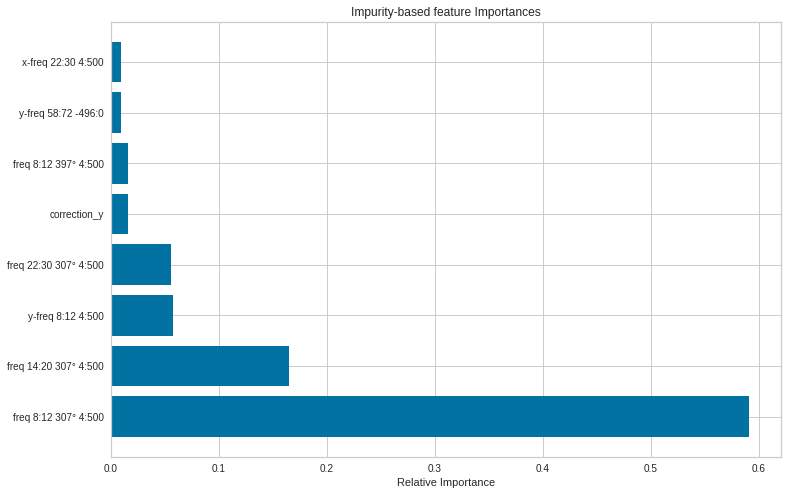

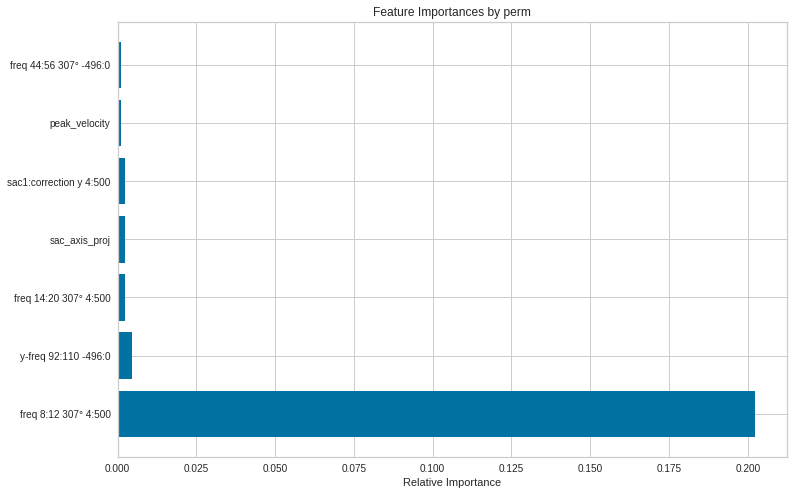

Rs:-0.01467660493980807,p=0.8082125856796791
acc:0.8875739644970414
1icms trials are NaN valid:82 (test group)
43 blank trials are NaN valid:43 (test group)


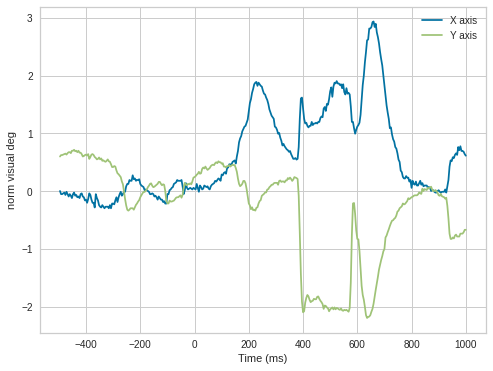

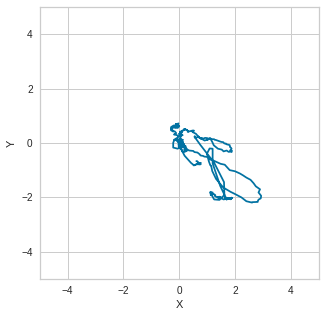

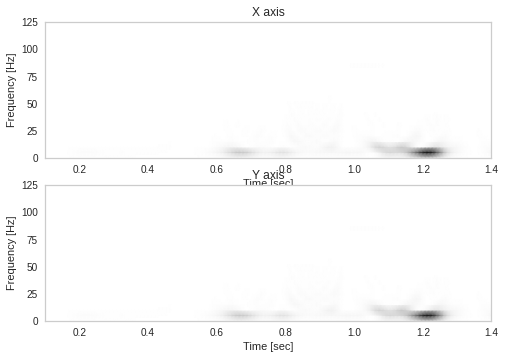

In [26]:
timeout_in_min=5
forest1 = random_forest(data_class,all_trials='sac2RF')
forest1.timeout = 60*timeout_in_min
forest1.optimize()

In [41]:
timeout_in_min=7
forest1 = random_forest(data_class,all_trials='sac2RF')
forest1.timeout = 60*timeout_in_min
forest1.optimize()
forest2 = random_forest(data_class,all_trials='no sac2RF')
forest2.timeout = 60*timeout_in_min
forest2.optimize()

forest3 = random_forest(data_class)
forest3.timeout = 60*timeout_in_min
forest3.optimize()



338 icms trials were taken.
338 blank trials were taken.
a


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars



a
a
['nsac', 'sac1:onset', 'sac1:offset', 'sac1:peak_velocity', 'sac1:dx', 'sac1:dy', 'sac1:max_amp x', 'sac1:max_amp y', 'sac1:max_amp', 'sac1:deg', 'sac1:correction x', 'sac1:correction y', 'sac2:onset', 'sac2:offset', 'sac2:peak_velocity', 'sac2:dx', 'sac2:dy', 'sac2:max_amp x', 'sac2:max_amp y', 'sac2:max_amp', 'sac2:deg', 'sac2:correction x', 'sac2:correction y', 'sac3:onset', 'sac3:offset', 'sac3:peak_velocity', 'sac3:dx', 'sac3:dy', 'sac3:max_amp x', 'sac3:max_amp y', 'sac3:max_amp', 'sac3:deg', 'sac3:correction x', 'sac3:correction y', 'sac4:onset', 'sac4:offset', 'sac4:peak_velocity', 'sac4:dx', 'sac4:dy', 'sac4:max_amp x', 'sac4:max_amp y', 'sac4:max_amp', 'sac4:deg', 'sac4:correction x', 'sac4:correction y', 'sac5:onset', 'sac5:offset', 'sac5:peak_velocity', 'sac5:dx', 'sac5:dy', 'sac5:max_amp x', 'sac5:max_amp y', 'sac5:max_amp', 'sac5:deg', 'sac5:correction x', 'sac5:correction y', 'sac6:onset', 'sac6:offset', 'sac6:peak_velocity', 'sac6:dx', 'sac6:dy', 'sac6:max_amp x', '

,x-max_change -496:0,x-max_change 4:500,x-max_change 504:1000,y-max_change -496:0,y-max_change 4:500,y-max_change 504:1000,traj -496:0,traj 4:500,traj 504:1000,x-freq 8:12 -496:0,x-freq 14:20 -496:0,x-freq 22:30 -496:0,x-freq 32:42 -496:0,x-freq 44:56 -496:0,x-freq 58:72 -496:0,x-freq 74:90 -496:0,x-freq 92:110 -496:0,x-freq 112:126 -496:0,x-freq 8:12 4:500,x-freq 14:20 4:500,x-freq 22:30 4:500,x-freq 32:42 4:500,x-freq 44:56 4:500,x-freq 58:72 4:500,x-freq 74:90 4:500,x-freq 92:110 4:500,x-freq 112:126 4:500,x-freq 8:12 504:1000,x-freq 14:20 504:1000,x-freq 22:30 504:1000,x-freq 32:42 504:1000,x-freq 44:56 504:1000,x-freq 58:72 504:1000,x-freq 74:90 504:1000,x-freq 92:110 504:1000,x-freq 112:126 504:1000,y-freq 8:12 -496:0,y-freq 14:20 -496:0,y-freq 22:30 -496:0,y-freq 32:42 -496:0,...,sac4:max_amp 504:1000,sac4:deg 504:1000,sac4:correction x 504:1000,sac4:correction y 504:1000,sac5:onset 504:1000,sac5:offset 504:1000,sac5:peak_velocity 504:1000,sac5:dx 504:1000,sac5:dy 504:1000,sac5:max_amp x 504:1000,sac5:max_amp y 504:1000,sac5:max_amp 504:1000,sac5:deg 504:1000,sac5:correction x 504:1000,sac5:correction y 504:1000,sac6:onset 504:1000,sac6:offset 504:1000,sac6:peak_velocity 504:1000,sac6:dx 504:1000,sac6:dy 504:1000,sac6:max_amp x 504:1000,sac6:max_amp y 504:1000,sac6:max_amp 504:1000,sac6:deg 504:1000,sac6:correction x 504:1000,sac6:correction y 504:1000,traj_wo_sacc -496:0,traj_wo_sacc 4:500,traj_wo_sacc 504:1000,max_amp,deg,peak_velocity,correction_x,correction_y,sac_axis_proj,orth_axis_proj,latency,icms,sac2RF,time_from_last_sac
0,0.638793,0.951393,1.046533,0.680345,0.672048,0.962440,0.041780,0.044814,0.051068,0.000437,0.000243,0.000267,0.000078,0.000445,0.000846,0.000706,0.000829,0.001552,0.000334,0.000050,0.000176,0.000401,0.000238,0.000230,0.000922,0.000518,0.000538,0.012108,0.004764,0.002377,0.000980,0.000894,0.000378,0.000376,0.000522,0.000389,0.000551,0.000055,0.000190,0.000137,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040357,0.039811,0.047491,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,-100000.0
1,0.637097,0.406658,0.501545,0.758908,0.287465,0.321961,0.060254,0.050814,0.052422,0.002252,0.000456,0.001603,0.001108,0.001427,0.000367,0.000783,0.000947,0.001609,0.001248,0.000501,0.000224,0.000333,0.000736,0.000427,0.000648,0.001361,0.001272,0.000623,0.000158,0.000354,0.000157,0.000185,0.001077,0.000421,0.001202,0.000350,0.006717,0.004255,0.004734,0.001032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.056596,0.050408,0.052003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,-364.0
2,1.109824,1.039730,1.203283,1.437826,0.992564,0.742104,0.051963,0.037634,0.039516,0.008024,0.003079,0.000443,0.000312,0.000386,0.000282,0.000671,0.000590,0.000355,0.002163,0.000457,0.000176,0.000197,0.000198,0.000247,0.000234,0.000570,0.000282,0.003216,0.000331,0.000266,0.000446,0.000868,0.000320,0.000351,0.000513,0.000677,0.003248,0.000800,0.000124,0.000101,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052142,0.037446,0.039200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,-4.0
3,0.541661,1.751756,1.532787,0.466845,1.728145,0.868168,0.045770,0.075227,0.059201,0.001063,0.000589,0.000727,0.000929,0.000593,0.000252,0.000948,0.000448,0.000736,0.052980,0.019050,0.009128,0.005824,0.002430,0.000790,0.000462,0.000938,0.000491,0.023699,0.001151,0.001949,0.001399,0.000970,0.000627,0.000504,0.000762,0.001077,0.000741,0.001078,0.002009,0.001293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045403,0.076845,0.054931,1.443448,-52.064087,135.908576,-0.299642,2.435362,1.443256,-0.023577,216.0,1.0,1.0,-100000.0
4,0.399894,1.087711,0.687818,0.235778,1.170160,0.689870,0.046822,0.066847,0.058208,0.001841,0.002331,0.001248

[I 2022-02-06 11:28:09,155] A new study created in memory with name: random forest optimization
[I 2022-02-06 11:28:15,315] Trial 0 finished with value: 0.9289652494661231 and parameters: {'max_samples': 0.5336176037620592, 'n_estimators': 363, 'min_samples_split': 3, 'max_depth': 6, 'max_features': 0.14675589081711304, 'k_features_select': 72}. Best is trial 0 with value: 0.9289652494661231.
[I 2022-02-06 11:28:19,127] Trial 1 finished with value: 0.9289652494661231 and parameters: {'max_samples': 0.3490081691021367, 'n_estimators': 179, 'min_samples_split': 9, 'max_depth': 8, 'max_features': 0.4191945144032948, 'k_features_select': 219}. Best is trial 0 with value: 0.9289652494661231.


KeyboardInterrupt: ignored

338 icms trials were taken.
338 blank trials were taken.
a


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars



a
a
['nsac', 'sac1:onset', 'sac1:offset', 'sac1:peak_velocity', 'sac1:dx', 'sac1:dy', 'sac1:max_amp x', 'sac1:max_amp y', 'sac1:max_amp', 'sac1:deg', 'sac1:correction x', 'sac1:correction y', 'sac2:onset', 'sac2:offset', 'sac2:peak_velocity', 'sac2:dx', 'sac2:dy', 'sac2:max_amp x', 'sac2:max_amp y', 'sac2:max_amp', 'sac2:deg', 'sac2:correction x', 'sac2:correction y', 'sac3:onset', 'sac3:offset', 'sac3:peak_velocity', 'sac3:dx', 'sac3:dy', 'sac3:max_amp x', 'sac3:max_amp y', 'sac3:max_amp', 'sac3:deg', 'sac3:correction x', 'sac3:correction y', 'sac4:onset', 'sac4:offset', 'sac4:peak_velocity', 'sac4:dx', 'sac4:dy', 'sac4:max_amp x', 'sac4:max_amp y', 'sac4:max_amp', 'sac4:deg', 'sac4:correction x', 'sac4:correction y', 'sac5:onset', 'sac5:offset', 'sac5:peak_velocity', 'sac5:dx', 'sac5:dy', 'sac5:max_amp x', 'sac5:max_amp y', 'sac5:max_amp', 'sac5:deg', 'sac5:correction x', 'sac5:correction y', 'sac6:onset', 'sac6:offset', 'sac6:peak_velocity', 'sac6:dx', 'sac6:dy', 'sac6:max_amp x', '

,x-max_change -496:0,x-max_change 4:500,x-max_change 504:1000,y-max_change -496:0,y-max_change 4:500,y-max_change 504:1000,traj -496:0,traj 4:500,traj 504:1000,x-freq 8:12 -496:0,x-freq 14:20 -496:0,x-freq 22:30 -496:0,x-freq 32:42 -496:0,x-freq 44:56 -496:0,x-freq 58:72 -496:0,x-freq 74:90 -496:0,x-freq 92:110 -496:0,x-freq 112:126 -496:0,x-freq 8:12 4:500,x-freq 14:20 4:500,x-freq 22:30 4:500,x-freq 32:42 4:500,x-freq 44:56 4:500,x-freq 58:72 4:500,x-freq 74:90 4:500,x-freq 92:110 4:500,x-freq 112:126 4:500,x-freq 8:12 504:1000,x-freq 14:20 504:1000,x-freq 22:30 504:1000,x-freq 32:42 504:1000,x-freq 44:56 504:1000,x-freq 58:72 504:1000,x-freq 74:90 504:1000,x-freq 92:110 504:1000,x-freq 112:126 504:1000,y-freq 8:12 -496:0,y-freq 14:20 -496:0,y-freq 22:30 -496:0,y-freq 32:42 -496:0,...,sac4:max_amp 504:1000,sac4:deg 504:1000,sac4:correction x 504:1000,sac4:correction y 504:1000,sac5:onset 504:1000,sac5:offset 504:1000,sac5:peak_velocity 504:1000,sac5:dx 504:1000,sac5:dy 504:1000,sac5:max_amp x 504:1000,sac5:max_amp y 504:1000,sac5:max_amp 504:1000,sac5:deg 504:1000,sac5:correction x 504:1000,sac5:correction y 504:1000,sac6:onset 504:1000,sac6:offset 504:1000,sac6:peak_velocity 504:1000,sac6:dx 504:1000,sac6:dy 504:1000,sac6:max_amp x 504:1000,sac6:max_amp y 504:1000,sac6:max_amp 504:1000,sac6:deg 504:1000,sac6:correction x 504:1000,sac6:correction y 504:1000,traj_wo_sacc -496:0,traj_wo_sacc 4:500,traj_wo_sacc 504:1000,max_amp,deg,peak_velocity,correction_x,correction_y,sac_axis_proj,orth_axis_proj,latency,icms,sac2RF,time_from_last_sac
0,0.233835,0.280602,0.233835,0.360050,0.803189,0.595467,0.051142,0.053468,0.045949,0.000104,0.000099,0.000092,0.000515,0.000322,0.000300,0.000619,0.000838,0.001873,0.000447,0.000479,0.000255,0.000335,0.000567,0.000413,0.000376,0.000493,0.000175,0.000102,0.000092,0.000122,0.000263,0.000124,0.000308,0.000327,0.000313,0.001079,0.000359,0.000266,0.000520,0.000311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050733,0.047611,0.045581,0.215790,105.718126,33.611760,-0.105226,-0.501597,-0.201075,-0.078323,120.0,0.0,0.0,-100000.0
1,0.645384,0.230494,0.426414,0.401323,0.155615,0.180186,0.040199,0.034245,0.034629,0.002263,0.002446,0.001048,0.000386,0.000133,0.000157,0.000206,0.000449,0.000343,0.000365,0.000083,0.000047,0.000377,0.000187,0.000403,0.000464,0.000364,0.001104,0.000312,0.000176,0.000331,0.000156,0.000204,0.000356,0.000352,0.000667,0.000536,0.001503,0.002458,0.001397,0.000461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035191,0.033971,0.034352,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,-356.0
2,0.401793,0.388400,0.334827,0.207698,0.218083,0.550399,0.040349,0.044861,0.047685,0.000297,0.000217,0.000206,0.000129,0.000433,0.000391,0.000495,0.000350,0.000613,0.000113,0.000340,0.000315,0.000369,0.000372,0.000436,0.000630,0.001097,0.000811,0.000263,0.001056,0.001184,0.001052,0.000992,0.000258,0.000616,0.000456,0.000380,0.000109,0.000134,0.000287,0.000203,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040026,0.044502,0.047304,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,-100000.0
3,0.268694,0.806082,0.280377,0.157697,0.593683,0.139144,0.038617,0.047889,0.036505,0.000261,0.000178,0.000136,0.000170,0.000214,0.000505,0.000477,0.000362,0.000272,0.009137,0.004932,0.003937,0.001519,0.001412,0.000557,0.000280,0.000226,0.000814,0.000776,0.000144,0.000125,0.000090,0.000353,0.000297,0.000668,0.000323,0.000333,0.000219,0.000061,0.000104,0.000167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038308,0.047000,0.036213,0.677492,-30.438154,50.890402,0.175235,0.843854,0.625641,-0.259940,76.0,1.0,1.0,-100000.0
4,0.437939,0.679958,0.414890,0.171995,0.262088,0.212947,0.035496,0.037476,0.036382,0.000297,0.0001

[I 2022-02-06 22:39:03,886] A new study created in memory with name: random forest optimization
[I 2022-02-06 22:39:11,581] Trial 0 finished with value: 0.9447680062123858 and parameters: {'max_samples': 0.5336176037620592, 'n_estimators': 363, 'min_samples_split': 3, 'max_depth': 6, 'max_features': 0.14675589081711304, 'k_features_select': 72}. Best is trial 0 with value: 0.9447680062123858.
[I 2022-02-06 22:39:15,784] Trial 1 finished with value: 0.942787808192584 and parameters: {'max_samples': 0.3490081691021367, 'n_estimators': 179, 'min_samples_split': 9, 'max_depth': 8, 'max_features': 0.4191945144032948, 'k_features_select': 219}. Best is trial 0 with value: 0.9447680062123858.
[I 2022-02-06 22:39:24,900] Trial 2 finished with value: 0.942787808192584 and parameters: {'max_samples': 0.36356179978521397, 'n_estimators': 441, 'min_samples_split': 3, 'max_depth': 9, 'max_features': 0.41730480236712697, 'k_features_select': 187}. Best is trial 0 with value: 0.9447680062123858.
[I 2

best params{'max_samples': 0.36809878163184695, 'n_estimators': 128, 'min_samples_split': 6, 'max_depth': 8, 'max_features': 0.5731900546788306, 'k_features_select': 63}
best cv value0.9507086002717919
score on test set with 1 model training 0.5799


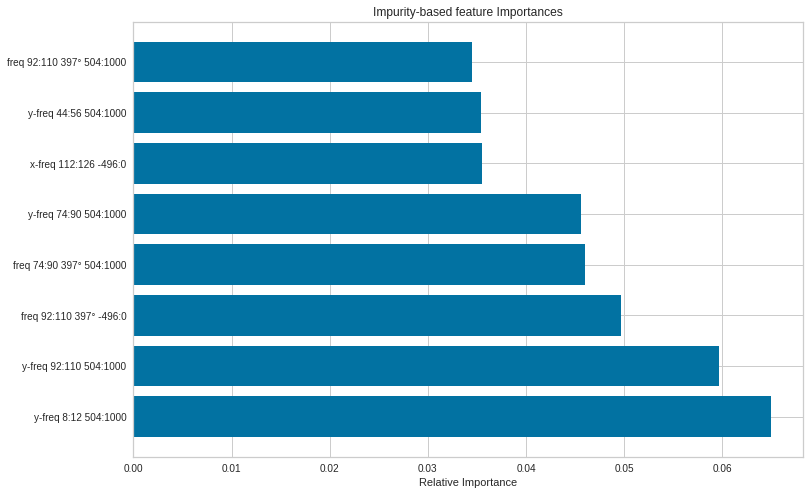

acc:0.5798816568047337
0icms trials are NaN valid:77 (test group)
44 blank trials are NaN valid:48 (test group)


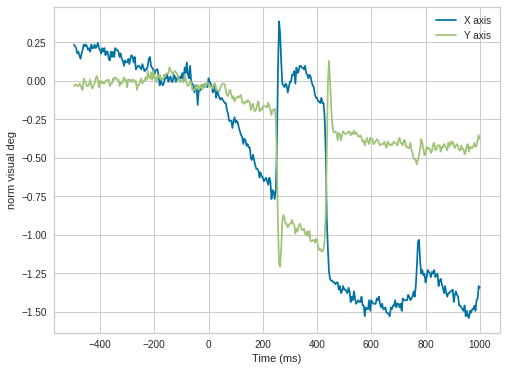

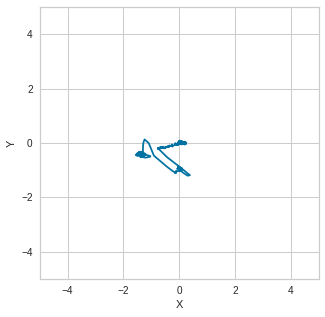

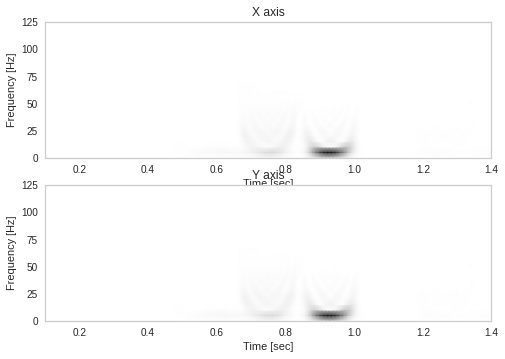

365 icms trials were taken.
365 blank trials were taken.
a


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars



a
a
['nsac', 'sac1:onset', 'sac1:offset', 'sac1:peak_velocity', 'sac1:dx', 'sac1:dy', 'sac1:max_amp x', 'sac1:max_amp y', 'sac1:max_amp', 'sac1:deg', 'sac1:correction x', 'sac1:correction y', 'sac2:onset', 'sac2:offset', 'sac2:peak_velocity', 'sac2:dx', 'sac2:dy', 'sac2:max_amp x', 'sac2:max_amp y', 'sac2:max_amp', 'sac2:deg', 'sac2:correction x', 'sac2:correction y', 'sac3:onset', 'sac3:offset', 'sac3:peak_velocity', 'sac3:dx', 'sac3:dy', 'sac3:max_amp x', 'sac3:max_amp y', 'sac3:max_amp', 'sac3:deg', 'sac3:correction x', 'sac3:correction y', 'sac4:onset', 'sac4:offset', 'sac4:peak_velocity', 'sac4:dx', 'sac4:dy', 'sac4:max_amp x', 'sac4:max_amp y', 'sac4:max_amp', 'sac4:deg', 'sac4:correction x', 'sac4:correction y', 'sac5:onset', 'sac5:offset', 'sac5:peak_velocity', 'sac5:dx', 'sac5:dy', 'sac5:max_amp x', 'sac5:max_amp y', 'sac5:max_amp', 'sac5:deg', 'sac5:correction x', 'sac5:correction y', 'sac6:onset', 'sac6:offset', 'sac6:peak_velocity', 'sac6:dx', 'sac6:dy', 'sac6:max_amp x', '

,x-max_change -496:0,x-max_change 4:500,x-max_change 504:1000,y-max_change -496:0,y-max_change 4:500,y-max_change 504:1000,traj -496:0,traj 4:500,traj 504:1000,x-freq 8:12 -496:0,x-freq 14:20 -496:0,x-freq 22:30 -496:0,x-freq 32:42 -496:0,x-freq 44:56 -496:0,x-freq 58:72 -496:0,x-freq 74:90 -496:0,x-freq 92:110 -496:0,x-freq 112:126 -496:0,x-freq 8:12 4:500,x-freq 14:20 4:500,x-freq 22:30 4:500,x-freq 32:42 4:500,x-freq 44:56 4:500,x-freq 58:72 4:500,x-freq 74:90 4:500,x-freq 92:110 4:500,x-freq 112:126 4:500,x-freq 8:12 504:1000,x-freq 14:20 504:1000,x-freq 22:30 504:1000,x-freq 32:42 504:1000,x-freq 44:56 504:1000,x-freq 58:72 504:1000,x-freq 74:90 504:1000,x-freq 92:110 504:1000,x-freq 112:126 504:1000,y-freq 8:12 -496:0,y-freq 14:20 -496:0,y-freq 22:30 -496:0,y-freq 32:42 -496:0,...,sac4:max_amp 504:1000,sac4:deg 504:1000,sac4:correction x 504:1000,sac4:correction y 504:1000,sac5:onset 504:1000,sac5:offset 504:1000,sac5:peak_velocity 504:1000,sac5:dx 504:1000,sac5:dy 504:1000,sac5:max_amp x 504:1000,sac5:max_amp y 504:1000,sac5:max_amp 504:1000,sac5:deg 504:1000,sac5:correction x 504:1000,sac5:correction y 504:1000,sac6:onset 504:1000,sac6:offset 504:1000,sac6:peak_velocity 504:1000,sac6:dx 504:1000,sac6:dy 504:1000,sac6:max_amp x 504:1000,sac6:max_amp y 504:1000,sac6:max_amp 504:1000,sac6:deg 504:1000,sac6:correction x 504:1000,sac6:correction y 504:1000,traj_wo_sacc -496:0,traj_wo_sacc 4:500,traj_wo_sacc 504:1000,max_amp,deg,peak_velocity,correction_x,correction_y,sac_axis_proj,orth_axis_proj,latency,icms,sac2RF,time_from_last_sac
0,0.698901,0.404627,0.895084,0.817545,0.370845,0.505698,0.062676,0.052486,0.062545,0.001323,0.001174,0.003339,0.002925,0.001130,0.001106,0.000402,0.000792,0.000281,0.001086,0.000310,0.000239,0.000108,0.000241,0.000445,0.000914,0.000528,0.000517,0.002498,0.000431,0.000954,0.002099,0.001484,0.000956,0.000663,0.000785,0.000541,0.004979,0.006634,0.005090,0.002252,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.054666,0.049643,0.056026,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,-136.0
1,0.338881,0.379547,1.545300,0.344958,0.218474,0.827900,0.047365,0.045823,0.045747,0.000278,0.000165,0.000080,0.000206,0.000367,0.000529,0.000979,0.000781,0.000910,0.001022,0.000176,0.000417,0.000178,0.000348,0.000495,0.000346,0.000789,0.000749,0.005851,0.000279,0.000289,0.000147,0.000274,0.000372,0.000424,0.000710,0.000583,0.000303,0.000068,0.000522,0.000213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046986,0.045456,0.047963,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,-100000.0
2,0.334827,0.776799,0.843765,0.488090,0.186928,0.321932,0.047607,0.042362,0.041555,0.001060,0.000572,0.000700,0.000325,0.000349,0.000486,0.000378,0.000497,0.000402,0.000909,0.000055,0.000084,0.000186,0.000205,0.000644,0.000296,0.000380,0.001530,0.000476,0.000143,0.000087,0.000179,0.000121,0.000586,0.000477,0.000536,0.000311,0.001534,0.001984,0.002264,0.001100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047226,0.042023,0.041223,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,-100000.0
3,0.334217,0.322692,0.184395,0.171995,0.147425,0.204757,0.040322,0.035055,0.031965,0.000585,0.000095,0.000374,0.000207,0.000324,0.000376,0.000747,0.000599,0.000776,0.000186,0.000098,0.000265,0.000149,0.000137,0.000280,0.000273,0.000879,0.000097,0.000285,0.000167,0.000201,0.000136,0.000223,0.000209,0.000236,0.000292,0.000435,0.000084,0.000081,0.000746,0.000262,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040000,0.034775,0.031709,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,-100000.0
4,0.467670,0.198760,0.245527,0.387746,0.443139,0.387746,0.049580,0.053341,0.049534,0.000320,0.000290,0.000214,0.

[I 2022-02-06 23:13:35,710] A new study created in memory with name: random forest optimization
[I 2022-02-06 23:13:43,923] Trial 0 finished with value: 0.5832360300250208 and parameters: {'max_samples': 0.5336176037620592, 'n_estimators': 363, 'min_samples_split': 3, 'max_depth': 6, 'max_features': 0.14675589081711304, 'k_features_select': 72}. Best is trial 0 with value: 0.5832360300250208.
[I 2022-02-06 23:13:49,613] Trial 1 finished with value: 0.5722602168473727 and parameters: {'max_samples': 0.3490081691021367, 'n_estimators': 179, 'min_samples_split': 9, 'max_depth': 8, 'max_features': 0.4191945144032948, 'k_features_select': 219}. Best is trial 0 with value: 0.5832360300250208.
[I 2022-02-06 23:14:02,430] Trial 2 finished with value: 0.5850375312760635 and parameters: {'max_samples': 0.36356179978521397, 'n_estimators': 441, 'min_samples_split': 3, 'max_depth': 9, 'max_features': 0.41730480236712697, 'k_features_select': 187}. Best is trial 2 with value: 0.5850375312760635.
[I

best params{'max_samples': 0.97038412028836, 'n_estimators': 409, 'min_samples_split': 15, 'max_depth': 5, 'max_features': 0.8371337239064516, 'k_features_select': 151}
best cv value0.6162468723936614
score on test set with 1 model training 0.5628


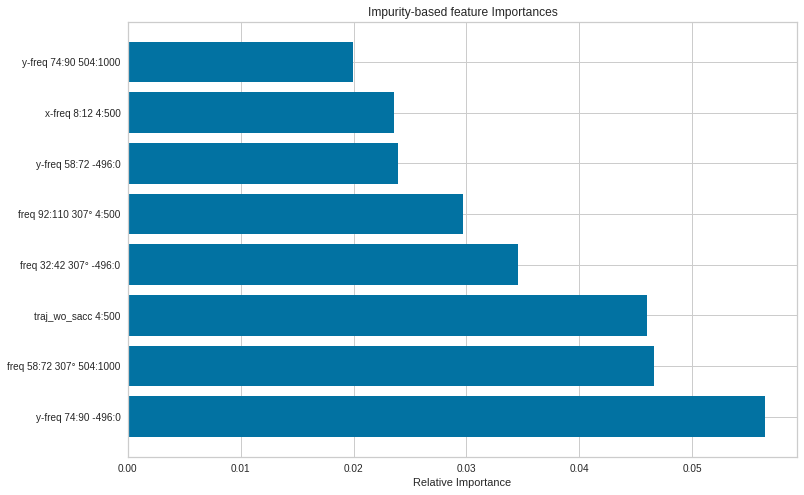

acc:0.5628415300546448
45icms trials are NaN valid:42 (test group)
50 blank trials are NaN valid:46 (test group)


a


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars



a
a
['nsac', 'sac1:onset', 'sac1:offset', 'sac1:peak_velocity', 'sac1:dx', 'sac1:dy', 'sac1:max_amp x', 'sac1:max_amp y', 'sac1:max_amp', 'sac1:deg', 'sac1:correction x', 'sac1:correction y', 'sac2:onset', 'sac2:offset', 'sac2:peak_velocity', 'sac2:dx', 'sac2:dy', 'sac2:max_amp x', 'sac2:max_amp y', 'sac2:max_amp', 'sac2:deg', 'sac2:correction x', 'sac2:correction y', 'sac3:onset', 'sac3:offset', 'sac3:peak_velocity', 'sac3:dx', 'sac3:dy', 'sac3:max_amp x', 'sac3:max_amp y', 'sac3:max_amp', 'sac3:deg', 'sac3:correction x', 'sac3:correction y', 'sac4:onset', 'sac4:offset', 'sac4:peak_velocity', 'sac4:dx', 'sac4:dy', 'sac4:max_amp x', 'sac4:max_amp y', 'sac4:max_amp', 'sac4:deg', 'sac4:correction x', 'sac4:correction y', 'sac5:onset', 'sac5:offset', 'sac5:peak_velocity', 'sac5:dx', 'sac5:dy', 'sac5:max_amp x', 'sac5:max_amp y', 'sac5:max_amp', 'sac5:deg', 'sac5:correction x', 'sac5:correction y', 'sac6:onset', 'sac6:offset', 'sac6:peak_velocity', 'sac6:dx', 'sac6:dy', 'sac6:max_amp x', '

,x-max_change -496:0,x-max_change 4:500,x-max_change 504:1000,y-max_change -496:0,y-max_change 4:500,y-max_change 504:1000,traj -496:0,traj 4:500,traj 504:1000,x-freq 8:12 -496:0,x-freq 14:20 -496:0,x-freq 22:30 -496:0,x-freq 32:42 -496:0,x-freq 44:56 -496:0,x-freq 58:72 -496:0,x-freq 74:90 -496:0,x-freq 92:110 -496:0,x-freq 112:126 -496:0,x-freq 8:12 4:500,x-freq 14:20 4:500,x-freq 22:30 4:500,x-freq 32:42 4:500,x-freq 44:56 4:500,x-freq 58:72 4:500,x-freq 74:90 4:500,x-freq 92:110 4:500,x-freq 112:126 4:500,x-freq 8:12 504:1000,x-freq 14:20 504:1000,x-freq 22:30 504:1000,x-freq 32:42 504:1000,x-freq 44:56 504:1000,x-freq 58:72 504:1000,x-freq 74:90 504:1000,x-freq 92:110 504:1000,x-freq 112:126 504:1000,y-freq 8:12 -496:0,y-freq 14:20 -496:0,y-freq 22:30 -496:0,y-freq 32:42 -496:0,...,sac4:max_amp 504:1000,sac4:deg 504:1000,sac4:correction x 504:1000,sac4:correction y 504:1000,sac5:onset 504:1000,sac5:offset 504:1000,sac5:peak_velocity 504:1000,sac5:dx 504:1000,sac5:dy 504:1000,sac5:max_amp x 504:1000,sac5:max_amp y 504:1000,sac5:max_amp 504:1000,sac5:deg 504:1000,sac5:correction x 504:1000,sac5:correction y 504:1000,sac6:onset 504:1000,sac6:offset 504:1000,sac6:peak_velocity 504:1000,sac6:dx 504:1000,sac6:dy 504:1000,sac6:max_amp x 504:1000,sac6:max_amp y 504:1000,sac6:max_amp 504:1000,sac6:deg 504:1000,sac6:correction x 504:1000,sac6:correction y 504:1000,traj_wo_sacc -496:0,traj_wo_sacc 4:500,traj_wo_sacc 504:1000,max_amp,deg,peak_velocity,correction_x,correction_y,sac_axis_proj,orth_axis_proj,latency,icms,sac2RF,time_from_last_sac
0,0.420213,0.311771,0.609987,0.218474,0.310462,0.367956,0.046318,0.049820,0.048844,0.000325,0.000162,0.000185,0.000272,0.000573,0.000360,0.000320,0.000459,0.000778,0.000533,0.000292,0.000214,0.000359,0.000358,0.000446,0.001188,0.001042,0.000791,0.004787,0.002750,0.001532,0.002849,0.002579,0.000452,0.000668,0.000432,0.000350,0.000162,0.000123,0.000590,0.000247,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045948,0.049421,0.046656,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,-100000.0
1,0.352437,0.609987,0.487989,0.356457,0.379454,0.873894,0.051624,0.050119,0.062634,0.000188,0.000302,0.000352,0.000313,0.000506,0.001129,0.001005,0.000629,0.002163,0.000600,0.000332,0.000447,0.000642,0.000674,0.000170,0.000589,0.000694,0.000621,0.001188,0.002005,0.001640,0.002951,0.000603,0.000726,0.001501,0.000555,0.000549,0.000069,0.000089,0.000296,0.000357,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.051211,0.049718,0.052894,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,-100000.0
2,0.415890,0.399894,1.823516,0.200848,0.209581,0.681138,0.049282,0.038498,0.050475,0.000418,0.000264,0.000625,0.000304,0.000681,0.000758,0.000694,0.001022,0.000776,0.000166,0.000242,0.000288,0.000487,0.000487,0.000467,0.000708,0.000495,0.000557,0.003375,0.000319,0.000289,0.000250,0.000600,0.000585,0.000449,0.001258,0.000286,0.000073,0.000129,0.000268,0.000133,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.048888,0.038190,0.046823,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,-100000.0
3,1.375635,0.879767,0.559851,0.611278,0.358034,0.427894,0.049463,0.050204,0.054641,0.005384,0.000258,0.000510,0.000388,0.000473,0.000547,0.000892,0.000861,0.000732,0.000451,0.000266,0.001400,0.001474,0.000502,0.000637,0.000474,0.000640,0.000800,0.000678,0.000651,0.000321,0.000437,0.000391,0.001680,0.001061,0.002760,0.002034,0.000544,0.000100,0.000881,0.000389,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.049067,0.049802,0.054204,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,-100000.0
4,0.309152,0.241945,0.470448,0.145493,0.164892,0.378282,0.049412,0.047079,0.046325,0.000326,0.000074,0.000134

[I 2022-02-06 23:49:13,760] A new study created in memory with name: random forest optimization
[I 2022-02-06 23:49:24,276] Trial 0 finished with value: 0.7323943661971831 and parameters: {'max_samples': 0.5336176037620592, 'n_estimators': 363, 'min_samples_split': 3, 'max_depth': 6, 'max_features': 0.14675589081711304, 'k_features_select': 72}. Best is trial 0 with value: 0.7323943661971831.
[I 2022-02-06 23:49:33,229] Trial 1 finished with value: 0.7323943661971831 and parameters: {'max_samples': 0.3490081691021367, 'n_estimators': 179, 'min_samples_split': 9, 'max_depth': 8, 'max_features': 0.4191945144032948, 'k_features_select': 219}. Best is trial 0 with value: 0.7323943661971831.
[I 2022-02-06 23:49:54,824] Trial 2 finished with value: 0.7323943661971831 and parameters: {'max_samples': 0.36356179978521397, 'n_estimators': 441, 'min_samples_split': 3, 'max_depth': 9, 'max_features': 0.41730480236712697, 'k_features_select': 187}. Best is trial 0 with value: 0.7323943661971831.
[I

best params{'max_samples': 0.21451632441753196, 'n_estimators': 302, 'min_samples_split': 5, 'max_depth': 4, 'max_features': 0.23327139663871274, 'k_features_select': 152}
best cv value0.7370892018779344
score on test set with 1 model training 0.6152


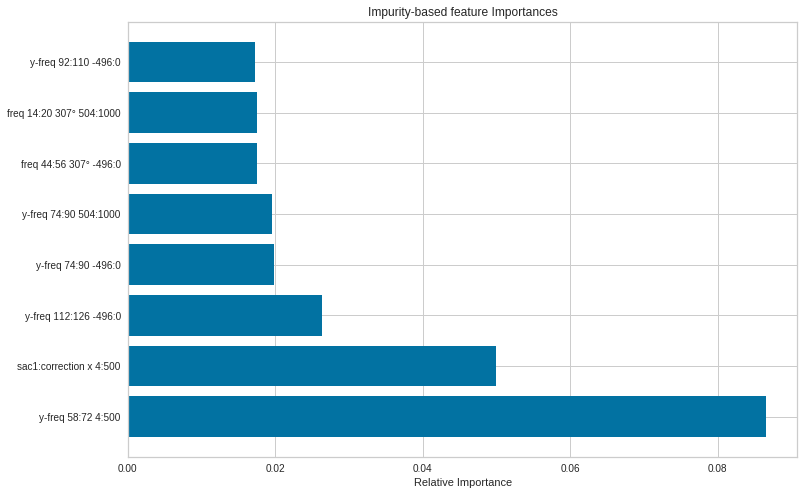

acc:0.6151685393258427
51icms trials are NaN valid:137 (test group)
84 blank trials are NaN valid:84 (test group)


In [22]:
timeout_in_min=33
forest1 = random_forest(data_class,all_trials='sac2RF')
forest1.timeout = 60*timeout_in_min
forest1.optimize()

forest2 = random_forest(data_class,all_trials='no sac2RF')
forest2.timeout = 60*timeout_in_min
forest2.optimize()

forest3 = random_forest(data_class)
forest3.timeout = 60*timeout_in_min
forest3.optimize()

In [ ]:
forest2 = random_forest(data_class,all_trials='no sac2RF')
forest2.timeout = 60*15
forest2.optimize()


In [ ]:

#df = create_feature_df(x,y,sac2RF)

X_df = select_features(df,y,method=1,k=study.best_params['k_features_select']*10)
y_df = np.ravel(pd.DataFrame(y.T,columns=['label']))
y_df = first_ms_dataset.find_first_ms(time_before_and_after_ms=time_before_and_after_ms,
                                             min_amp=0,ms_min_time_after_onset=100,ms_max_time_after_onset=400)
min_amp_for_polar=first_ms_dataset.min_amp_for_polar
#features =[i for i in df.columns if 'offset' not in i and 'onset' not in i ]
y_df['pred'] = dtree.predict(X_df )
y_df['correct'] = (y_df['icms']==y_df['pred'])
acc = (y_df['icms']==y_df['pred']).to_numpy().mean()
print(f'acc:{acc}')

n_icms = str(len(y_df.query('icms==1 and `max_amp`>'+min_amp_for_polar)))
n_no_icms = str(len(y_df.query('icms==0 and `max_amp`>'+min_amp_for_polar)))

'''
fig.add_trace(go.Scatterpolar(
      name = "icms N:"+n_icms,
      r =first_ms_df.query('icms==1 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['max_amp'],
      theta = first_ms_df.query('icms==1 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['deg'],
      thetaunit = "degrees",
      #fill='toself',
      mode = 'markers',
    ), 1, 1)
fig.add_trace(go.Scatterpolar(
      name = "no icms N:"+n_no_icms,
      r = first_ms_df.query('icms==0 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['max_amp'],
      theta = first_ms_df.query('icms==0 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['deg'],
      thetaunit = "degrees",
      #fill='toself',
      mode = 'markers',
    ), 1, 2)

fig.show()
'''
polar_title = 'first ms ('+str(first_ms_dataset.ms_min_time_after_onset)+':'+str(first_ms_dataset.ms_max_time_after_onset)+' after onset .min of max ms amp is '+first_ms_dataset.min_amp_for_polar +')' 
fig = plotly.subplots.make_subplots(rows=1, cols=2,
                                    x_title=polar_title,
                                    specs=[[{'type': 'polar'}]*2])
n_correct_ = str(len(y_df.query('sac2RF==1 and correct==1 and `max_amp`>'+min_amp_for_polar)))
n_wrong_ = str(len(y_df.query('sac2RF==1 and correct==0 and `max_amp`>'+min_amp_for_polar)))
n_correct_no_ = str(len(y_df.query('sac2RF==0 and correct==1 and icms==1 and `max_amp`>'+min_amp_for_polar)))
n_wrong_no_ = str(len(y_df.query('sac2RF==0 and correct==0 and icms==1 and `max_amp`>'+min_amp_for_polar)))

fig.add_trace(go.Scatterpolar(
      name = "correct sac2rf N:"+n_correct_,
      r =y_df.query('sac2RF==1 and correct==1 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['max_amp'],
      theta = y_df.query('sac2RF==1 and correct==1 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['deg'],
      thetaunit = "degrees",      marker_symbol='circle',      marker_color='blue',      mode = 'markers',
    ), 1, 1)
fig.add_trace(go.Scatterpolar(
      name = "wrong sac2rf N:"+n_wrong_,
      r =y_df.query('sac2RF==1 and correct==0 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['max_amp'],
      theta = y_df.query('sac2RF==1 and correct==0 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['deg'],
      thetaunit = "degrees",      marker_symbol='cross-open',      marker_color='blue',     mode = 'markers',
    ), 1, 1)
fig.add_trace(go.Scatterpolar(
      name = "correct no sac2rf N:"+n_correct_no_,
      r = y_df.query('sac2RF==0 and correct==1 and icms==1 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['max_amp'],
      theta = y_df.query('sac2RF==0 and correct==1 and icms==1 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['deg'],
      thetaunit = "degrees",
      marker_symbol='circle',
      marker_color='red',
      #fill='toself',
      mode = 'markers',
    ), 1, 2)
fig.add_trace(go.Scatterpolar(
      name = "wrong no sac2rf N:"+n_wrong_no_,
      r = y_df.query('sac2RF==0 and correct==0 and icms==1 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['max_amp'],
      theta = y_df.query('sac2RF==0 and correct==0 and icms==1 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['deg'],
      thetaunit = "degrees",
      marker_symbol='cross-open',
      marker_color='red',
      #fill='toself',
      mode = 'markers',
    ), 1, 2)

fig.show()
n_correct_blank = str(len(y_df.query('icms==0 and correct==1 and `max_amp`>'+min_amp_for_polar)))
n_wrong_blank = str(len(y_df.query('icms==0 and correct==0 and `max_amp`>'+min_amp_for_polar)))

fig = plotly.subplots.make_subplots(rows=1, cols=1,
                                    x_title=polar_title,
                                    specs=[[{'type': 'polar'}]*1])
fig.add_trace(go.Scatterpolar(
      name = "correct blank N:"+n_correct_blank,
      r = y_df.query(' correct==1 and icms==0 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['max_amp'],
      theta = y_df.query(' correct==1 and icms==0 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['deg'],
      thetaunit = "degrees",
      marker_symbol='circle',
      marker_color='red',
      #fill='toself',
      mode = 'markers',
    ), 1, 1)
fig.add_trace(go.Scatterpolar(
      name = "wrong blank N:"+n_wrong_blank,
      r = y_df.query(' correct==0 and icms==0 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['max_amp'],
      theta = y_df.query(' correct==0 and icms==0 and `max_amp`>'+min_amp_for_polar).sort_values(by='deg')['deg'],
      thetaunit = "degrees",
      marker_symbol='cross-open',
      marker_color='red',
      #fill='toself',
      mode = 'markers',
    ), 1, 1)

fig.show()


In [ ]:
import joblib
joblib.dump(study,cd+'dtree_study.pkl')
plot_slice(study)

### without sac2rf trials

## powers


#### without bins seperation 

In [ ]:
freq_out = np.arange(0,126,2)
freq_groups  = [0]*11
cnt=0
brk=False
for i in range(11):
  cur_group = [freq_out[cnt]]
  cnt+=1
  for k in range(i):
    cur_group.append(freq_out[cnt])
    cnt+=1
    if cnt >= len(freq_out):
      brk=True
      break
  freq_groups[i]=cur_group
  if brk:
    print('a')
    break

freq_name =['freq '+str(cur_group[0])+':'+str(cur_group[-1]) for cur_group in freq_groups]

times = ['-500:-4','0:496','500:996']
fig = px.line(title='ICMS')

for cur_axis in ('x','y'):
    curr_data=np.zeros(len(freq_name))
    #curr_data = [df.iloc[np.where(y==0)].mean(axis=[cur_axis+'-'+cur_freq +' ' +cur_time  for cur_time in times]) for cur_freq in freq_name]
    for i,cur_freq in enumerate(freq_name):

      cur_col = [cur_axis+'-'+cur_freq +' ' +cur_time  for cur_time in times]
      all_data = df[cur_col].iloc[np.where(y==1)].mean(axis='columns')
      curr_data[i] = all_data.mean()
    fig = fig.add_trace(plotly.graph_objs.Scatter(x=[np.mean(cur_grp) for cur_grp in freq_groups],y=curr_data,name=cur_axis))
    fig.update_xaxes(title_text='Freq(Hz)',type='log')
    fig.update_yaxes(title_text='power')
fig.show()
fig = px.line(title='NO ICMS')
for cur_axis in ('x','y'):
    curr_data=np.zeros(len(freq_name))
    #curr_data = [df.iloc[np.where(y==0)].mean(axis=[cur_axis+'-'+cur_freq +' ' +cur_time  for cur_time in times]) for cur_freq in freq_name]
    for i,cur_freq in enumerate(freq_name):

      cur_col = [cur_axis+'-'+cur_freq +' ' +cur_time  for cur_time in times]
      all_data = df[cur_col].iloc[np.where(y==0)].mean(axis='columns')
      curr_data[i] = all_data.mean()
    fig = fig.add_trace(plotly.graph_objs.Scatter(x=[np.mean(cur_grp) for cur_grp in freq_groups],y=curr_data,name=cur_axis))
    fig.update_xaxes(title_text='Freq(Hz)',type='log')
    fig.update_yaxes(title_text='power')
fig.show()

a


KeyError: ignored

#### power density with f mul

In [ ]:
freq_out = np.arange(0,126,2)
freq_groups  = [0]*11
cnt=0
brk=False
for i in range(11):
  cur_group = [freq_out[cnt]]
  cnt+=1
  for k in range(i):
    cur_group.append(freq_out[cnt])
    cnt+=1
    if cnt >= len(freq_out):
      brk=True
      break
  freq_groups[i]=cur_group
  if brk:
    print('a')
    break

freq_name =['freq '+str(cur_group[0])+':'+str(cur_group[-1]) for cur_group in freq_groups]

times = ['-500:-4','0:496','500:996']
fig = px.line(title='ICMS')

for cur_time in times:
  for cur_axis in ('x','y'):
    curr_col = [cur_axis+'-'+cur_freq +' ' +cur_time for cur_freq in freq_name]
    curr_data = df[curr_col].iloc[np.where(y)].mean()
    fig = fig.add_trace(plotly.graph_objs.Scatter(x=[np.mean(cur_grp) for cur_grp in freq_groups] ,y=curr_data,name=cur_axis+' '+cur_time))
    fig.update_xaxes(title_text='Freq(Hz)')
    fig.update_yaxes(title_text='power')
fig.show()
fig = px.line(title='No ICMS')
for cur_time in times:
  for cur_axis in ('x','y'):
    curr_col = [cur_axis+'-'+cur_freq +' ' +cur_time for cur_freq in freq_name]
    curr_data = df[curr_col].iloc[np.where(y==0)].mean()
    fig = fig.add_trace(plotly.graph_objs.Scatter(x=[np.mean(cur_grp) for cur_grp in freq_groups],y=curr_data,name=cur_axis+' '+cur_time))
    fig.update_xaxes(title_text='Freq(Hz)')
    fig.update_yaxes(title_text='power')
fig.show()
freq_out = np.arange(0,126,2)
freq_groups  = [0]*11
cnt=0
brk=False
for i in range(11):
  cur_group = [freq_out[cnt]]
  cnt+=1
  for k in range(i):
    cur_group.append(freq_out[cnt])
    cnt+=1
    if cnt >= len(freq_out):
      brk=True
      break
  freq_groups[i]=cur_group
  if brk:
    print('a')
    break

freq_name =['freq '+str(cur_group[0])+':'+str(cur_group[-1]) for cur_group in freq_groups]

times = ['-500:-4','0:496','500:996']
fig = px.line(title='ICMS')

for cur_time in times:
  for cur_axis in ('x','y'):
    curr_col = [cur_axis+'-'+cur_freq +' ' +cur_time for cur_freq in freq_name]
    curr_data = df[curr_col].iloc[np.where(y)].mean()
    fig = fig.add_trace(plotly.graph_objs.Scatter(x=[np.mean(cur_grp) for cur_grp in freq_groups] ,y=curr_data,name=cur_axis+' '+cur_time))
    fig.update_xaxes(title_text='Freq(Hz)',type='log')
    fig.update_yaxes(title_text='power')
fig.show()
fig = px.line(title='No ICMS')
for cur_time in times:
  for cur_axis in ('x','y'):
    curr_col = [cur_axis+'-'+cur_freq +' ' +cur_time for cur_freq in freq_name]
    curr_data = df[curr_col].iloc[np.where(y==0)].mean()
    fig = fig.add_trace(plotly.graph_objs.Scatter(x=[np.mean(cur_grp) for cur_grp in freq_groups],y=curr_data,name=cur_axis+' '+cur_time))
    fig.update_xaxes(title_text='Freq(Hz)',type='log')
    fig.update_yaxes(title_text='power')
fig.show()

#### power density withot multipling f

In [ ]:
 freq_out = np.arange(0,126,2)
freq_groups  = [0]*11
cnt=0
brk=False
for i in range(11):
  cur_group = [freq_out[cnt]]
  cnt+=1
  for k in range(i):
    cur_group.append(freq_out[cnt])
    cnt+=1
    if cnt >= len(freq_out):
      brk=True
      break
  freq_groups[i]=cur_group
  if brk:
    print('a')
    break

freq_name =['freq '+str(cur_group[0])+':'+str(cur_group[-1]) for cur_group in freq_groups]

times = ['-500:-4','0:496','500:996']
fig = px.line(title='ICMS')

for cur_time in times:
  for cur_axis in ('x','y'):
    curr_col = [cur_axis+'-'+cur_freq +' ' +cur_time for cur_freq in freq_name]
    curr_data = df[curr_col].iloc[np.where(y)].mean()
    fig = fig.add_trace(plotly.graph_objs.Scatter(x=[np.mean(cur_grp) for cur_grp in freq_groups] ,y=curr_data,name=cur_axis+' '+cur_time))
    fig.update_xaxes(title_text='Freq(Hz)')
    fig.update_yaxes(title_text='power',type='log')
fig.show()
fig = px.line(title='No ICMS')
for cur_time in times:
  for cur_axis in ('x','y'):
    curr_col = [cur_axis+'-'+cur_freq +' ' +cur_time for cur_freq in freq_name]
    curr_data = df[curr_col].iloc[np.where(y==0)].mean()
    fig = fig.add_trace(plotly.graph_objs.Scatter(x=[np.mean(cur_grp) for cur_grp in freq_groups],y=curr_data,name=cur_axis+' '+cur_time))
    fig.update_xaxes(title_text='Freq(Hz)')
    fig.update_yaxes(title_text='power',type='log')
fig.show()

freq_out = np.arange(0,126,2)
freq_groups  = [0]*11
cnt=0
brk=False
for i in range(11):
  cur_group = [freq_out[cnt]]
  cnt+=1
  for k in range(i):
    cur_group.append(freq_out[cnt])
    cnt+=1
    if cnt >= len(freq_out):
      brk=True
      break
  freq_groups[i]=cur_group
  if brk:
    print('a')
    break

freq_name =['freq '+str(cur_group[0])+':'+str(cur_group[-1]) for cur_group in freq_groups]

times = ['-500:-4','0:496','500:996']
fig = px.line(title='ICMS')

for cur_time in times:
  for cur_axis in ('x','y'):
    curr_col = [cur_axis+'-'+cur_freq +' ' +cur_time for cur_freq in freq_name]
    curr_data = df[curr_col].iloc[np.where(y)].mean()
    fig = fig.add_trace(plotly.graph_objs.Scatter(x=[np.mean(cur_grp) for cur_grp in freq_groups] ,y=curr_data,name=cur_axis+' '+cur_time))
    fig.update_xaxes(title_text='Freq(Hz)',type='log')
    fig.update_yaxes(title_text='power',type='log')
fig.show()
fig = px.line(title='No ICMS')
for cur_time in times:
  for cur_axis in ('x','y'):
    curr_col = [cur_axis+'-'+cur_freq +' ' +cur_time for cur_freq in freq_name]
    curr_data = df[curr_col].iloc[np.where(y==0)].mean()
    fig = fig.add_trace(plotly.graph_objs.Scatter(x=[np.mean(cur_grp) for cur_grp in freq_groups],y=curr_data,name=cur_axis+' '+cur_time))
    fig.update_xaxes(title_text='Freq(Hz)',type='log')
    fig.update_yaxes(title_text='power',type='log')
fig.show()

In [ ]:
x,y, = scale_num_of_trials(x_wo_perm,y_wo_perm,_wo_perm,with_sac2rf=0,perm_any_call=True)
df = create_feature_df(x,y,)
#features = ['nsac','y max_change','x max_change']#df.columns

#rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
display(df)
features =[i for i in df.columns if 'offset' not in i and 'onset' not in i ]
X_df = df [features]
y_df = np.ravel(pd.DataFrame(y.T,columns=['label']))
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df,test_size=0.1, random_state=0,shuffle=True)

forest = True #if False, only 1 decision tree per training 
if forest:
  #best params{'max_samples': 0.5318790845337665, 'min_samples_split': 3, 'max_depth': 10, 
  #'max_features': 0.3835977951590856}
  #best cv value0.8077705827937095
  dtree = RandomForestClassifier(n_estimators=300, criterion='gini', max_depth=10,
                                 min_samples_split=3, min_samples_leaf=2, max_features=0.3835977951590856,
                                 max_leaf_nodes=None, min_impurity_decrease=0.01, min_impurity_split=None,
                                 bootstrap=True, max_samples=0.5318790845337665,
                                 n_jobs=-1, random_state=None, verbose= 0)
else:
  dtree = DecisionTreeClassifier(min_samples_split=8, min_samples_leaf=4, max_depth=6, max_features=0.7)
cv_score = cross_val_score(dtree, X_train, y_train, cv=10)
print(f'cross val scores:{cv_score} mean:{np.mean(cv_score)}')
dtree.fit(X_train,y_train)
#dtree=model
plot_feat_import(features,dtree.feature_importances_,thrs=6,title='Impurity based feature Importances')
print('score on test set with 1 model training %.4f'%(dtree.score(X_test, y_test)))
plot_feat_import(features,dtree.feature_importances_,thrs=0.007,title='Impurity based feature Importances')

perm_reapets=3
results = permutation_importance(dtree, X_df, y_df, n_repeats=perm_reapets,
                                 random_state=0)
plot_feat_import(features,results['importances_mean'],thrs=24,title='Feature Importances by perm')
importance_mat = [dtree.feature_importances_, results['importances_mean']]

spearr,p = scipy.stats.spearmanr(dtree.feature_importances_, results['importances_mean'])
print(f'Rs:{spearr},p={p}')

plt.scatter(dtree.feature_importances_, results['importances_mean'])
plt.xlabel('Impurity based feature Importances ')
plt.ylabel('by tabular shuffeling')
plt.show()
plt.scatter(scipy.stats.rankdata(dtree.feature_importances_),scipy.stats.rankdata( results['importances_mean']))
plt.xlabel('Impurity based feature Importances ')
plt.ylabel('by tabular shuffeling')
plt.show()

cd = '/content/drive/MyDrive/eye pos/'

num_of_trees_ploted=2
for cur_tree in range(num_of_trees_ploted):
  dotfile= StringIO()
  if forest:
    one_tree =  model.estimators_[cur_tree]
  else:
      one_tree=dtree
  tree.export_graphviz(
      one_tree,  
      out_file        = dotfile,
      feature_names   = features, 
      class_names     = ['no', 'ICMS'], # Ascending numerical order
      filled          = True,
      rounded         = True
  )
  graph = pydotplus.graph_from_dot_data(dotfile.getvalue())
  graph.write_png(cd+str(cur_tree)+'mydecisiontree.png')

  plt.figure(figsize=(20,20))
  img=pltimg.imread(cd+str(cur_tree)+'mydecisiontree.png')
  imgplot = plt.imshow(img)
  plt.figure(figsize=(10,10))
  plot_tree(one_tree)
  plt.show()

NameError: ignored

In [ ]:
x,y, = scale_num_of_trials(x_wo_perm,y_wo_perm,_wo_perm,with_sac2rf=0,perm_any_call=True)
df = create_feature_df(x,y,,with_feat_select=False)
#features = ['nsac','y max_change','x max_change']#df.columns

#rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
display(df)
features =[i for i in df.columns if 'offset' not in i and 'onset' not in i ]
X_df = df [features]
y_df = np.ravel(pd.DataFrame(y.T,columns=['label']))
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df,test_size=0.1, random_state=0,shuffle=True) 
def dtree_objective(trial):
  max_samples = trial.suggest_float(name="max_samples", low=0.2, high=1)
  min_samples_split = trial.suggest_int(name="min_samples_split", low=3, high=14)
  max_depth = trial.suggest_int(name="max_depth", low=4, high=11)
  max_features = trial.suggest_float(name="max_features", low=0, high=1)
  k_features_select = trial.suggest_int(name="k_features_select", low=6, high=17)
 
  X_df=select_features(X_train,y_train,k=k_features_select*10,method=1)
  
 
  dtree = RandomForestClassifier(n_estimators=300, criterion='gini', max_depth=max_depth,
                                 min_samples_split=min_samples_split, min_samples_leaf=2,
                                 max_features=max_features,
                                 max_leaf_nodes=None, min_impurity_decrease=0.01, min_impurity_split=None,
                                 bootstrap=True, max_samples=max_samples,
                                 n_jobs=-1, random_state=None, verbose= 0)
  
  cv_score = cross_val_score(dtree, X_train, y_train, cv=10)
  return np.mean(cv_score)
 
 
study = optuna.create_study(
    study_name='random forest optimization',
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=1),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
)
 
study.optimize(dtree_objective, n_trials=20, timeout=3600)
plot_slice(study)
print(f'best params{study.best_params}')
print(f'best cv value{study.best_value}')
 
dtree = RandomForestClassifier(n_estimators=300, criterion='gini', max_depth=study.best_params['max_depth'],
                                 min_samples_split=study.best_params['min_samples_split'], min_samples_leaf=2,
                                max_features=study.best_params['max_features'],
                                 max_leaf_nodes=None, min_impurity_decrease=0.01, min_impurity_split=None,
                                 bootstrap=True, max_samples=study.best_params['max_samples'],
                                 n_jobs=-1, random_state=None, verbose= 0)
X_train = select_features(X_train,y_train,k=study.best_params['k_features_select']*10,method=1) 
model = dtree.fit(X_train,y_train)
#dtree=model
plot_feat_import(X_train.columns,dtree.feature_importances_,thrs=0.007,title='Impurity based feature Importances')
print('score on test set with 1 model training %.4f'%(model.score(X_test[X_train.columns], y_test)))
cd = '/content/drive/MyDrive/eye pos/'
import pickle
with open(cd+'dtree_study.pkl',"wb") as f:
  pickle.dump(study,f)
plot_slice(study)

In [ ]:
x = x_wo_perm[perm,:,:]
y = y_wo_perm[perm]
=_wo_perm[perm]
feat_ext = features_extraction(x,split_times=3)
df=[]
df_all.append(feat_ext.max_change())
df_all.append(feat_ext.MSfind())
df_all.append(feat_ext.freq_power())
_all
df_all = pd.concat(df_all,axis=1)
#features = ['nsac','y max_change','x max_change']#df.columns
features =[i for i in df.columns if 'offset' not in i and 'onset' not in i ]
X_df_all = df_all [features]
y_df_all = np.ravel(pd.DataFrame(y.T,columns=['label']))
#rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

x,y = scale_num_of_trials(x_wo_perm,y_wo_perm,_wo_perm,with_sac2rf=0,perm_any_call=True)
feat_ext = features_extraction(x,split_times=3)
df=[]
df.append(feat_ext.max_change())
df.append(feat_ext.MSfind())
df.append(feat_ext.freq_power())

df = pd.concat(df,axis=1)
#features = ['nsac','y max_change','x max_change']#df.columns

#rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
display(df)
features =[i for i in df.columns if 'offset' not in i and 'onset' not in i ]
X_df = df [features]
y_df = np.ravel(pd.DataFrame(y.T,columns=['label']))
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df,test_size=0.1, random_state=0,shuffle=True)

forest = True #if False, only 1 decision tree per training 
if forest:
  #best params{'max_samples': 0.5318790845337665, 'min_samples_split': 3, 'max_depth': 10, 
  #'max_features': 0.3835977951590856}
  #best cv value0.8077705827937095
  dtree = RandomForestClassifier(n_estimators=300, criterion='gini', max_depth=10,
                                 min_samples_split=3, min_samples_leaf=2, max_features=0.3835977951590856,
                                 max_leaf_nodes=None, min_impurity_decrease=0.01, min_impurity_split=None,
                                 bootstrap=True, max_samples=0.5318790845337665,
                                 n_jobs=-1, random_state=None, verbose= 0)
else:
  dtree = DecisionTreeClassifier(min_samples_split=8, min_samples_leaf=4, max_depth=6, max_features=0.7)
cv_score = cross_val_score(dtree, X_train, y_train, cv=10)
print(f'cross val scores:{cv_score} mean:{np.mean(cv_score)}')
dtree.fit(X_train,y_train)
#dtree=model
plot_feat_import(features,dtree.feature_importances_,thrs=6,title='Impurity based feature Importances')
print('score on test set with 1 model training %.4f'%(dtree.score(X_test, y_test)))
plot_feat_import(features,dtree.feature_importances_,thrs=0.007,title='Impurity based feature Importances')

dtree.predict(X_df_all,Y_df_all)

## SVM

In [ ]:

from sklearn import svm

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out
def plot_svm(clf, X,y):
  fig, ax = plt.subplots()
  # title for the plots
  title = ('Decision surface of linear SVC ')
  # Set-up grid for plotting.
  X0, X1 = X[:, 0], X[:, 1]
  xx, yy = make_meshgrid(X0, X1)

  plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
  ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
  ax.set_ylabel('deg')
  ax.set_xlabel('max_amp')
  ax.set_xticks(())
  ax.set_yticks(())
  ax.set_title(title)
  ax.legend()
  plt.show()

In [ ]:
from matplotlib.colors import ListedColormap
def plot_class_regions_for_classifier_subplot(clf, X, y, X_test, y_test, title, subplot, target_names = None, plot_decision_regions = True):

    numClasses = np.amax(y) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])

    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()
    x2, y2 = np.meshgrid(np.arange(x_min-k, x_max+k, h), np.arange(y_min-k, y_max+k, h))

    P = clf.predict(np.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)

    if plot_decision_regions:
        subplot.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)

    subplot.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    subplot.set_xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    subplot.set_ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        subplot.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    subplot.set_title(title)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        subplot.legend(loc=0, handles=legend_handles)


def plot_class_regions_for_classifier(clf, X, y, X_test=None, y_test=None, title=None, 
                                      target_names = None, plot_decision_regions = True):

    numClasses = np.amax(y) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])

    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()
    x2, y2 = np.meshgrid(np.arange(x_min-k, x_max+k, h), np.arange(y_min-k, y_max+k, h))

    P = clf.predict(np.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)
    plt.figure()
    if plot_decision_regions:
        plt.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    plt.xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    plt.ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        plt.legend(loc=0, handles=legend_handles)

    if (title is not None):
        plt.title(title)
    plt.show()

In [ ]:

fig, subaxes = plt.subplots(3, 1, figsize=(4, 11))

for this_gamma, subplot in zip([1.5, 2.5, 3,3.5], subaxes):
    clf = SVC(kernel = 'rbf', gamma=this_gamma).fit(nparr_2dim, y)
    title = 'Support Vector Classifier: \nRBF kernel, gamma = {:.2f}'.format(this_gamma)
    plot_class_regions_for_classifier_subplot(clf, nparr_2dim, y,
                                             None, title,['blank','ICMS'], subplot)
    plt.tight_layout()

In [ ]:
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV
if not 'df' in locals():
  df = create_feature_df(x,y,sac2RF,sac2RF_sacn)
#nparr = df.to_numpy()
#nparr = df[['deg','max_amp','sac_axis_proj']].to_numpy()
nparr_2dim = df[['deg','max_amp']].to_numpy()

rbf_svc = SVC(kernel='rbf')
clf = GridSearchCV(rbf_svc,param_grid={'C':[0.999,0.8,1.001,0.7,0.6],'gamma':[0.03,0.003,0.001,0.0003,0.0002,0.0001]},cv=5)
clf.fit(nparr_2dim, y)
fig, subaxes = plt.subplots(1, 1, figsize=(7, 5))
plot_class_regions_for_classifier(clf, nparr_2dim, y, None,None, 'SVM')
clf.cv_results_
#clf.support_vectors_
best_params = clf.cv_results_['params'][clf.cv_results_['mean_test_score'].argmax()]
max_acc = clf.cv_results_['mean_test_score'].max()
print(f'params {best_params} results in acc: {max_acc} .')
#clf.support_vectors_

#nparr = df[['deg','max_amp','sac_axis_proj']].to_numpy()
nparr = df.to_numpy()

rbf_svc = SVC(kernel='rbf')
clf = GridSearchCV(rbf_svc,param_grid={'C':[1.2,1,0.999,0.8,1.001,0.7,0.6],'gamma':[0.03,0.003,0.001,0.0003,0.0002,0.0001,0.00003,0.00001]},cv=10)
clf.fit(nparr, y)

clf.cv_results_
#clf.support_vectors_
best_params = clf.cv_results_['params'][clf.cv_results_['mean_test_score'].argmax()]
max_acc = clf.cv_results_['mean_test_score'].max()
print(f'params {best_params} results in acc: {max_acc} .')
#clf.support_vectors_

In [ ]:


rbf_svc = SVC(kernel='rbf')
clf = GridSearchCV(rbf_svc,param_grid={'C':[1.2,1,0.999,0.8,1.001,0.7,0.6],'gamma':[0.03,0.003,0.001,0.0003,0.0002,0.0001,0.00003,0.00001]},cv=10)
clf.fit(df, y)

clf.cv_results_
#clf.support_vectors_
best_params = clf.cv_results_['params'][clf.cv_results_['mean_test_score'].argmax()]
max_acc = clf.cv_results_['mean_test_score'].max()
print(f'params {best_params} results in acc: {max_acc} .')
#clf.support_vectors_
clf.cv_results_['params'][clf.cv_results_['mean_test_score'].argmax()]

params {'C': 1.2, 'gamma': 1e-05} results in acc: 0.6925982468235989 .


{'C': 1.2, 'gamma': 1e-05}

In [ ]:
from sklearn.inspection import permutation_importance


perm_importance = permutation_importance(clf, df, y)

features = np.array(df.columns)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning:

X has feature names, but SVC was fitted without feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning:

X has feature names, but SVC was fitted without feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning:

X has feature names, but SVC was fitted without feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning:

X has feature names, but SVC was fitted without feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning:

X has feature names, but SVC was fitted without feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning:

X has feature names, but SVC was fitted without feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning:

X has feature names, but SVC was fitted without feature names

/usr/local/lib/python3.7/dist-packages/sk

KeyboardInterrupt: ignored

#PyTorch


##torch loader

In [ ]:
def detrmine_seed(seed = 41):
  np.random.seed(seed)
  th.manual_seed(seed)
  
  if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

  # Define default device, we should use the GPU (cuda) if available
  device = th.device("cuda" if th.cuda.is_available() else "cpu")
  print(f'Device:{device}')
  return device
device = detrmine_seed()

Device:cuda


##data aug. and loader


In [ ]:
#x,y = aug_trial_set(x,y)
total_trials = y.shape[0]
train_prob = 0.7
val_prob = 0.15
test_prob = 0.15
transforms_prob = 0.5 #chance for use each of the transform functions
n_training_samples = round(train_prob * total_trials)
n_test_samples = round(test_prob * total_trials)
n_val_samples = total_trials - (n_training_samples + n_test_samples)#the rest trials
num_workers = 2
test_batch_size = 1
train_batch_size = 12
train_trials = np.arange(n_training_samples, dtype=np.int64)
val_trials = np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64)
test_trials = np.arange(n_training_samples + n_val_samples,n_training_samples + n_val_samples+n_test_samples,
                                             dtype=np.int64)
train_sampler = SubsetRandomSampler(train_trials)
val_sampler = SubsetRandomSampler(val_trials)
#test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))
test_sampler = SubsetRandomSampler(test_trials)
std_scaler = True
# note: it was required to set labels to torch.long (for catgorical repesentation maybe)
#requires_grad=True
# mean and std without test group
x_mean = x[(n_training_samples,n_val_samples),:,:].mean(axis=(0,1))
x_std = x[(n_training_samples,n_val_samples),:,:].std(axis=(0,1))

class jittering(object):
    def __init__(self, sigma):
        assert isinstance(sigma, (float, tuple))
        self.sigma = sigma

    def __call__(self, sample):
        #print(sample)
        trial, cond = sample
        noise = th.tensor(np.random.normal(loc=0, scale=self.sigma, size=trial.size()))
        #print(trial.size())
        #print('activate jitter- y axis is x axis with jitter')
        #print(noise[0,:7].round(3))
        trial = trial+noise
        trial.type(torch.FloatTensor)
        return (trial, cond)

class overall_value_shift(object):
   def __init__(self, values):
        assert isinstance(values, (float, tuple, list, torch.Tensor))
        self.values = values
        self.values_len = len(values)
   def __call__(self, sample):
        #print(sample)
        trial, cond = sample
        shift_idx = th.randint(0,self.values_len-1,size=(1,2))
        x_shift_value = self.values[shift_idx[0,0]]
        y_shift_value = self.values[shift_idx[0,1]]
        trial[0,:] = trial[0,:] + x_shift_value
        trial[1,:] = trial[1,:] + y_shift_value
        trial.type(torch.FloatTensor)
        return (trial, cond)

class time_shift(object):
      def __init__(self, time_shift_values):
        assert isinstance(time_shift_values, (float, tuple, list, torch.Tensor))
        self.time_shift_values = time_shift_values
        self.time_shift_len = len(time_shift_values)
      def __call__(self, sample):
        x, cond = sample
        aug_x = th.zeros_like(x)
        cur_shift_idx = np.random.randint(0,self.time_shift_len-1)
        cur_time_shift = self.time_shift_values[cur_shift_idx]
        if cur_time_shift > 0:
          aug_x[0,cur_time_shift:] = x[0,:(-cur_time_shift)]
          aug_x[1,cur_time_shift:] = x[1,:(-cur_time_shift)]
          for side_fill in range(cur_time_shift):
           aug_x[0,side_fill] = x[0,0]
           aug_x[1,side_fill] = x[1,0]
        elif cur_time_shift < 0:
          aug_x[0,:cur_time_shift] = x[0,-cur_time_shift:]
          aug_x[1,:cur_time_shift] = x[1,-cur_time_shift:]
          for side_fill in range(-cur_time_shift):
            aug_x[0,-(side_fill+1)] = x[0,-1]
            aug_x[1,-(side_fill+1)] = x[1,-1]
        aug_x.type(torch.FloatTensor)
        return (aug_x, cond)

class eyeDataset(torch.utils.data.dataset.Dataset):
    def __init__(self, *tensors: th.Tensor,which_transform=None,transforms_prob=1,x_mean=False,x_std=False) -> None:
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        if std_scaler:
          if not all(x_mean):
            assert 'try to scale by std and mean, but didn''t got those values.'
          tensors[0][:,0,:] = self.tensor_round((tensors[0][:,0,:]-x_mean[0])/x_std[0])
          tensors[0][:,1,:] = self.tensor_round((tensors[0][:,1,:]-x_mean[1])/x_std[1])
          self.tensors = tensors
        else:
         self.tensors = tensors
        self.transforms_prob = transforms_prob
        self.time_shift = time_shift(th.arange(-4,4,1))
        self.jitter = jittering(0.01)
        self.val_shift = overall_value_shift(th.arange(-0.12,0.12,0.01,dtype=th.float))
        self.max_val = 12
        self.min_val = -12
        if which_transform is None:
          self.which_transform = [1,1,1]
        else:
          self.which_transform = which_transform
    def tensor_round(self,dat):
      n_digits = 2
      return (dat * 10**n_digits).round() / (10**n_digits)
    def __getitem__(self, index):
      x = tuple(tensor[index] for tensor in self.tensors)
      if self.transforms_prob > 0 :
        do_transform = th.randn(3) > self.transforms_prob
        x = self.jitter(x) if (do_transform[2] and self.which_transform[2]) else x
        x = self.time_shift(x) if (do_transform[0] and self.which_transform[0]) else x
        x = self.val_shift(x) if (do_transform[1] and self.which_transform[1]) else x
       # self.check(x,x1,do_transform)
      #x = tuple(a.type(torch.FloatTensor) for a in x)
      return x
    def check(self,sample,sample_before_tranforms,transforms_occurs):
        trial, cond = sample
        trial_before, cond_before = sample_before_tranforms
        inside_limits_x = [(False if (a >self.max_val or a<self.min_val) else True) for a in trial[0,:]]
        inside_limits_y = [(False if (a >self.max_val or a<self.min_val) else True) for a in trial[1,:]]
        inside_limits = inside_limits_x + inside_limits_y
        if not all(inside_limits) or trial_before.size()!=trial.size():
          print(f'before transforms size {trial_before.size()} after transform size{trial.size()}')
          print('Value is outside limits! Time shift:{}, Value shift{}, Jitter:{}'.format(transforms_occurs[0],transforms_occurs[1],transforms_occurs[2]))
          print('Before:')
          plot_trial(trial_before,cond_before)
          print('After:')
          plot_trial(trial,cond)
          raise 'STOP.'
    def __len__(self):
        return self.tensors[0].size(0)

eye_data = eyeDataset(th.tensor(x.swapaxes(1,2),dtype=th.float),th.tensor(y,dtype=th.long),transforms_prob=transforms_prob,
                      which_transform=None,x_mean=x_mean,x_std=x_std)
eye_dataWoTransforms = eyeDataset(th.tensor(x.swapaxes(1,2),dtype=th.float),th.tensor(y,dtype=th.long),
                                  transforms_prob=0,x_mean=x_mean,x_std=x_std)

train_loader = torch.utils.data.DataLoader(eye_data, batch_size=train_batch_size, sampler=train_sampler,
                                          num_workers=num_workers)
val_loader  = torch.utils.data.DataLoader(eye_dataWoTransforms, batch_size=12, sampler=val_sampler,
                                          num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(eye_dataWoTransforms, batch_size=12, shuffle=False,sampler=test_sampler,
                                          num_workers=num_workers)


In [ ]:
dataiter = iter(train_loader)
trial, cond = dataiter.next()
'''
for i in range(test_batch_size):
  print(cond)
  cur_trial = trial[i,:,:].numpy()
  plot_trial(cur_trial,cond[i])

'''

'\nfor i in range(test_batch_size):\n  print(cond)\n  cur_trial = trial[i,:,:].numpy()\n  plot_trial(cur_trial,cond[i])\n\n'

##functions

### plots functions

In [ ]:
def plot_losses(train_history, val_history,best_model_epoch=False):
  # Colors from Colorbrewer Paired_12
    colors = [[31, 120, 180], [51, 160, 44]]
    colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]
    x = np.arange(1, len(train_history['acc']) + 1)
    plt.figure(figsize=(14, 8))
    if 'acc_sd' not in train_history or np.mean(train_history['acc_sd'])==0:
      plt.subplot(121)
      plt.plot(x, train_history['acc'], color=colors[0], label="Training Acc", linewidth=2)
      plt.plot(x, val_history['acc'], color=colors[1], label="Validation Acc", linewidth=2)
      if best_model_epoch:
        plt.scatter(best_model_epoch,np.ones_like(best_model_epoch)*0.52,color=colors[1])
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.ylim((0.5,1))
      plt.title("Accuracy")
      plt.subplot(122)
      plt.plot(x, train_history['loss'], color=colors[0], label="Training loss", linewidth=2)
      plt.plot(x, val_history['loss'], color=colors[1], label="Validation loss", linewidth=2)
      if best_model_epoch:
        plt.scatter(best_model_epoch,np.ones_like(best_model_epoch)*np.min(train_history['loss'])-0.03,color=colors[1],label='Best val epochs')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend(loc='upper right')
      plt.title("loss")
    else:
      plt.subplot(121)
      plt.errorbar(x, train_history['acc'],yerr=train_history['acc_sd'], color=colors[0], label="Training Acc", linewidth=2)
      plt.errorbar(x, val_history['acc'],yerr=val_history['acc_sd'], color=colors[1], label="Validation Acc", linewidth=2)
      if best_model_epoch:
        plt.scatter(best_model_epoch,np.ones_like(best_model_epoch)*0.52,color=colors[1])
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.ylim((0.5,1))
      #plt.title("Accuracy")
      plt.subplot(122)
      plt.errorbar(x, train_history['loss'],yerr=train_history['loss_sd'], color=colors[0], label="Training loss", linewidth=2)
      plt.errorbar(x, val_history['loss'],yerr=val_history['loss_sd'], color=colors[1], label="Validation loss", linewidth=2)
      if best_model_epoch:
        plt.scatter(best_model_epoch,np.ones_like(best_model_epoch)*np.min(train_history['loss'])-0.03,color=colors[1],label='Best val epochs')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend(loc='upper right')
      #plt.title("loss")
      if 'save_plot' in globals() and save_plot:
        plt.savefig(cd+str(datetime.now())+'learnining curve.png', format='png',dpi=1200)
        plt.savefig(cd+str(datetime.now())+'learnining curve.eps', format='eps',dpi=1200)

def plot_model_scores(train_history, val_history,test_loader,best_model_epoch=0,metrics='acc',title=None):
  # if best_model_epoch is 0 or an array it mean that there are few models shown here, in that case the overall sum will not be ploted (only the scores plots)
  plot_losses(train_history, val_history,best_model_epoch)
  if title:
    plt.title(title)
  acc_mul_n=[] #vector of acc multiply by number of labels in each batch
  test_n_trials = 0
  if best_model_epoch!=0 and (type(best_model_epoch) == int):
    for i,(cur_input,cur_label) in enumerate(test_loader):
      acc,_ = cal_acc(net.to('cpu'),cur_input,cur_label)
      cur_n_trials = len(cur_label)
      acc_mul_n.append(acc*cur_n_trials)
      test_n_trials +=cur_n_trials
    # print(f'{th.mean(cur_input,2)}. {cur_label}. {bin}')
    # print(th.mean(cur_input)) ############
    #fig = px.line(range(i+1), np.sort(correct))
    #fig.show()
    test_acc = (sum(acc_mul_n)/test_n_trials)

    print('Test Acc {:.3f} (N:{}). Best model val {:} was in the {:} epoch.'.format(test_acc,test_n_trials,metrics,best_model_epoch))

def summerize_hyper_param():
  title_text = 'Hyperparameters Table'
  fig_background_color = 'skyblue'
  fig_border = 'steelblue'
  footer_text=None
  save_fig =False
  columns = ['Train %','CV %','Test %','transform p:','Learning rate:','Batch:','Weight Decay:','Epoch:','Seeds #:','Metrics:']
  cell_text = [str(datetime.now()),
          str(train_prob)+' \n('+str(n_training_samples)+')',
            str(val_prob)+' \n('+str(n_val_samples)+')',
            str(test_prob)+' \n('+str(n_test_samples)+')',
            str(transforms_prob),
          str(learning_rate),
          str(batch_size),
          str(weight_decay),
          str(n_epochs),
          str(seeds),
          str(metrics)]
  data = [columns,cell_text]
  # Pop the headers from the data array
  column_headers = data.pop(0)
  row_headers = [x.pop(0) for x in data]
  # Table data needs to be non-numeric text. Format the data
  # while I'm at it.
  cell_text = []
  for row in data:
      cell_text.append([x for x in row])
  # Get some lists of color specs for row and column headers
  rcolors = plt.cm.BuPu(np.full(len(row_headers), 0.1))
  ccolors = plt.cm.BuPu(np.full(len(column_headers), 0.1))
  # Create the figure. Setting a small pad on tight_layout
  # seems to better regulate white space. Sometimes experimenting
  # with an explicit figsize here can produce better outcome.
  plt.figure(linewidth=2,
            edgecolor=fig_border,
            facecolor=fig_background_color,
            tight_layout={'pad':1},
            #figsize=(5,3)
            )
  # Add a table at the bottom of the axes
  the_table = plt.table(cellText=cell_text,rowLabels=row_headers,rowColours=rcolors,rowLoc='right',colColours=ccolors,colLabels=column_headers,loc='center')
  # Scaling is the only influence we have over top and bottom cell padding.
  # Make the rows taller (i.e., make cell y scale larger).
  the_table.scale(2, 2.5)
  # Hide axes
  ax = plt.gca()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  # Hide axes border
  plt.box(on=None)
  # Add title
  plt.suptitle(title_text)
  # Add footer
  if footer_text:
    plt.figtext(0.95, 0.05, footer_text, horizontalalignment='right', size=6, weight='light')
  plt.draw()
  fig = plt.gcf()
  if save_fig:
    plt.savefig('pyplot-table-demo.png',edgecolor=fig.get_edgecolor(),facecolor=fig.get_facecolor(),dpi=150)

def compare_models_plot (names_list,models_list):
  models_num = len(names_list)
  plt.figure(figsize = (15,4*models_num))
  for i in range(models_num):
    cur_model = models_list[i]
    plt.subplot(models_num,1,i+1)
    
    meanline=True if models_num>1 else False
      #plt.plot(np.arange(1,max_seed),sorted(test_acc_on_seed))
    plt.boxplot((cur_model['train'],cur_model['val'],cur_model['test']),meanline=meanline,labels=['Train','CV','Test'])
    plt.title(names_list[i])
    plt.ylabel('Accuracy')
    print('Mean test {:} acc:{:.4f} SD:{:.4f}'.format(names_list[i],np.mean(cur_model["test"]),np.std(cur_model["test"])))
    best_model_test_score = cur_model['test'][np.argmax(cur_model['val'])]
    print('Test of best model is {:}'.format(best_model_test_score))
  #models_np = [np.array(models_list[i][['test','val','test']]) for i in range(len(models_list))]
  if len(models_list)==5:
    df=pd.DataFrame([models_list[0],models_list[1],models_list[2],models_list[3],models_list[4]])
    df['model']=models_name
    df=df.set_index('model')
    df=df.stack(-1)
    seeds_list = [i for i in range(len(models_list[0]['val']))]
    df=pd.DataFrame(df)
    df[seeds_list]=pd.DataFrame(df[0].to_list(), index= df.index)
    df=df.stack(-1)
    df.index.names=['model','learning_group','seed']
    df=df.reset_index(0)
    df=df.reset_index(0)
    df=pd.DataFrame(df)
    #print(df)
    df = df[df['learning_group']!='best_model_epoch']
    df=df.rename(columns ={0:'Accuracy'})
    #print(df)
    plt.figure(figsize = (15,4))
    ax = sns.violinplot(x="model", y='Accuracy', hue='learning_group',
                      data=df,hue_order=['train','val','test'], palette="muted")
    plt.show()
    #print(df)
    
def plot_saved_models_scores(models_list,models_name):
  models_num = len(models_name)
  models_scores=[None]*models_num
  for cur_model in range(models_num):
   cur_score,mean_train_history,mean_val_history,train_history,val_history = load_mats(cd + name + models_name[cur_model])
   models_scores[cur_model] = cur_score
   plot_losses(mean_train_history, mean_val_history,models_scores[cur_model]['best_model_epoch'])
   plt.title(models_name[cur_model])
  compare_models_plot(models_name,models_scores)

### other functions

In [ ]:
def net_prob(net,inputs,raw=0,verbose=0):
   
  if raw:
      inputs = th.tensor( inputs.swapaxes(-1,-2),dtype=th.float)
  if len(inputs.shape) == 2:
      inputs = th.unsqueeze(inputs.float(),dim=0)  
  with th.no_grad():
    net = net.to(device)
    output = net(inputs.float().to(device))
    #pbd.set_trace()
    #softmax_layer = nn.Softmax(dim=1) # because ther is only 2 classes, we do not need to use softmax for accruarcy
    #softmax_output = softmax_layer(output)
    bin_output = th.argmax(output,dim=1).int()
    return bin_output

def cal_acc(net,inputs,labels,raw=False):
    # if input size is one (only one trial), the func will retuen 1 for correct classifiction, and 0 otherwise 
    #Assume input and labels are torch tensors.
    if raw:
      inputs = th.tensor( inputs.swapaxes(-1,-2),dtype=th.float).to(device)
      labels = th.tensor(labels).to(device)
    if len(inputs.shape) == 2:
      inputs = th.unsqueeze(inputs.float(),dim=0) 
    with th.no_grad():
      if len(labels)==1:
        #if there is only one trial, we can compare between the trial and his label on GPU
        #pdb.set_trace()
        prediction = net(inputs)
        prediction_bin = th.argmax(prediction,dim=1).int()
        acc =(prediction_bin == labels.int())
      else:
        prediction = net(inputs)
        prediction_bin = th.argmax(prediction,dim=1).int()
        correct_bin=torch.empty(prediction_bin.shape[0],device=device)
        for i,(cur_pred,cur_label) in enumerate(zip(prediction_bin,labels)):
          if cur_pred==cur_label:
            correct_bin[i]=1
          else:
            correct_bin[i]=0
        acc = th.mean(correct_bin).cpu().numpy()
        #correct_bin =(prediction_bin == labels.cpu().numpy())
        assert i!=prediction_bin.shape[0]
      assert 0<=acc<=1, ('ACC got wrong value.',acc)
      return acc,prediction

def get_output_size(in_size, kernel_size, stride=1, padding=0):
    # output dimensions of one conv layer
    return int((in_size - kernel_size + 2 * padding) / stride) + 1

### Sequential models training 

In [ ]:
def model_train(net):
  train_history, val_history,best_model_epoch = train(net, batch_size=batch_size, n_epochs=n_epochs, learning_rate=learning_rate,metrics=metrics)
  correct=[]
  trials_so_far=0
  for i,(cur_input,cur_label) in enumerate(test_loader):
    cur_correct,_ = cal_acc(net,cur_input.to(device),cur_label.to(device))
    trial_num = cur_label.shape[0]
    trials_so_far+=trial_num
    correct.append(cur_correct*trial_num)
  best_val_acc = val_history['acc'][best_model_epoch-1]
  best_training_acc = train_history['acc'][best_model_epoch-1]
  test_acc = float(sum(correct)/trials_so_far)
  assert 0<=test_acc<=1, ('ACC got wrong value.',test_acc)
  return best_training_acc,best_val_acc,test_acc,train_history, val_history,best_model_epoch

def compare_models(models_list,models_name,seeds,use_saved_scores=False):
  models_num = len(models_name)
  seeds_list =  np.random.randint(1,1000,seeds+1) #The for ignore from the 0's index, therfore there is seeds+1 values.  
  start_time = time.time()
  assert len(models_list) == models_num
  #full_model_list=np.empty((models_num,seeds))
  full_model_list = [[0 for i in range(seeds)] for j in range(models_num)]
  models_scores = []
  for cur_model in range(models_num):
    model_start_time = time.time()
    print(f'Current model:{models_name[cur_model]}=====================')
    models_scores.append({'test':[],'train':[],'val':[],'best_model_epoch':[]})
    train_history = {'acc':np.zeros((n_epochs,seeds)),'loss':np.zeros((n_epochs,seeds))}
    val_history = {'acc':np.zeros((n_epochs,seeds)),'loss':np.zeros((n_epochs,seeds))}
    th.save(models_list[cur_model].state_dict(), 'net.pt')

    if use_saved_scores and os.path.isfile(cd + name + models_name[cur_model]+'.mat'):
      cur_score,_,_,train_history_old,val_history_old = load_mats(cd + name + models_name[cur_model])
      models_scores[cur_model]['test'] = np.ndarray.tolist(cur_score['test'])
      models_scores[cur_model]['val'] = np.ndarray.tolist(cur_score['val'])
      models_scores[cur_model]['train'] = np.ndarray.tolist(cur_score['train'])
      models_scores[cur_model]['best_model_epoch'] = np.ndarray.tolist(cur_score['best_model_epoch'])
      models_already_exist = len(cur_score['train'])+1
      print(f'There is already {models_already_exist-1} models.')
      train_history ['acc'][:,:models_already_exist]=train_history_old['acc']
      train_history ['loss'][:,:models_already_exist]=train_history_old['loss']
      val_history ['acc'][:,:models_already_exist]=val_history_old['acc']
      val_history ['loss'][:,:models_already_exist]=val_history_old['loss']
    else:
      models_already_exist=1
    for i in range(models_already_exist,seeds+1):
      detrmine_seed(seeds_list[i])
      net = models_list[cur_model]
      #reset param
      for _,cur_layer in net.named_children():
        if len(list(cur_layer.parameters())) > 0:

          if isinstance(cur_layer,torch.nn.modules.container.Sequential):#for transformer models
             cur_layer[1].reset_parameters()
          elif isinstance(cur_layer,linformer_pytorch.linformer_pytorch.Linformer):
            #when he net not have simple way to be reset, we will load the initial state(before training)
            net_state_dict = torch.load('net.pt')
            net.load_state_dict(net_state_dict)
          elif hasattr(cur_layer, 'reset_parameters'):
            cur_layer.reset_parameters()
      print('model {} {}/{}:'.format(models_name[cur_model],i,seeds),end='')
      best_val_acc=0
      while best_val_acc<0.5: #ignore non converged training 
        if best_val_acc!=0:
          print(f'Another training due to non converged training.best_training_acc:{best_training_acc} best_val_acc:{best_val_acc} test_acc:{test_acc},best_model_epoch:{best_model_epoch} ')
        best_training_acc,best_val_acc,test_acc,cur_train_history, cur_val_history,best_model_epoch = model_train(net)
      #train_history and val_history are vectors (save the score for each epoch in the model training)
      # model_scores[cur_model] are scalars of the final scores of the traning 
      models_scores[cur_model]['test'].append(test_acc)
      models_scores[cur_model]['val'].append(best_val_acc)
      models_scores[cur_model]['train'].append(best_training_acc)
      models_scores[cur_model]['best_model_epoch'].append(best_model_epoch)

      train_history['loss'][:,i-1] = cur_train_history['loss'] 
      train_history['acc'][:,i-1] = cur_train_history['acc']
      val_history['loss'][:,i-1] = cur_val_history['loss']
      val_history['acc'][:,i-1] = cur_val_history['acc']
      #full_model_list[cur_model][i-1] = copy.deepcopy(net)
      if use_saved_scores:
        save_mats(cur_model_name=models_name[cur_model],cur_model_scores=models_scores[cur_model],train_history=train_history,val_history=val_history)
    mean_train_history = {'acc':np.mean(train_history['acc'],axis=1),'loss':np.mean(train_history['loss'],axis=1),
                          'acc_sd':np.std(train_history['acc'],axis=1),'loss_sd':np.std(train_history['loss'],axis=1)}
    mean_val_history = {'acc':np.mean(val_history['acc'],axis=1),'loss':np.mean(val_history['loss'],axis=1),
                        'acc_sd':np.std(val_history['acc'],axis=1),'loss_sd':np.std(val_history['loss'],axis=1)}
    save_mats(cur_model_name=models_name[cur_model],cur_model_scores=models_scores[cur_model],train_history=train_history,val_history=val_history,mean_train_history=mean_train_history,mean_val_history=mean_val_history)
    plot_losses(mean_train_history, mean_val_history,models_scores[cur_model]['best_model_epoch'])
    plt.title(models_name[cur_model])
    
    print( "model: {} was finished after: {:.2f}s".format(models_name[cur_model],time.time()-model_start_time))

  print( "training {} models with {} seeds took: {:.2f}s".format(len(models_name),seeds,time.time()-start_time))
  compare_models_plot(models_name,models_scores)
  summerize_hyper_param()
  #full_model_list = np.array(full_model_list)
  #return full_model_list
  
def save_mats(cur_model_name,cur_model_scores,train_history,val_history,mean_train_history=False,mean_val_history=False):
    scipy.io.savemat(cd + name + cur_model_name +'.mat', cur_model_scores)
    scipy.io.savemat(cd + name + cur_model_name +'_history.mat',{'train_history':train_history,'val_history':val_history})
    
    if mean_train_history:
      scipy.io.savemat(cd + name + cur_model_name +'_mean_train_history.mat',mean_train_history)
    if mean_val_history:
      scipy.io.savemat(cd + name + cur_model_name +'_mean_val_history.mat',mean_val_history)
def load_mats(model_path):
   if '.mat' not in model_path:
     model_path += '.mat'
   models_scores = scipy.io.loadmat(model_path)
   models_scores['train'] = models_scores['train'][0]
   models_scores['val']  =  models_scores['val'][0]
   models_scores['test'] =  models_scores['test'][0]
   models_scores['best_model_epoch'] = models_scores['best_model_epoch'][0]
   if os.path.isfile(model_path[:-4]+'_mean_train_history.mat'):
    a = scipy.io.loadmat(model_path[:-4] +'_mean_train_history.mat')
    mean_train_history = {'acc':a['acc'][0],'acc_sd':a['acc_sd'][0],'loss':a['loss'][0],'loss_sd':a['loss_sd'][0]}
    b = scipy.io.loadmat(model_path[:-4] +'_mean_val_history.mat')
    mean_val_history = {'acc':b['acc'][0],'acc_sd':b['acc_sd'][0],'loss':b['loss'][0],'loss_sd':b['loss_sd'][0]}
   else:
      mean_train_history,mean_val_history = None,None
   a = scipy.io.loadmat(model_path[:-4] +'_history.mat')
   train_history = a['train_history'][:][0][0]
   val_history = a['val_history'][:][0][0]
   return models_scores,mean_train_history,mean_val_history,train_history,val_history

##nets

### FC net

In [ ]:
class FullyConnected(nn.Module):
    def __init__(self,unit_multipily=1,dropout_p=0.2):
        super(FullyConnected, self).__init__()
        mul_func = lambda units: int(units*unit_multipily)
        self.fc1 = nn.Linear(2*375, mul_func(100))
        self.fc2 = nn.Linear(mul_func(100), mul_func(120))
        self.fc3 = nn.Linear(mul_func(120), mul_func(120))
        self.drop1 = nn.Dropout(dropout_p)
        self.fc4 = nn.Linear(mul_func(120), 2)

    def forward(self, x):
        # Flatten input 3x32x32 -> 3072
        # my: 2X375 -> 750
        x = x.float().reshape(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = self.drop1(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        return x

###CNN nets


In [ ]:
class SimpleConvolutionalNetwork(nn.Module):
    def __init__(self,ch_multiply=0.2,dropout_p=0.1,bmm_atten = False,kernel_size_1=6,kernel_size_2=4,kernel_size_3=3):
        super(SimpleConvolutionalNetwork, self).__init__()
        mul_func = lambda ch: int(ch*ch_multiply)
        out1 = get_output_size(375, kernel_size=kernel_size_1, stride=1, padding=0) # pool of 2 is obtained by stride=2 
        out2 = get_output_size(out1, kernel_size=kernel_size_2, stride=1, padding=0)
        out3 = get_output_size(out2, kernel_size=kernel_size_3, stride=1, padding=0)
        self.out3=out3
        self.last_layer_ch = mul_func(64)
        self.conv1 = nn.Conv1d(2, mul_func(256), kernel_size=kernel_size_1, stride=1, padding=0)
        #self.pool = nn.MaxPool1d(2,2)
        #self.drop1 = nn.Dropout(0.2)
        self.conv2 = nn.Conv1d(mul_func(256),mul_func(128), kernel_size=kernel_size_2, stride=1, padding=0)
        self.conv3 = nn.Conv1d(mul_func(128),mul_func(64) , kernel_size=kernel_size_3, stride=1, padding=0)

        self.drop2 = nn.Dropout(dropout_p)
        if bmm_atten:
          d =  mul_func(64)
          self.atten_mat = nn.Parameter(th.tensor(np.random.random((d,d))*(2/np.sqrt(d))-(1/np.sqrt(d)),device=device,dtype=th.float))
          self.atten_vec = nn.Parameter(th.tensor(np.random.random((d,1))*(2/np.sqrt(d))-(1/np.sqrt(d)),device=device,dtype=th.float))
          self.att_softmax = nn.Softmax(dim=1)
          self.bmm_atten = True
        else:
          self.bmm_atten = False

        self.fc1 = nn.Linear(out3*mul_func(64), mul_func(200))  # depened on the conv kernel sizes.
        self.fc2 = nn.Linear(mul_func(200), 2)

    def forward(self, x):
        x = F.relu(self.conv1(x.float()))
        #x = self.pool(x)
        #x = self.drop1(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.drop2(x)
        # x = self.pool(x)
        if self.bmm_atten:
          x_mat = th.matmul(x.transpose(1,2),self.atten_mat)
        
          #x_mat size: (batch,out3, layer3_channels) - > torch.Size([4, 46, 100])
          # x_mat = th.bmm(x.transpose(1,2),self.atten_mat)
          attention = th.matmul(x_mat,self.atten_vec)#.squeeze()
          #attention size:(batch,out3,1) -> torch.Size([4, 46, 1])
          attention = self.att_softmax(attention)
          attention = attention.expand((-1,-1, self.last_layer_ch)).transpose(1,2)
          x = x*attention #element wise mul
        x = x.view(-1,x.size(1)*x.size(2))
        # 4608 -> 64
        #my: 6768->64
        x = self.fc1(x)
        x = F.relu(x)
        # 64 -> 10
        # my 64 -> 1
        # The softmax non-linearity is applied later (cf createLossAndOptimizer() fn)
        x = self.fc2(x)
        return x

###Transformer (ViT)

In [ ]:
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, transformer, pool = 'cls', channels = 3):
        # source from an implmentation of visual tranformer from "image is worth 16X16 words"
        #based on https://github.com/lucidrains/vit-pytorch
        super().__init__()
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'
        num_patches = (image_size // patch_size) #** 2
        patch_dim = channels * patch_size #** 2

        self.to_patch_embedding = nn.Sequential(
            # Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            einops.layers.torch.Rearrange('b c (w p2) -> b  w (p2 c)', p2 = patch_size),
            nn.Linear(patch_dim, dim), 
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = transformer

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        x = self.to_patch_embedding(x.float())
        #pdb.set_trace()
        batch, n, _ = x.shape
        cls_tokens = einops.repeat(self.cls_token, '() n_patches d -> batch n_patches d', batch = batch)
        x = torch.cat((cls_tokens, x), dim=1)
        #x += self.pos_embedding[:, :(n + 1)]
        x += self.pos_embedding[:, :(n + 1)]
        x = self.transformer(x)
        
        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

def init_vit(patch_size=8,dim=20,transformer_depth=4,nhead=4,dim_k=32):
  #linformer from https://github.com/tatp22/linformer-pytorch
  efficient_transformer = linformer_pytorch.Linformer(
      input_size=int(375/patch_size+1), #375/patch_size+1, #total_points/patch_size+cls. 375/8+1
      channels=dim,
      dim_d=None, # Overwrites the inner dim of the attention heads. If None, sticks with the recommended channels // nhead, as in the "Attention is all you need" paper
      dim_k=dim_k,
      depth=transformer_depth,
      nhead=int(nhead)
      )
 
  net = ViT(
      image_size=375,
      patch_size=patch_size,
      num_classes=2,
      transformer=efficient_transformer,
      dim=dim,#Last dimension of output tensor after linear transformation nn.Linear(..., dim). 
      channels=2
  ).to(device)
  return net 

### Hybrid - CNN + ViT

In [ ]:
def init_cnn_ViT(cnn_ch_multiply = 0.5,patch_size = 6,dropout_p=0,depth=4,channels=18):
  out = get_output_size(375, kernel_size=5, stride=2, padding=0)
  efficient_transformer_for_ViT = linformer_pytorch.Linformer(
        input_size=int(out/patch_size+1), #out3/patch_size+1, #total_points/patch_size+bias. 375/8+1
        channels=channels,
        dim_d=None, # Overwrites the inner dim of the attention heads. If None, sticks with the recommended channels // nhead, as in the "Attention is all you need" paper
        dim_k=32,
        depth=depth,
        nhead=int(channels/3)
        )
  net = CNN_ViT(
        cnn_ch_multiply=cnn_ch_multiply, 
        dropout_p=dropout_p,
        patch_size=patch_size,
        num_classes=2,
        transformer=efficient_transformer_for_ViT,
        dim=channels, #dim must be the same as the channels of the transformer
        out_in = out,
        trans_channels=2
  ).to(device)
  return net

class CNN_ViT(nn.Module):
    def __init__(self, *, patch_size, num_classes, dim, transformer,cnn_ch_multiply=1, dropout_p=0, pool = 'cls', trans_channels = 3,out_in=False):
        # source from an implmentation of visual tranformer from "image is worth 16X16 words"
        # github.com/lucidrains/vit-pytorch
        super().__init__()
        mul_func = lambda ch: int(ch*cnn_ch_multiply)
        out = get_output_size(375, kernel_size=5, stride=2, padding=0) # pool of 2 is obtained by stride=2 
        #out2 = get_output_size(out1, kernel_size=4, stride=1, padding=0)
        #out = get_output_size(out2, kernel_size=3, stride=1, padding=0)
        self.out=out
        if out_in:
          assert out_in == out, out 
        self.last_layer_ch = mul_func(100)
        self.conv1 = nn.Conv1d(2, mul_func(100), kernel_size=6, stride=2, padding=0)
        #self.conv2 = nn.Conv1d(mul_func(256),mul_func(128), kernel_size=4, stride=1, padding=0)
        #self.conv3 = nn.Conv1d(mul_func(128),self.last_layer_ch , kernel_size=3, stride=1, padding=0)
        #self.drop2 = nn.Dropout(dropout_p)
        #dim = mul_func(64)
        assert out % patch_size == 0, 'image dimensions must be divisible by the patch size'
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'
        num_patches = (out // patch_size) 
        patch_dim = self.last_layer_ch * patch_size

        self.to_patch_embedding = nn.Sequential(
            # Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            einops.layers.torch.Rearrange('b c (w p2) -> b  w (p2 c)', p2 = patch_size), #after re dim is batchX(len/patch)Xpatch
            nn.Linear(patch_dim, dim), 
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = transformer

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):

        x = F.relu(self.conv1(x.float()))
        #x = F.relu(self.conv2(x))
        #x = F.relu(self.conv3(x))
        #x = self.drop2(x)
        x = self.to_patch_embedding(x)
        batch, n, _ = x.shape
        cls_tokens = einops.repeat(self.cls_token, '() n_patches d -> batch n_patches d', batch = batch)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.transformer(x)
        
        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

##loader and optimizer

In [ ]:
import torch.optim as optim
def createLossAndOptimizer(net, learning_rate=0.001):
    # it combines softmax with negative log likelihood loss
    criterion = nn.CrossEntropyLoss() 
     
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.AdamW(net.parameters(), lr=learning_rate,weight_decay=weight_decay) #weight_decay=1e-6
    return criterion, optimizer
def get_train_loader(batch_size):
    return torch.utils.data.DataLoader(eye_data, batch_size=batch_size, 
                                       sampler=train_sampler,
                                              num_workers=num_workers)
# Use larger batch size for validation to speed up computation
val_loader = torch.utils.data.DataLoader(eye_data, batch_size=16, 
                                         sampler=val_sampler,
                                      num_workers=num_workers)

In [ ]:
def train(net, batch_size, n_epochs, learning_rate, metrics='acc',train_loader=False,verbose=False):
    # NOTE: metrics parameter represent the selection method of the output model (by the best CV score of acc or loss),
    #       and not the metrics will be used in the optimizer.
    if verbose:
      print("===== HYPERPARAMETERS =====")
      print("batch_size=", batch_size)
      print("n_epochs=", n_epochs)
      print("learning_rate=", learning_rate)
    print("=" * 30)
    if train_loader is False:
      train_loader = get_train_loader(batch_size)
    n_minibatches = len(train_loader)
    overall_data = iter(get_train_loader(1000)) #big number.. more than the trials, for taking all 
    overall_inputs, overall_labels = overall_data.next()
    overall_inputs = overall_inputs.to(device)
    overall_labels = overall_labels.to(device)
    criterion, optimizer = createLossAndOptimizer(net, learning_rate)
    # Init variables used for plotting the loss
    train_history = {'acc':[],'loss':[]}
    val_history = {'acc':[],'loss':[]}

    training_start_time = time.time()
    best_val_acc = 0
    best_val_loss = np.inf
    best_model_path = "best_model.pth"
    best_model_epoch = 0
    # Move model to gpu if possible
    net = net.to(device)
    start_time = time.time()
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        if verbose:
          print_every = n_minibatches // 4
          start_time = time.time()
        total_train_loss = 0
        
        for i, (inputs, labels) in enumerate(train_loader):
            net.train()
            inputs = th.FloatTensor(inputs.float())
            inputs, labels = inputs.to(device), labels.to(device)
            # probe data: input.size = torch.Size([batch, 2, 375]) . labels.size = torch.Size([batch]) 
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)

            #assert th.isfinite(outputs).all() # for a in net.parameters(): print(th.isfinite(a).detach().cpu().numpy().all())
            loss = criterion(outputs, labels)
            
            # loss.requres_grad = True
            loss.backward()
            #loss.backward(retain_graph=True)
            optimizer.step()

            # print statistics
            total_train_loss += loss.item()

            # print every 4th of epoch
            if verbose==True:
              running_loss += loss.item()
              if (i + 1) % (print_every + 1) == 0:
                  net.eval()
                  acc = cal_acc(net, overall_inputs.to(device), overall_labels.to(device))

                  print("Epoch {}, {:d}% \t train_loss: {:.2f} accurarcy: {:.2f} took: {:.2f}s".format(
                        epoch + 1 , int(100 * (i + 1) / n_minibatches),running_loss / print_every, acc,
                        time.time() - start_time))
                  running_loss = 0.0
                  start_time = time.time()

        train_loss = total_train_loss / len(train_loader)
        train_history['loss'].append(train_loss)

        total_val_loss = 0
        total_val_correct = 0
        total_val_trials=0
        cnt = 0 
        with th.no_grad():
          net.eval()
          for inputs, labels in val_loader:
              # Move tensors to correct device
              inputs, labels = inputs.to(device).float(), labels.to(device)
              acc,prediction = cal_acc(net, inputs, labels)
              # Forward pass
              cur_val_loss = criterion(prediction, labels)
              total_val_loss += cur_val_loss.item()
              label_n = len(labels)
              total_val_trials +=label_n
              total_val_correct += acc*label_n
              cnt += 1
        train_acc,_ = cal_acc(net, overall_inputs, overall_labels)
        val_acc = float(total_val_correct / total_val_trials)
        val_loss = float(total_val_loss / total_val_trials)

        val_history['loss'].append(val_loss)
        val_history['acc'].append(val_acc)
        train_history['acc'].append(train_acc)
        # Save model that performs best on validation set
        if metrics == 'acc':
          if val_acc >= best_val_acc:
              best_val_acc = val_acc
              th.save(net.state_dict(), best_model_path)
              best_model_epoch = epoch + 1
        elif metrics == 'loss':
          if val_loss <= best_val_loss:
              best_val_loss = val_loss
              th.save(net.state_dict(), best_model_path)
              best_model_epoch = epoch + 1
        if verbose:
          print("Validation loss = {:.2f}. ACC:  {:.2f}. Train Acc:{:.2f}".format(val_loss,float(val_acc),train_acc))
        else:
            if ((epoch+1) % 5)==0:
               print(' {}\{}. CV acc:{:.2f} loss:{:.2f} Train acc:{:.2f} loss:{:.2f}. Mean epoch time:{:.2f}'.format(epoch+1,n_epochs,float(val_acc),val_loss,train_acc,train_loss,(time.time()-start_time)/(epoch+1)))
            else:
              print('-',end = '')
    print("Training Finished, took {:.2f}s".format(time.time() - training_start_time))    
    # Load best model
    net.load_state_dict(th.load(best_model_path)) 
    return train_history, val_history,best_model_epoch

# Train networks interface

---- 5\22. CV acc:0.62 loss:0.04 Train acc:0.73 loss:0.56. Mean epoch time:2.52
---- 10\22. CV acc:0.66 loss:0.04 Train acc:0.73 loss:0.57. Mean epoch time:2.51
---- 15\22. CV acc:0.69 loss:0.04 Train acc:0.81 loss:0.45. Mean epoch time:2.51
---- 20\22. CV acc:0.67 loss:0.04 Train acc:0.85 loss:0.38. Mean epoch time:2.50
--Training Finished, took 54.95s
Test Acc 0.676 (N:213). Best model val acc was in the 15 epoch.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:125: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 



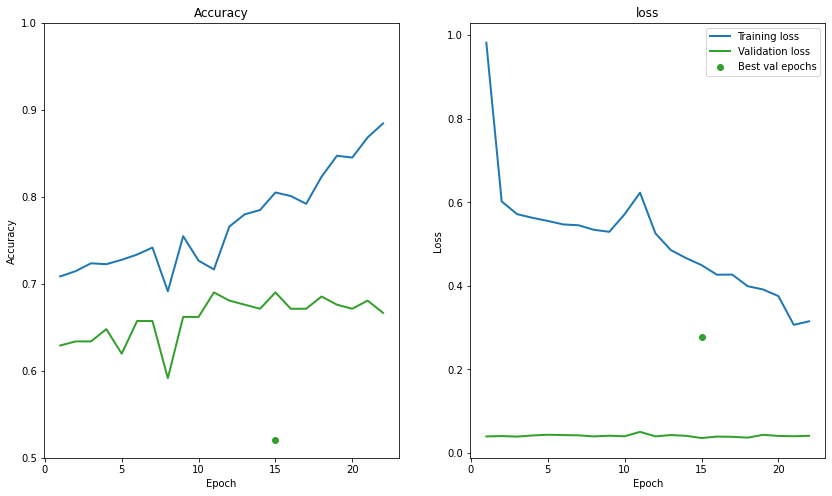

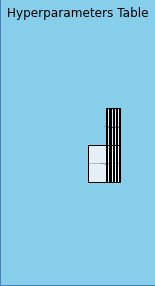

In [ ]:
seeds = 1 
batch_size = 12
metrics = 'acc'
weight_decay=0.001

model_init_params = {'kernel_size_1': 6, 'kernel_size_2': 4, 'kernel_size_3': 4, 
                     'ch_multiply': 0.5628041749856443, 'dropout_p': 0.3}

training_params = {'learning_rate': 0.00433325804870913, 'n_epochs': 21}
#net_prob(net,x[6:8,:,:],1,1)
# forward one trial
# net(th.unsqueeze(th.tensor( x[0,:,:].swapaxes(0,1),dtype=th.float),dim=0))
net = SimpleConvolutionalNetwork(bmm_atten=False,**model_init_params)
net.to(device)
train_history, val_history,best_model_epoch = train(net, batch_size=batch_size,metrics=metrics, **training_params)
plot_model_scores(train_history, val_history,test_loader,best_model_epoch,metrics=metrics)
learning_rate = round(training_params['learning_rate'],6)
n_epochs = training_params['n_epochs']
summerize_hyper_param()
#torch.autograd.set_detect_anomaly(False)

---- 5\12. CV acc:0.65 loss:0.04 Train acc:0.74 loss:0.53. Mean epoch time:3.69
---- 10\12. CV acc:0.67 loss:0.04 Train acc:0.76 loss:0.50. Mean epoch time:3.64
-

[I 2021-11-08 10:39:59,763] Trial 3 finished with value: 0.6525821601840812 and parameters: {'kernel_size_1': 10, 'kernel_size_2': 4, 'kernel_size_3': 4, 'ch_multiply': 1.7898615589032651, 'dropout_p': 0.5, 'learning_rate': 1.7994203765849863e-05, 'n_epochs': 12}. Best is trial 1 with value: 0.6666666669465007.


-Training Finished, took 43.58s
---- 5\28. CV acc:0.62 loss:0.05 Train acc:0.74 loss:0.53. Mean epoch time:2.32
---- 10\28. CV acc:0.64 loss:0.04 Train acc:0.79 loss:0.49. Mean epoch time:2.32
---- 15\28. CV acc:0.67 loss:0.05 Train acc:0.84 loss:0.41. Mean epoch time:2.31
---- 20\28. CV acc:0.62 loss:0.06 Train acc:0.89 loss:0.31. Mean epoch time:2.31
---- 25\28. CV acc:0.65 loss:0.07 Train acc:0.93 loss:0.21. Mean epoch time:2.31
--

[I 2021-11-08 10:41:04,942] Trial 4 finished with value: 0.6244131458197402 and parameters: {'kernel_size_1': 5, 'kernel_size_2': 7, 'kernel_size_3': 1, 'ch_multiply': 1.0158829625085886, 'dropout_p': 0.5, 'learning_rate': 0.0003976453011700043, 'n_epochs': 28}. Best is trial 1 with value: 0.6666666669465007.


-Training Finished, took 64.75s
---- 5\29. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.42
---- 10\29. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.45
---- 15\29. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.46
---- 20\29. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.46
---- 25\29. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.47
---

[I 2021-11-08 10:41:47,993] Trial 5 finished with value: 0.4788732395765367 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 0.33109007148512604, 'dropout_p': 0.4, 'learning_rate': 0.009259408975542387, 'n_epochs': 29}. Best is trial 1 with value: 0.6666666669465007.


-Training Finished, took 42.67s
---- 5\18. CV acc:0.65 loss:0.04 Train acc:0.74 loss:0.52. Mean epoch time:2.30
---- 10\18. CV acc:0.68 loss:0.04 Train acc:0.78 loss:0.47. Mean epoch time:2.29
---- 15\18. CV acc:0.67 loss:0.05 Train acc:0.81 loss:0.40. Mean epoch time:2.28
--

[I 2021-11-08 10:42:29,461] Trial 6 finished with value: 0.6572769958648323 and parameters: {'kernel_size_1': 5, 'kernel_size_2': 6, 'kernel_size_3': 1, 'ch_multiply': 1.0614189944990386, 'dropout_p': 0.5, 'learning_rate': 7.60050493128346e-05, 'n_epochs': 18}. Best is trial 1 with value: 0.6666666669465007.


-Training Finished, took 41.03s
---- 5\13. CV acc:0.65 loss:0.04 Train acc:0.75 loss:0.52. Mean epoch time:1.63
---- 10\13. CV acc:0.66 loss:0.04 Train acc:0.81 loss:0.44. Mean epoch time:1.63
--

[I 2021-11-08 10:42:50,957] Trial 7 finished with value: 0.647887323943662 and parameters: {'kernel_size_1': 4, 'kernel_size_2': 3, 'kernel_size_3': 4, 'ch_multiply': 0.6597677972001004, 'dropout_p': 0.1, 'learning_rate': 0.00029834549048893857, 'n_epochs': 13}. Best is trial 1 with value: 0.6666666669465007.


-Training Finished, took 21.11s
---- 5\28. CV acc:0.67 loss:0.04 Train acc:0.75 loss:0.52. Mean epoch time:2.68
---- 10\28. CV acc:0.66 loss:0.04 Train acc:0.85 loss:0.38. Mean epoch time:2.67
---- 15\28. CV acc:0.63 loss:0.06 Train acc:0.89 loss:0.32. Mean epoch time:2.68
---- 20\28. CV acc:0.64 loss:0.09 Train acc:0.94 loss:0.16. Mean epoch time:2.68
---- 25\28. CV acc:0.67 loss:0.08 Train acc:0.96 loss:0.11. Mean epoch time:2.68
--

[I 2021-11-08 10:44:06,474] Trial 8 finished with value: 0.6150234741784038 and parameters: {'kernel_size_1': 8, 'kernel_size_2': 3, 'kernel_size_3': 3, 'ch_multiply': 1.489589212035583, 'dropout_p': 0.0, 'learning_rate': 0.00017464974804939153, 'n_epochs': 28}. Best is trial 1 with value: 0.6666666669465007.


-Training Finished, took 75.03s
---- 5\26. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:2.64
---- 10\26. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:2.62
---- 15\26. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:2.61
---- 20\26. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:2.61
---- 25\26. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:2.62


[I 2021-11-08 10:45:14,963] Trial 9 finished with value: 0.47887323950657823 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 3, 'kernel_size_3': 3, 'ch_multiply': 1.428450896873641, 'dropout_p': 0.30000000000000004, 'learning_rate': 0.006819998324673501, 'n_epochs': 26}. Best is trial 1 with value: 0.6666666669465007.


-Training Finished, took 68.01s
---- 5\33. CV acc:0.68 loss:0.04 Train acc:0.74 loss:0.54. Mean epoch time:4.05
---- 10\33. CV acc:0.66 loss:0.04 Train acc:0.76 loss:0.50. Mean epoch time:3.97
---- 15\33. CV acc:0.69 loss:0.04 Train acc:0.80 loss:0.44. Mean epoch time:3.97
---- 20\33. CV acc:0.64 loss:0.04 Train acc:0.86 loss:0.37. Mean epoch time:3.97
---- 25\33. CV acc:0.57 loss:0.05 Train acc:0.85 loss:0.34. Mean epoch time:3.97
---- 30\33. CV acc:0.66 loss:0.06 Train acc:0.89 loss:0.21. Mean epoch time:3.96
--

[I 2021-11-08 10:47:26,183] Trial 10 finished with value: 0.619718309999072 and parameters: {'kernel_size_1': 8, 'kernel_size_2': 4, 'kernel_size_3': 2, 'ch_multiply': 1.9790155090340722, 'dropout_p': 0.2, 'learning_rate': 0.0010339457922695606, 'n_epochs': 33}. Best is trial 1 with value: 0.6666666669465007.


-Training Finished, took 130.60s
---- 5\21. CV acc:0.64 loss:0.04 Train acc:0.73 loss:0.55. Mean epoch time:1.76
---- 10\21. CV acc:0.64 loss:0.05 Train acc:0.74 loss:0.52. Mean epoch time:1.74
---- 15\21. CV acc:0.66 loss:0.04 Train acc:0.76 loss:0.51. Mean epoch time:1.74
---- 20\21. CV acc:0.66 loss:0.04 Train acc:0.77 loss:0.47. Mean epoch time:1.73


[I 2021-11-08 10:48:02,995] Trial 11 finished with value: 0.6525821599042472 and parameters: {'kernel_size_1': 7, 'kernel_size_2': 5, 'kernel_size_3': 2, 'ch_multiply': 0.7566413451502589, 'dropout_p': 0.30000000000000004, 'learning_rate': 1.4403408844511703e-05, 'n_epochs': 21}. Best is trial 1 with value: 0.6666666669465007.


-Training Finished, took 36.43s
---- 5\35. CV acc:0.64 loss:0.04 Train acc:0.72 loss:0.54. Mean epoch time:1.78
---- 10\35. CV acc:0.66 loss:0.04 Train acc:0.73 loss:0.53. Mean epoch time:1.78
---- 15\35. CV acc:0.65 loss:0.04 Train acc:0.74 loss:0.50. Mean epoch time:1.77
---- 20\35. CV acc:0.66 loss:0.04 Train acc:0.76 loss:0.49. Mean epoch time:1.77
---- 25\35. CV acc:0.68 loss:0.04 Train acc:0.76 loss:0.47. Mean epoch time:1.77
---- 30\35. CV acc:0.67 loss:0.04 Train acc:0.79 loss:0.46. Mean epoch time:1.77
----

[I 2021-11-08 10:49:05,335] Trial 12 finished with value: 0.676056338168086 and parameters: {'kernel_size_1': 7, 'kernel_size_2': 5, 'kernel_size_3': 2, 'ch_multiply': 0.7580031423708626, 'dropout_p': 0.2, 'learning_rate': 1.0504435239777278e-05, 'n_epochs': 35}. Best is trial 12 with value: 0.676056338168086.


 35\35. CV acc:0.68 loss:0.05 Train acc:0.80 loss:0.44. Mean epoch time:1.77
Training Finished, took 61.87s
---- 5\35. CV acc:0.65 loss:0.04 Train acc:0.73 loss:0.54. Mean epoch time:1.46
---- 10\35. CV acc:0.66 loss:0.04 Train acc:0.75 loss:0.51. Mean epoch time:1.47
---- 15\35. CV acc:0.65 loss:0.04 Train acc:0.79 loss:0.49. Mean epoch time:1.48
---- 20\35. CV acc:0.66 loss:0.04 Train acc:0.79 loss:0.45. Mean epoch time:1.48
---- 25\35. CV acc:0.68 loss:0.04 Train acc:0.80 loss:0.44. Mean epoch time:1.48
---- 30\35. CV acc:0.66 loss:0.04 Train acc:0.82 loss:0.40. Mean epoch time:1.49
----

[I 2021-11-08 10:49:57,861] Trial 13 finished with value: 0.6807511737788787 and parameters: {'kernel_size_1': 8, 'kernel_size_2': 4, 'kernel_size_3': 2, 'ch_multiply': 0.4373077751751764, 'dropout_p': 0.2, 'learning_rate': 5.7924942933534716e-05, 'n_epochs': 35}. Best is trial 13 with value: 0.6807511737788787.


 35\35. CV acc:0.68 loss:0.04 Train acc:0.84 loss:0.36. Mean epoch time:1.49
Training Finished, took 52.12s
---- 5\35. CV acc:0.66 loss:0.04 Train acc:0.74 loss:0.53. Mean epoch time:1.46
---- 10\35. CV acc:0.67 loss:0.04 Train acc:0.77 loss:0.50. Mean epoch time:1.47
---- 15\35. CV acc:0.72 loss:0.04 Train acc:0.80 loss:0.46. Mean epoch time:1.48
---- 20\35. CV acc:0.68 loss:0.04 Train acc:0.82 loss:0.41. Mean epoch time:1.48
---- 25\35. CV acc:0.68 loss:0.05 Train acc:0.84 loss:0.35. Mean epoch time:1.48
---- 30\35. CV acc:0.66 loss:0.06 Train acc:0.88 loss:0.32. Mean epoch time:1.48
----

[I 2021-11-08 10:50:50,024] Trial 14 finished with value: 0.6666666669465007 and parameters: {'kernel_size_1': 9, 'kernel_size_2': 5, 'kernel_size_3': 2, 'ch_multiply': 0.31035566095420997, 'dropout_p': 0.2, 'learning_rate': 0.00012220671887417476, 'n_epochs': 35}. Best is trial 13 with value: 0.6807511737788787.


 35\35. CV acc:0.67 loss:0.06 Train acc:0.88 loss:0.27. Mean epoch time:1.48
Training Finished, took 51.75s
---- 5\24. CV acc:0.65 loss:0.04 Train acc:0.72 loss:0.54. Mean epoch time:1.59
---- 10\24. CV acc:0.65 loss:0.04 Train acc:0.75 loss:0.51. Mean epoch time:1.57
---- 15\24. CV acc:0.66 loss:0.05 Train acc:0.76 loss:0.47. Mean epoch time:1.57
---- 20\24. CV acc:0.66 loss:0.05 Train acc:0.79 loss:0.45. Mean epoch time:1.57
---

[I 2021-11-08 10:51:27,900] Trial 15 finished with value: 0.6619718309859155 and parameters: {'kernel_size_1': 8, 'kernel_size_2': 4, 'kernel_size_3': 2, 'ch_multiply': 0.552381196775444, 'dropout_p': 0.1, 'learning_rate': 4.351283710582544e-05, 'n_epochs': 24}. Best is trial 13 with value: 0.6807511737788787.


-Training Finished, took 37.43s
---- 5\35. CV acc:0.64 loss:0.04 Train acc:0.72 loss:0.57. Mean epoch time:1.51
---- 10\35. CV acc:0.64 loss:0.04 Train acc:0.73 loss:0.54. Mean epoch time:1.50
---- 15\35. CV acc:0.65 loss:0.04 Train acc:0.74 loss:0.52. Mean epoch time:1.52
---- 20\35. CV acc:0.66 loss:0.04 Train acc:0.74 loss:0.52. Mean epoch time:1.53
---- 25\35. CV acc:0.65 loss:0.05 Train acc:0.75 loss:0.50. Mean epoch time:1.53
---- 30\35. CV acc:0.65 loss:0.04 Train acc:0.77 loss:0.49. Mean epoch time:1.53
----

[I 2021-11-08 10:52:21,682] Trial 16 finished with value: 0.6525821596244131 and parameters: {'kernel_size_1': 9, 'kernel_size_2': 5, 'kernel_size_3': 2, 'ch_multiply': 0.4981315343665555, 'dropout_p': 0.1, 'learning_rate': 1.073369272033968e-05, 'n_epochs': 35}. Best is trial 13 with value: 0.6807511737788787.


 35\35. CV acc:0.65 loss:0.04 Train acc:0.78 loss:0.48. Mean epoch time:1.52
Training Finished, took 53.36s
---- 5\31. CV acc:0.67 loss:0.04 Train acc:0.74 loss:0.57. Mean epoch time:2.08
---- 10\31. CV acc:0.71 loss:0.04 Train acc:0.78 loss:0.48. Mean epoch time:2.07
---- 15\31. CV acc:0.69 loss:0.04 Train acc:0.82 loss:0.41. Mean epoch time:2.07
---- 20\31. CV acc:0.66 loss:0.04 Train acc:0.85 loss:0.39. Mean epoch time:2.06
---- 25\31. CV acc:0.66 loss:0.04 Train acc:0.90 loss:0.30. Mean epoch time:2.06
---- 30\31. CV acc:0.64 loss:0.05 Train acc:0.93 loss:0.21. Mean epoch time:2.06


[I 2021-11-08 10:53:25,871] Trial 17 finished with value: 0.6150234747380717 and parameters: {'kernel_size_1': 7, 'kernel_size_2': 7, 'kernel_size_3': 4, 'ch_multiply': 0.8620443021997429, 'dropout_p': 0.2, 'learning_rate': 0.0021492596494356374, 'n_epochs': 31}. Best is trial 13 with value: 0.6807511737788787.


-Training Finished, took 63.75s
---- 5\21. CV acc:0.65 loss:0.04 Train acc:0.73 loss:0.54. Mean epoch time:1.60
---- 10\21. CV acc:0.65 loss:0.05 Train acc:0.77 loss:0.48. Mean epoch time:1.59
---- 15\21. CV acc:0.68 loss:0.05 Train acc:0.80 loss:0.44. Mean epoch time:1.59
---- 20\21. CV acc:0.64 loss:0.04 Train acc:0.82 loss:0.41. Mean epoch time:1.59


[I 2021-11-08 10:53:59,616] Trial 18 finished with value: 0.6431924888225788 and parameters: {'kernel_size_1': 7, 'kernel_size_2': 4, 'kernel_size_3': 1, 'ch_multiply': 0.555332358592455, 'dropout_p': 0.30000000000000004, 'learning_rate': 7.625551391503594e-05, 'n_epochs': 21}. Best is trial 13 with value: 0.6807511737788787.


-Training Finished, took 33.31s
---- 5\32. CV acc:0.64 loss:0.04 Train acc:0.71 loss:0.56. Mean epoch time:1.49
---- 10\32. CV acc:0.65 loss:0.04 Train acc:0.72 loss:0.55. Mean epoch time:1.50
---- 15\32. CV acc:0.66 loss:0.04 Train acc:0.73 loss:0.53. Mean epoch time:1.51
---- 20\32. CV acc:0.64 loss:0.04 Train acc:0.73 loss:0.53. Mean epoch time:1.52
---- 25\32. CV acc:0.65 loss:0.04 Train acc:0.74 loss:0.52. Mean epoch time:1.52
---- 30\32. CV acc:0.65 loss:0.04 Train acc:0.74 loss:0.51. Mean epoch time:1.53
-

[I 2021-11-08 10:54:49,017] Trial 19 finished with value: 0.6525821596244131 and parameters: {'kernel_size_1': 10, 'kernel_size_2': 5, 'kernel_size_3': 2, 'ch_multiply': 0.4353931934715706, 'dropout_p': 0.2, 'learning_rate': 1.0358500362585712e-05, 'n_epochs': 32}. Best is trial 13 with value: 0.6807511737788787.


-Training Finished, took 48.99s
---- 5\35. CV acc:0.65 loss:0.04 Train acc:0.74 loss:0.54. Mean epoch time:1.75
---- 10\35. CV acc:0.64 loss:0.04 Train acc:0.76 loss:0.50. Mean epoch time:1.76
---- 15\35. CV acc:0.64 loss:0.05 Train acc:0.77 loss:0.47. Mean epoch time:1.74
---- 20\35. CV acc:0.68 loss:0.05 Train acc:0.80 loss:0.43. Mean epoch time:1.74
---- 25\35. CV acc:0.67 loss:0.04 Train acc:0.82 loss:0.39. Mean epoch time:1.74
---- 30\35. CV acc:0.66 loss:0.05 Train acc:0.84 loss:0.36. Mean epoch time:1.73
----

[I 2021-11-08 10:55:50,124] Trial 20 finished with value: 0.6619718315455835 and parameters: {'kernel_size_1': 9, 'kernel_size_2': 5, 'kernel_size_3': 5, 'ch_multiply': 0.6806817278760734, 'dropout_p': 0.1, 'learning_rate': 2.8778863553553966e-05, 'n_epochs': 35}. Best is trial 13 with value: 0.6807511737788787.


 35\35. CV acc:0.66 loss:0.05 Train acc:0.86 loss:0.32. Mean epoch time:1.73
Training Finished, took 60.67s
---- 5\33. CV acc:0.65 loss:0.04 Train acc:0.74 loss:0.53. Mean epoch time:1.95
---- 10\33. CV acc:0.65 loss:0.05 Train acc:0.75 loss:0.48. Mean epoch time:1.94
---- 15\33. CV acc:0.64 loss:0.04 Train acc:0.81 loss:0.44. Mean epoch time:1.94
---- 20\33. CV acc:0.67 loss:0.05 Train acc:0.82 loss:0.41. Mean epoch time:1.94
---- 25\33. CV acc:0.63 loss:0.05 Train acc:0.84 loss:0.38. Mean epoch time:1.94
---- 30\33. CV acc:0.69 loss:0.05 Train acc:0.86 loss:0.32. Mean epoch time:1.94
--

[I 2021-11-08 10:56:54,660] Trial 21 finished with value: 0.676056338168086 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 4, 'kernel_size_3': 3, 'ch_multiply': 0.9422368647266492, 'dropout_p': 0.4, 'learning_rate': 3.3800522163878774e-05, 'n_epochs': 33}. Best is trial 13 with value: 0.6807511737788787.


-Training Finished, took 64.07s
---- 5\30. CV acc:0.67 loss:0.04 Train acc:0.76 loss:0.52. Mean epoch time:1.92
---- 10\30. CV acc:0.65 loss:0.04 Train acc:0.80 loss:0.46. Mean epoch time:1.91
---- 15\30. CV acc:0.66 loss:0.05 Train acc:0.84 loss:0.38. Mean epoch time:1.89
---- 20\30. CV acc:0.68 loss:0.06 Train acc:0.89 loss:0.32. Mean epoch time:1.89
---- 25\30. CV acc:0.65 loss:0.06 Train acc:0.92 loss:0.24. Mean epoch time:1.88
----

[I 2021-11-08 10:57:51,519] Trial 22 finished with value: 0.6666666669465007 and parameters: {'kernel_size_1': 8, 'kernel_size_2': 4, 'kernel_size_3': 3, 'ch_multiply': 0.884739789916648, 'dropout_p': 0.4, 'learning_rate': 7.652984760791682e-05, 'n_epochs': 30}. Best is trial 13 with value: 0.6807511737788787.


 30\30. CV acc:0.67 loss:0.07 Train acc:0.93 loss:0.20. Mean epoch time:1.88
Training Finished, took 56.41s
---- 5\33. CV acc:0.66 loss:0.04 Train acc:0.73 loss:0.52. Mean epoch time:2.43
---- 10\33. CV acc:0.68 loss:0.04 Train acc:0.76 loss:0.49. Mean epoch time:2.41
---- 15\33. CV acc:0.67 loss:0.05 Train acc:0.79 loss:0.45. Mean epoch time:2.39
---- 20\33. CV acc:0.67 loss:0.05 Train acc:0.81 loss:0.42. Mean epoch time:2.39
---- 25\33. CV acc:0.65 loss:0.04 Train acc:0.84 loss:0.38. Mean epoch time:2.38
---- 30\33. CV acc:0.66 loss:0.06 Train acc:0.82 loss:0.34. Mean epoch time:2.38
--

[I 2021-11-08 10:59:10,474] Trial 23 finished with value: 0.6056338028169014 and parameters: {'kernel_size_1': 5, 'kernel_size_2': 3, 'kernel_size_3': 2, 'ch_multiply': 1.2751731805689195, 'dropout_p': 0.30000000000000004, 'learning_rate': 2.1703164160287908e-05, 'n_epochs': 33}. Best is trial 13 with value: 0.6807511737788787.


-Training Finished, took 78.45s
---- 5\26. CV acc:0.66 loss:0.04 Train acc:0.74 loss:0.54. Mean epoch time:1.73
---- 10\26. CV acc:0.67 loss:0.05 Train acc:0.79 loss:0.47. Mean epoch time:1.72
---- 15\26. CV acc:0.69 loss:0.05 Train acc:0.84 loss:0.38. Mean epoch time:1.72
---- 20\26. CV acc:0.62 loss:0.05 Train acc:0.90 loss:0.28. Mean epoch time:1.73
---- 25\26. CV acc:0.66 loss:0.07 Train acc:0.94 loss:0.20. Mean epoch time:1.73


[I 2021-11-08 10:59:55,846] Trial 24 finished with value: 0.6384976525821596 and parameters: {'kernel_size_1': 7, 'kernel_size_2': 5, 'kernel_size_3': 4, 'ch_multiply': 0.6764541605039072, 'dropout_p': 0.4, 'learning_rate': 0.00020874892925354637, 'n_epochs': 26}. Best is trial 13 with value: 0.6807511737788787.


-Training Finished, took 44.92s
---- 5\35. CV acc:0.64 loss:0.05 Train acc:0.73 loss:0.52. Mean epoch time:1.92
---- 10\35. CV acc:0.68 loss:0.04 Train acc:0.78 loss:0.48. Mean epoch time:1.92
---- 15\35. CV acc:0.68 loss:0.04 Train acc:0.81 loss:0.42. Mean epoch time:1.92
---- 20\35. CV acc:0.64 loss:0.05 Train acc:0.84 loss:0.37. Mean epoch time:1.91
---- 25\35. CV acc:0.68 loss:0.06 Train acc:0.87 loss:0.29. Mean epoch time:1.91
---- 30\35. CV acc:0.66 loss:0.06 Train acc:0.89 loss:0.24. Mean epoch time:1.91
----

[I 2021-11-08 11:01:03,177] Trial 25 finished with value: 0.6666666667366252 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 4, 'kernel_size_3': 3, 'ch_multiply': 0.8997583782548083, 'dropout_p': 0.2, 'learning_rate': 5.033937565419374e-05, 'n_epochs': 35}. Best is trial 13 with value: 0.6807511737788787.


 35\35. CV acc:0.67 loss:0.05 Train acc:0.92 loss:0.20. Mean epoch time:1.91
Training Finished, took 66.87s
---- 5\33. CV acc:0.67 loss:0.04 Train acc:0.74 loss:0.53. Mean epoch time:2.28
---- 10\33. CV acc:0.66 loss:0.04 Train acc:0.77 loss:0.49. Mean epoch time:2.26
---- 15\33. CV acc:0.65 loss:0.04 Train acc:0.80 loss:0.45. Mean epoch time:2.25
---- 20\33. CV acc:0.66 loss:0.05 Train acc:0.80 loss:0.41. Mean epoch time:2.25
---- 25\33. CV acc:0.65 loss:0.05 Train acc:0.84 loss:0.36. Mean epoch time:2.24
---- 30\33. CV acc:0.63 loss:0.05 Train acc:0.85 loss:0.34. Mean epoch time:2.24
--

[I 2021-11-08 11:02:17,838] Trial 26 finished with value: 0.6244131460995741 and parameters: {'kernel_size_1': 8, 'kernel_size_2': 4, 'kernel_size_3': 2, 'ch_multiply': 1.1211534213750345, 'dropout_p': 0.30000000000000004, 'learning_rate': 2.834287459763606e-05, 'n_epochs': 33}. Best is trial 13 with value: 0.6807511737788787.


-Training Finished, took 74.16s
---- 5\26. CV acc:0.67 loss:0.04 Train acc:0.74 loss:0.53. Mean epoch time:1.51
---- 10\26. CV acc:0.67 loss:0.05 Train acc:0.78 loss:0.46. Mean epoch time:1.53
---- 15\26. CV acc:0.67 loss:0.06 Train acc:0.84 loss:0.36. Mean epoch time:1.53
---- 20\26. CV acc:0.63 loss:0.07 Train acc:0.91 loss:0.24. Mean epoch time:1.54
---- 25\26. CV acc:0.60 loss:0.07 Train acc:0.95 loss:0.16. Mean epoch time:1.53


[I 2021-11-08 11:02:58,148] Trial 27 finished with value: 0.64788732450333 and parameters: {'kernel_size_1': 7, 'kernel_size_2': 5, 'kernel_size_3': 1, 'ch_multiply': 0.426248208793076, 'dropout_p': 0.1, 'learning_rate': 0.0005543369445851, 'n_epochs': 26}. Best is trial 13 with value: 0.6807511737788787.


-Training Finished, took 39.89s
---- 5\30. CV acc:0.67 loss:0.04 Train acc:0.74 loss:0.53. Mean epoch time:1.61
---- 10\30. CV acc:0.66 loss:0.05 Train acc:0.76 loss:0.48. Mean epoch time:1.60
---- 15\30. CV acc:0.69 loss:0.04 Train acc:0.80 loss:0.43. Mean epoch time:1.59
---- 20\30. CV acc:0.64 loss:0.05 Train acc:0.85 loss:0.39. Mean epoch time:1.59
---- 25\30. CV acc:0.64 loss:0.06 Train acc:0.84 loss:0.32. Mean epoch time:1.59
----

[I 2021-11-08 11:03:46,440] Trial 28 finished with value: 0.6713615026272518 and parameters: {'kernel_size_1': 7, 'kernel_size_2': 3, 'kernel_size_3': 2, 'ch_multiply': 0.602680306777477, 'dropout_p': 0.2, 'learning_rate': 0.00010541219865878534, 'n_epochs': 30}. Best is trial 13 with value: 0.6807511737788787.


 30\30. CV acc:0.67 loss:0.06 Train acc:0.90 loss:0.24. Mean epoch time:1.60
Training Finished, took 47.86s
---- 5\34. CV acc:0.65 loss:0.04 Train acc:0.73 loss:0.55. Mean epoch time:1.84
---- 10\34. CV acc:0.66 loss:0.04 Train acc:0.73 loss:0.52. Mean epoch time:1.82
---- 15\34. CV acc:0.68 loss:0.04 Train acc:0.76 loss:0.50. Mean epoch time:1.83
---- 20\34. CV acc:0.67 loss:0.04 Train acc:0.77 loss:0.48. Mean epoch time:1.83
---- 25\34. CV acc:0.69 loss:0.04 Train acc:0.79 loss:0.46. Mean epoch time:1.82
---- 30\34. CV acc:0.68 loss:0.04 Train acc:0.80 loss:0.44. Mean epoch time:1.82
---

[I 2021-11-08 11:04:48,919] Trial 29 finished with value: 0.6666666672263347 and parameters: {'kernel_size_1': 5, 'kernel_size_2': 5, 'kernel_size_3': 1, 'ch_multiply': 0.7835361748229354, 'dropout_p': 0.4, 'learning_rate': 1.8285065080912853e-05, 'n_epochs': 34}. Best is trial 13 with value: 0.6807511737788787.


-Training Finished, took 62.00s
---- 5\31. CV acc:0.65 loss:0.04 Train acc:0.73 loss:0.54. Mean epoch time:2.71
---- 10\31. CV acc:0.68 loss:0.04 Train acc:0.78 loss:0.48. Mean epoch time:2.69
---- 15\31. CV acc:0.66 loss:0.05 Train acc:0.80 loss:0.42. Mean epoch time:2.67
---- 20\31. CV acc:0.66 loss:0.05 Train acc:0.84 loss:0.37. Mean epoch time:2.67
---- 25\31. CV acc:0.63 loss:0.05 Train acc:0.86 loss:0.31. Mean epoch time:2.67
---- 30\31. CV acc:0.68 loss:0.07 Train acc:0.89 loss:0.26. Mean epoch time:2.67


[I 2021-11-08 11:06:12,193] Trial 30 finished with value: 0.6431924888225788 and parameters: {'kernel_size_1': 9, 'kernel_size_2': 6, 'kernel_size_3': 3, 'ch_multiply': 1.2301448091718423, 'dropout_p': 0.30000000000000004, 'learning_rate': 2.7075643067106734e-05, 'n_epochs': 31}. Best is trial 13 with value: 0.6807511737788787.


-Training Finished, took 82.75s
---- 5\30. CV acc:0.67 loss:0.04 Train acc:0.74 loss:0.52. Mean epoch time:1.64
---- 10\30. CV acc:0.68 loss:0.04 Train acc:0.78 loss:0.49. Mean epoch time:1.62
---- 15\30. CV acc:0.66 loss:0.05 Train acc:0.80 loss:0.44. Mean epoch time:1.62
---- 20\30. CV acc:0.67 loss:0.04 Train acc:0.84 loss:0.39. Mean epoch time:1.62
---- 25\30. CV acc:0.62 loss:0.05 Train acc:0.87 loss:0.30. Mean epoch time:1.62
----

[I 2021-11-08 11:07:01,108] Trial 31 finished with value: 0.6384976528619937 and parameters: {'kernel_size_1': 7, 'kernel_size_2': 3, 'kernel_size_3': 2, 'ch_multiply': 0.5983992017475684, 'dropout_p': 0.2, 'learning_rate': 0.00010986345028507743, 'n_epochs': 30}. Best is trial 13 with value: 0.6807511737788787.


 30\30. CV acc:0.64 loss:0.06 Train acc:0.89 loss:0.25. Mean epoch time:1.62
Training Finished, took 48.46s
---- 5\33. CV acc:0.67 loss:0.04 Train acc:0.75 loss:0.52. Mean epoch time:2.02
---- 10\33. CV acc:0.67 loss:0.04 Train acc:0.80 loss:0.47. Mean epoch time:2.00
---- 15\33. CV acc:0.70 loss:0.04 Train acc:0.82 loss:0.40. Mean epoch time:1.99
---- 20\33. CV acc:0.66 loss:0.05 Train acc:0.85 loss:0.35. Mean epoch time:1.99
---- 25\33. CV acc:0.69 loss:0.05 Train acc:0.90 loss:0.28. Mean epoch time:1.98
---- 30\33. CV acc:0.67 loss:0.06 Train acc:0.91 loss:0.24. Mean epoch time:1.97
--

[I 2021-11-08 11:08:06,547] Trial 32 finished with value: 0.6666666669465007 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 3, 'kernel_size_3': 2, 'ch_multiply': 0.9716253928821933, 'dropout_p': 0.2, 'learning_rate': 5.271389133287456e-05, 'n_epochs': 33}. Best is trial 13 with value: 0.6807511737788787.


-Training Finished, took 64.95s
---- 5\32. CV acc:0.67 loss:0.04 Train acc:0.74 loss:0.53. Mean epoch time:1.79
---- 10\32. CV acc:0.65 loss:0.05 Train acc:0.78 loss:0.46. Mean epoch time:1.78
---- 15\32. CV acc:0.65 loss:0.04 Train acc:0.86 loss:0.37. Mean epoch time:1.78
---- 20\32. CV acc:0.63 loss:0.05 Train acc:0.90 loss:0.27. Mean epoch time:1.78
---- 25\32. CV acc:0.68 loss:0.06 Train acc:0.95 loss:0.19. Mean epoch time:1.78
---- 30\32. CV acc:0.63 loss:0.08 Train acc:0.96 loss:0.14. Mean epoch time:1.77
-

[I 2021-11-08 11:09:03,763] Trial 33 finished with value: 0.64788732450333 and parameters: {'kernel_size_1': 7, 'kernel_size_2': 4, 'kernel_size_3': 3, 'ch_multiply': 0.7540234168480198, 'dropout_p': 0.2, 'learning_rate': 0.00014062133817552142, 'n_epochs': 32}. Best is trial 13 with value: 0.6807511737788787.


-Training Finished, took 56.77s
---- 5\34. CV acc:0.65 loss:0.04 Train acc:0.74 loss:0.54. Mean epoch time:1.51
---- 10\34. CV acc:0.67 loss:0.04 Train acc:0.75 loss:0.51. Mean epoch time:1.53
---- 15\34. CV acc:0.69 loss:0.04 Train acc:0.78 loss:0.48. Mean epoch time:1.53
---- 20\34. CV acc:0.68 loss:0.04 Train acc:0.80 loss:0.45. Mean epoch time:1.54
---- 25\34. CV acc:0.69 loss:0.04 Train acc:0.82 loss:0.41. Mean epoch time:1.54
---- 30\34. CV acc:0.66 loss:0.06 Train acc:0.81 loss:0.38. Mean epoch time:1.54
---

[I 2021-11-08 11:09:56,802] Trial 34 finished with value: 0.6244131458197402 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 3, 'kernel_size_3': 1, 'ch_multiply': 0.4398015802752986, 'dropout_p': 0.1, 'learning_rate': 6.412854002798458e-05, 'n_epochs': 34}. Best is trial 13 with value: 0.6807511737788787.


-Training Finished, took 52.60s
---- 5\29. CV acc:0.65 loss:0.04 Train acc:0.74 loss:0.52. Mean epoch time:2.00
---- 10\29. CV acc:0.66 loss:0.05 Train acc:0.77 loss:0.46. Mean epoch time:1.97
---- 15\29. CV acc:0.65 loss:0.05 Train acc:0.82 loss:0.43. Mean epoch time:1.97
---- 20\29. CV acc:0.67 loss:0.04 Train acc:0.85 loss:0.38. Mean epoch time:1.96
---- 25\29. CV acc:0.66 loss:0.06 Train acc:0.84 loss:0.32. Mean epoch time:1.96
---

[I 2021-11-08 11:10:54,114] Trial 35 finished with value: 0.6619718312657495 and parameters: {'kernel_size_1': 8, 'kernel_size_2': 4, 'kernel_size_3': 3, 'ch_multiply': 0.93888490387494, 'dropout_p': 0.0, 'learning_rate': 3.574750848000309e-05, 'n_epochs': 29}. Best is trial 13 with value: 0.6807511737788787.


-Training Finished, took 56.83s
---- 5\31. CV acc:0.66 loss:0.04 Train acc:0.73 loss:0.55. Mean epoch time:1.65
---- 10\31. CV acc:0.65 loss:0.04 Train acc:0.74 loss:0.53. Mean epoch time:1.65
---- 15\31. CV acc:0.65 loss:0.04 Train acc:0.75 loss:0.52. Mean epoch time:1.66
---- 20\31. CV acc:0.67 loss:0.04 Train acc:0.76 loss:0.50. Mean epoch time:1.66
---- 25\31. CV acc:0.66 loss:0.04 Train acc:0.76 loss:0.48. Mean epoch time:1.66
---- 30\31. CV acc:0.66 loss:0.04 Train acc:0.78 loss:0.47. Mean epoch time:1.66


[I 2021-11-08 11:11:45,991] Trial 36 finished with value: 0.6666666672263347 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 4, 'kernel_size_3': 2, 'ch_multiply': 0.6269212328954201, 'dropout_p': 0.5, 'learning_rate': 1.488270955913273e-05, 'n_epochs': 31}. Best is trial 13 with value: 0.6807511737788787.


-Training Finished, took 51.42s
---- 5\34. CV acc:0.66 loss:0.05 Train acc:0.73 loss:0.52. Mean epoch time:1.79
---- 10\34. CV acc:0.68 loss:0.04 Train acc:0.73 loss:0.47. Mean epoch time:1.78
---- 15\34. CV acc:0.66 loss:0.05 Train acc:0.84 loss:0.40. Mean epoch time:1.78
---- 20\34. CV acc:0.68 loss:0.06 Train acc:0.85 loss:0.33. Mean epoch time:1.78
---- 25\34. CV acc:0.67 loss:0.05 Train acc:0.93 loss:0.24. Mean epoch time:1.78
---- 30\34. CV acc:0.64 loss:0.07 Train acc:0.93 loss:0.19. Mean epoch time:1.78
---

[I 2021-11-08 11:12:46,881] Trial 37 finished with value: 0.6384976527220766 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 3, 'kernel_size_3': 4, 'ch_multiply': 0.7690899652057986, 'dropout_p': 0.30000000000000004, 'learning_rate': 9.735757177327635e-05, 'n_epochs': 34}. Best is trial 13 with value: 0.6807511737788787.


-Training Finished, took 60.42s
---- 5\28. CV acc:0.67 loss:0.04 Train acc:0.74 loss:0.54. Mean epoch time:1.52
---- 10\28. CV acc:0.66 loss:0.04 Train acc:0.78 loss:0.49. Mean epoch time:1.54
---- 15\28. CV acc:0.64 loss:0.05 Train acc:0.78 loss:0.41. Mean epoch time:1.55
---- 20\28. CV acc:0.65 loss:0.06 Train acc:0.84 loss:0.35. Mean epoch time:1.55
---- 25\28. CV acc:0.59 loss:0.09 Train acc:0.93 loss:0.23. Mean epoch time:1.55
--

[I 2021-11-08 11:13:30,784] Trial 38 finished with value: 0.64788732450333 and parameters: {'kernel_size_1': 7, 'kernel_size_2': 6, 'kernel_size_3': 1, 'ch_multiply': 0.3852244266513899, 'dropout_p': 0.4, 'learning_rate': 0.00032434385164857045, 'n_epochs': 28}. Best is trial 13 with value: 0.6807511737788787.


-Training Finished, took 43.45s
---- 5\29. CV acc:0.66 loss:0.04 Train acc:0.75 loss:0.51. Mean epoch time:2.32
---- 10\29. CV acc:0.65 loss:0.05 Train acc:0.79 loss:0.46. Mean epoch time:2.30
---- 15\29. CV acc:0.60 loss:0.05 Train acc:0.85 loss:0.37. Mean epoch time:2.30
---- 20\29. CV acc:0.65 loss:0.08 Train acc:0.91 loss:0.22. Mean epoch time:2.29
---- 25\29. CV acc:0.65 loss:0.10 Train acc:0.94 loss:0.14. Mean epoch time:2.29
---

[I 2021-11-08 11:14:37,576] Trial 39 finished with value: 0.6431924882629108 and parameters: {'kernel_size_1': 5, 'kernel_size_2': 4, 'kernel_size_3': 3, 'ch_multiply': 1.07375150877103, 'dropout_p': 0.2, 'learning_rate': 0.00021917475487431235, 'n_epochs': 29}. Best is trial 13 with value: 0.6807511737788787.


-Training Finished, took 66.29s
---- 5\32. CV acc:0.64 loss:0.04 Train acc:0.72 loss:0.54. Mean epoch time:1.61
---- 10\32. CV acc:0.66 loss:0.04 Train acc:0.75 loss:0.51. Mean epoch time:1.61
---- 15\32. CV acc:0.67 loss:0.04 Train acc:0.76 loss:0.48. Mean epoch time:1.61
---- 20\32. CV acc:0.67 loss:0.04 Train acc:0.80 loss:0.44. Mean epoch time:1.61
---- 25\32. CV acc:0.69 loss:0.05 Train acc:0.80 loss:0.41. Mean epoch time:1.61
---- 30\32. CV acc:0.69 loss:0.04 Train acc:0.82 loss:0.39. Mean epoch time:1.61
-

[I 2021-11-08 11:15:29,608] Trial 40 finished with value: 0.6666666672263347 and parameters: {'kernel_size_1': 8, 'kernel_size_2': 3, 'kernel_size_3': 3, 'ch_multiply': 0.5525643858861584, 'dropout_p': 0.1, 'learning_rate': 4.286108135224854e-05, 'n_epochs': 32}. Best is trial 13 with value: 0.6807511737788787.


-Training Finished, took 51.58s
---- 5\34. CV acc:0.64 loss:0.04 Train acc:0.73 loss:0.54. Mean epoch time:1.55
---- 10\34. CV acc:0.67 loss:0.04 Train acc:0.75 loss:0.51. Mean epoch time:1.57
---- 15\34. CV acc:0.68 loss:0.04 Train acc:0.76 loss:0.48. Mean epoch time:1.58
---- 20\34. CV acc:0.66 loss:0.05 Train acc:0.79 loss:0.44. Mean epoch time:1.59
---- 25\34. CV acc:0.66 loss:0.04 Train acc:0.82 loss:0.41. Mean epoch time:1.60
---- 30\34. CV acc:0.64 loss:0.05 Train acc:0.84 loss:0.37. Mean epoch time:1.60
---

[I 2021-11-08 11:16:24,601] Trial 41 finished with value: 0.6150234744582378 and parameters: {'kernel_size_1': 8, 'kernel_size_2': 3, 'kernel_size_3': 3, 'ch_multiply': 0.5063430242463035, 'dropout_p': 0.1, 'learning_rate': 4.161873953031348e-05, 'n_epochs': 34}. Best is trial 13 with value: 0.6807511737788787.


-Training Finished, took 54.54s
---- 5\31. CV acc:0.64 loss:0.05 Train acc:0.72 loss:0.56. Mean epoch time:1.73
---- 10\31. CV acc:0.65 loss:0.04 Train acc:0.73 loss:0.54. Mean epoch time:1.73
---- 15\31. CV acc:0.65 loss:0.04 Train acc:0.74 loss:0.52. Mean epoch time:1.72
---- 20\31. CV acc:0.64 loss:0.05 Train acc:0.74 loss:0.51. Mean epoch time:1.71
---- 25\31. CV acc:0.66 loss:0.04 Train acc:0.75 loss:0.50. Mean epoch time:1.71
---- 30\31. CV acc:0.64 loss:0.05 Train acc:0.75 loss:0.49. Mean epoch time:1.71


[I 2021-11-08 11:17:18,143] Trial 42 finished with value: 0.6619718315455835 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 4, 'kernel_size_3': 2, 'ch_multiply': 0.6471918896574352, 'dropout_p': 0.5, 'learning_rate': 1.4416845764450056e-05, 'n_epochs': 31}. Best is trial 13 with value: 0.6807511737788787.


-Training Finished, took 53.06s
---- 5\32. CV acc:0.64 loss:0.04 Train acc:0.73 loss:0.54. Mean epoch time:1.83
---- 10\32. CV acc:0.65 loss:0.05 Train acc:0.75 loss:0.50. Mean epoch time:1.83
---- 15\32. CV acc:0.68 loss:0.04 Train acc:0.78 loss:0.47. Mean epoch time:1.83
---- 20\32. CV acc:0.67 loss:0.04 Train acc:0.81 loss:0.43. Mean epoch time:1.83
---- 25\32. CV acc:0.67 loss:0.05 Train acc:0.81 loss:0.40. Mean epoch time:1.82
---- 30\32. CV acc:0.67 loss:0.04 Train acc:0.83 loss:0.37. Mean epoch time:1.82
-

[I 2021-11-08 11:18:16,992] Trial 43 finished with value: 0.6666666669465007 and parameters: {'kernel_size_1': 8, 'kernel_size_2': 3, 'kernel_size_3': 3, 'ch_multiply': 0.8244742588126204, 'dropout_p': 0.0, 'learning_rate': 2.4732400066788074e-05, 'n_epochs': 32}. Best is trial 13 with value: 0.6807511737788787.


-Training Finished, took 58.36s
---- 5\14. CV acc:0.65 loss:0.04 Train acc:0.73 loss:0.53. Mean epoch time:1.78
---- 10\14. CV acc:0.66 loss:0.05 Train acc:0.75 loss:0.49. Mean epoch time:1.76
---

[I 2021-11-08 11:18:42,088] Trial 44 finished with value: 0.6713615029070858 and parameters: {'kernel_size_1': 7, 'kernel_size_2': 3, 'kernel_size_3': 4, 'ch_multiply': 0.7161539107740889, 'dropout_p': 0.1, 'learning_rate': 3.494707023322162e-05, 'n_epochs': 14}. Best is trial 13 with value: 0.6807511737788787.


-Training Finished, took 24.62s
---- 5\17. CV acc:0.66 loss:0.04 Train acc:0.73 loss:0.53. Mean epoch time:1.78
---- 10\17. CV acc:0.68 loss:0.04 Train acc:0.78 loss:0.48. Mean epoch time:1.77
---- 15\17. CV acc:0.66 loss:0.05 Train acc:0.79 loss:0.44. Mean epoch time:1.77
-

[I 2021-11-08 11:19:12,603] Trial 45 finished with value: 0.676056338308003 and parameters: {'kernel_size_1': 7, 'kernel_size_2': 3, 'kernel_size_3': 5, 'ch_multiply': 0.708547742317718, 'dropout_p': 0.2, 'learning_rate': 5.795982572761479e-05, 'n_epochs': 17}. Best is trial 13 with value: 0.6807511737788787.


-Training Finished, took 30.04s
---- 5\15. CV acc:0.66 loss:0.04 Train acc:0.74 loss:0.53. Mean epoch time:2.35
---- 10\15. CV acc:0.67 loss:0.04 Train acc:0.78 loss:0.47. Mean epoch time:2.33
----

[I 2021-11-08 11:19:47,982] Trial 46 finished with value: 0.6525821599042472 and parameters: {'kernel_size_1': 7, 'kernel_size_2': 4, 'kernel_size_3': 5, 'ch_multiply': 1.017460582151502, 'dropout_p': 0.1, 'learning_rate': 3.358317015482363e-05, 'n_epochs': 15}. Best is trial 13 with value: 0.6807511737788787.


 15\15. CV acc:0.65 loss:0.04 Train acc:0.82 loss:0.41. Mean epoch time:2.32
Training Finished, took 34.88s
---- 5\17. CV acc:0.66 loss:0.04 Train acc:0.73 loss:0.55. Mean epoch time:1.89
---- 10\17. CV acc:0.65 loss:0.04 Train acc:0.74 loss:0.52. Mean epoch time:1.89
---- 15\17. CV acc:0.66 loss:0.04 Train acc:0.76 loss:0.50. Mean epoch time:1.88
-

[I 2021-11-08 11:20:20,364] Trial 47 finished with value: 0.647887323943662 and parameters: {'kernel_size_1': 7, 'kernel_size_2': 7, 'kernel_size_3': 5, 'ch_multiply': 0.6938808511848994, 'dropout_p': 0.30000000000000004, 'learning_rate': 1.9447610008976175e-05, 'n_epochs': 17}. Best is trial 13 with value: 0.6807511737788787.


-Training Finished, took 31.90s
---- 5\13. CV acc:0.67 loss:0.04 Train acc:0.76 loss:0.52. Mean epoch time:3.17
---- 10\13. CV acc:0.66 loss:0.04 Train acc:0.82 loss:0.44. Mean epoch time:3.17
--

[I 2021-11-08 11:21:02,014] Trial 48 finished with value: 0.6666666668065837 and parameters: {'kernel_size_1': 4, 'kernel_size_2': 3, 'kernel_size_3': 4, 'ch_multiply': 1.6207273001395677, 'dropout_p': 0.2, 'learning_rate': 6.0028979130121364e-05, 'n_epochs': 13}. Best is trial 13 with value: 0.6807511737788787.


-Training Finished, took 41.06s
---- 5\15. CV acc:0.64 loss:0.04 Train acc:0.72 loss:0.54. Mean epoch time:2.05
---- 10\15. CV acc:0.65 loss:0.04 Train acc:0.74 loss:0.52. Mean epoch time:2.05
----

[I 2021-11-08 11:21:33,273] Trial 49 finished with value: 0.6572769953751229 and parameters: {'kernel_size_1': 5, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 0.8198345776919675, 'dropout_p': 0.1, 'learning_rate': 1.0446628624441385e-05, 'n_epochs': 15}. Best is trial 13 with value: 0.6807511737788787.


 15\15. CV acc:0.66 loss:0.04 Train acc:0.75 loss:0.50. Mean epoch time:2.05
Training Finished, took 30.74s
---- 5\20. CV acc:0.65 loss:0.04 Train acc:0.76 loss:0.54. Mean epoch time:1.80
---- 10\20. CV acc:0.68 loss:0.04 Train acc:0.78 loss:0.49. Mean epoch time:1.81
---- 15\20. CV acc:0.63 loss:0.04 Train acc:0.77 loss:0.46. Mean epoch time:1.81
----

[I 2021-11-08 11:22:09,855] Trial 50 finished with value: 0.6854460095295883 and parameters: {'kernel_size_1': 7, 'kernel_size_2': 4, 'kernel_size_3': 4, 'ch_multiply': 0.7236813039951662, 'dropout_p': 0.2, 'learning_rate': 0.002091333429703354, 'n_epochs': 20}. Best is trial 50 with value: 0.6854460095295883.


 20\20. CV acc:0.69 loss:0.04 Train acc:0.86 loss:0.39. Mean epoch time:1.80
Training Finished, took 36.09s
---- 5\19. CV acc:0.63 loss:0.04 Train acc:0.73 loss:0.54. Mean epoch time:1.83
---- 10\19. CV acc:0.68 loss:0.04 Train acc:0.75 loss:0.50. Mean epoch time:1.84
---- 15\19. CV acc:0.69 loss:0.04 Train acc:0.80 loss:0.44. Mean epoch time:1.84
---

[I 2021-11-08 11:22:45,239] Trial 51 finished with value: 0.6854460096695054 and parameters: {'kernel_size_1': 7, 'kernel_size_2': 4, 'kernel_size_3': 4, 'ch_multiply': 0.7227445786081736, 'dropout_p': 0.2, 'learning_rate': 0.003426435188634729, 'n_epochs': 19}. Best is trial 51 with value: 0.6854460096695054.


-Training Finished, took 34.89s
---- 5\19. CV acc:0.63 loss:0.04 Train acc:0.74 loss:0.56. Mean epoch time:2.08
---- 10\19. CV acc:0.64 loss:0.04 Train acc:0.76 loss:0.52. Mean epoch time:2.08
---- 15\19. CV acc:0.68 loss:0.04 Train acc:0.76 loss:0.51. Mean epoch time:2.08
---

[I 2021-11-08 11:23:25,233] Trial 52 finished with value: 0.6854460096695054 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 4, 'kernel_size_3': 4, 'ch_multiply': 0.937352479379673, 'dropout_p': 0.2, 'learning_rate': 0.004160023532783038, 'n_epochs': 19}. Best is trial 51 with value: 0.6854460096695054.


-Training Finished, took 39.47s
---- 5\19. CV acc:0.63 loss:0.04 Train acc:0.73 loss:0.57. Mean epoch time:1.55
---- 10\19. CV acc:0.65 loss:0.04 Train acc:0.75 loss:0.52. Mean epoch time:1.58
---- 15\19. CV acc:0.68 loss:0.04 Train acc:0.78 loss:0.47. Mean epoch time:1.60
---

[I 2021-11-08 11:23:56,165] Trial 53 finished with value: 0.6995305167117589 and parameters: {'kernel_size_1': 9, 'kernel_size_2': 5, 'kernel_size_3': 4, 'ch_multiply': 0.30066394368723126, 'dropout_p': 0.2, 'learning_rate': 0.0036852184134751075, 'n_epochs': 19}. Best is trial 53 with value: 0.6995305167117589.


-Training Finished, took 30.46s
---- 5\19. CV acc:0.64 loss:0.04 Train acc:0.70 loss:0.59. Mean epoch time:1.67
---- 10\19. CV acc:0.65 loss:0.04 Train acc:0.75 loss:0.53. Mean epoch time:1.67
---- 15\19. CV acc:0.67 loss:0.04 Train acc:0.77 loss:0.48. Mean epoch time:1.66
---

[I 2021-11-08 11:24:28,191] Trial 54 finished with value: 0.6525821596244131 and parameters: {'kernel_size_1': 9, 'kernel_size_2': 4, 'kernel_size_3': 4, 'ch_multiply': 0.35462196853597105, 'dropout_p': 0.2, 'learning_rate': 0.004376666909528005, 'n_epochs': 19}. Best is trial 53 with value: 0.6995305167117589.


-Training Finished, took 31.56s
---- 5\20. CV acc:0.61 loss:0.04 Train acc:0.72 loss:0.55. Mean epoch time:1.64
---- 10\20. CV acc:0.68 loss:0.04 Train acc:0.77 loss:0.50. Mean epoch time:1.64
---- 15\20. CV acc:0.68 loss:0.04 Train acc:0.81 loss:0.45. Mean epoch time:1.63
----

[I 2021-11-08 11:25:01,181] Trial 55 finished with value: 0.6103286384976526 and parameters: {'kernel_size_1': 10, 'kernel_size_2': 4, 'kernel_size_3': 4, 'ch_multiply': 0.3129058545540009, 'dropout_p': 0.2, 'learning_rate': 0.00295048324846605, 'n_epochs': 20}. Best is trial 53 with value: 0.6995305167117589.


 20\20. CV acc:0.61 loss:0.04 Train acc:0.89 loss:0.34. Mean epoch time:1.63
Training Finished, took 32.52s
---- 5\22. CV acc:0.63 loss:0.04 Train acc:0.74 loss:0.55. Mean epoch time:1.74
---- 10\22. CV acc:0.69 loss:0.03 Train acc:0.77 loss:0.49. Mean epoch time:1.71
---- 15\22. CV acc:0.63 loss:0.04 Train acc:0.86 loss:0.38. Mean epoch time:1.71
---- 20\22. CV acc:0.63 loss:0.05 Train acc:0.92 loss:0.27. Mean epoch time:1.71
-

[I 2021-11-08 11:25:39,340] Trial 56 finished with value: 0.6244131460995741 and parameters: {'kernel_size_1': 9, 'kernel_size_2': 5, 'kernel_size_3': 5, 'ch_multiply': 0.5156638675623774, 'dropout_p': 0.2, 'learning_rate': 0.0014534742090072316, 'n_epochs': 22}. Best is trial 53 with value: 0.6995305167117589.


-Training Finished, took 37.69s
---- 5\18. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.61
---- 10\18. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.63
---- 15\18. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.65
--

[I 2021-11-08 11:26:09,580] Trial 57 finished with value: 0.4788732399962877 and parameters: {'kernel_size_1': 8, 'kernel_size_2': 4, 'kernel_size_3': 4, 'ch_multiply': 0.45330711391103373, 'dropout_p': 0.30000000000000004, 'learning_rate': 0.009422618217451944, 'n_epochs': 18}. Best is trial 53 with value: 0.6995305167117589.


-Training Finished, took 29.76s
---- 5\17. CV acc:0.67 loss:0.04 Train acc:0.72 loss:0.62. Mean epoch time:1.59
---- 10\17. CV acc:0.69 loss:0.04 Train acc:0.77 loss:0.51. Mean epoch time:1.58
---- 15\17. CV acc:0.67 loss:0.04 Train acc:0.79 loss:0.44. Mean epoch time:1.59
-

[I 2021-11-08 11:26:37,105] Trial 58 finished with value: 0.6572769958648323 and parameters: {'kernel_size_1': 9, 'kernel_size_2': 5, 'kernel_size_3': 4, 'ch_multiply': 0.37761639706489125, 'dropout_p': 0.2, 'learning_rate': 0.005776033425193472, 'n_epochs': 17}. Best is trial 53 with value: 0.6995305167117589.


-Training Finished, took 27.05s
---- 5\23. CV acc:0.69 loss:0.04 Train acc:0.74 loss:0.61. Mean epoch time:4.66
---- 10\23. CV acc:0.67 loss:0.04 Train acc:0.75 loss:0.54. Mean epoch time:4.56
---- 15\23. CV acc:0.68 loss:0.04 Train acc:0.77 loss:0.51. Mean epoch time:4.55
---- 20\23. CV acc:0.66 loss:0.04 Train acc:0.75 loss:0.59. Mean epoch time:4.53
--

[I 2021-11-08 11:28:21,906] Trial 59 finished with value: 0.4788732395765367 and parameters: {'kernel_size_1': 10, 'kernel_size_2': 5, 'kernel_size_3': 4, 'ch_multiply': 1.9870175016100333, 'dropout_p': 0.2, 'learning_rate': 0.0032409687621282202, 'n_epochs': 23}. Best is trial 53 with value: 0.6995305167117589.


-Training Finished, took 104.13s
---- 5\20. CV acc:0.64 loss:0.04 Train acc:0.75 loss:0.53. Mean epoch time:2.05
---- 10\20. CV acc:0.69 loss:0.04 Train acc:0.81 loss:0.47. Mean epoch time:2.03
---- 15\20. CV acc:0.66 loss:0.04 Train acc:0.87 loss:0.35. Mean epoch time:2.01
----

[I 2021-11-08 11:29:02,892] Trial 60 finished with value: 0.6244131460995741 and parameters: {'kernel_size_1': 8, 'kernel_size_2': 4, 'kernel_size_3': 5, 'ch_multiply': 0.8618758939337365, 'dropout_p': 0.2, 'learning_rate': 0.0015211207368557404, 'n_epochs': 20}. Best is trial 53 with value: 0.6995305167117589.


 20\20. CV acc:0.62 loss:0.04 Train acc:0.88 loss:0.34. Mean epoch time:2.01
Training Finished, took 40.13s
---- 5\19. CV acc:0.68 loss:0.04 Train acc:0.76 loss:0.54. Mean epoch time:2.70
---- 10\19. CV acc:0.63 loss:0.04 Train acc:0.78 loss:0.46. Mean epoch time:2.68
---- 15\19. CV acc:0.68 loss:0.04 Train acc:0.86 loss:0.36. Mean epoch time:2.68
---

[I 2021-11-08 11:29:54,256] Trial 61 finished with value: 0.6056338033765695 and parameters: {'kernel_size_1': 7, 'kernel_size_2': 5, 'kernel_size_3': 5, 'ch_multiply': 1.190864664311307, 'dropout_p': 0.2, 'learning_rate': 0.0006548049082173905, 'n_epochs': 19}. Best is trial 53 with value: 0.6995305167117589.


-Training Finished, took 50.82s
---- 5\18. CV acc:0.52 loss:0.05 Train acc:0.49 loss:0.69. Mean epoch time:1.85
---- 10\18. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.84
---- 15\18. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.70. Mean epoch time:1.85
--

[I 2021-11-08 11:30:28,010] Trial 62 finished with value: 0.4788732395765367 and parameters: {'kernel_size_1': 7, 'kernel_size_2': 5, 'kernel_size_3': 4, 'ch_multiply': 0.7274739745026174, 'dropout_p': 0.2, 'learning_rate': 0.006578112031489481, 'n_epochs': 18}. Best is trial 53 with value: 0.6995305167117589.


-Training Finished, took 33.25s
---- 5\21. CV acc:0.69 loss:0.04 Train acc:0.74 loss:0.65. Mean epoch time:1.76
---- 10\21. CV acc:0.67 loss:0.04 Train acc:0.75 loss:0.54. Mean epoch time:1.76
---- 15\21. CV acc:0.66 loss:0.04 Train acc:0.77 loss:0.49. Mean epoch time:1.76
---- 20\21. CV acc:0.68 loss:0.04 Train acc:0.81 loss:0.41. Mean epoch time:1.76


[I 2021-11-08 11:31:05,445] Trial 63 finished with value: 0.676056338168086 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 5, 'kernel_size_3': 4, 'ch_multiply': 0.6121356150535533, 'dropout_p': 0.2, 'learning_rate': 0.004531297832629281, 'n_epochs': 21}. Best is trial 53 with value: 0.6995305167117589.


-Training Finished, took 36.94s
---- 5\21. CV acc:0.67 loss:0.04 Train acc:0.74 loss:0.56. Mean epoch time:1.72
---- 10\21. CV acc:0.67 loss:0.04 Train acc:0.75 loss:0.51. Mean epoch time:1.70
---- 15\21. CV acc:0.69 loss:0.04 Train acc:0.78 loss:0.51. Mean epoch time:1.70
---- 20\21. CV acc:0.70 loss:0.04 Train acc:0.82 loss:0.43. Mean epoch time:1.69


[I 2021-11-08 11:31:41,471] Trial 64 finished with value: 0.7230046953953487 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 4, 'kernel_size_3': 4, 'ch_multiply': 0.5628041749856443, 'dropout_p': 0.30000000000000004, 'learning_rate': 0.00433325804870913, 'n_epochs': 21}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 35.54s
---- 5\24. CV acc:0.67 loss:0.04 Train acc:0.74 loss:0.53. Mean epoch time:1.63
---- 10\24. CV acc:0.70 loss:0.04 Train acc:0.77 loss:0.49. Mean epoch time:1.63
---- 15\24. CV acc:0.66 loss:0.04 Train acc:0.82 loss:0.45. Mean epoch time:1.63
---- 20\24. CV acc:0.68 loss:0.04 Train acc:0.85 loss:0.41. Mean epoch time:1.63
---

[I 2021-11-08 11:32:21,114] Trial 65 finished with value: 0.6244131460995741 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 4, 'kernel_size_3': 4, 'ch_multiply': 0.5070525469758747, 'dropout_p': 0.30000000000000004, 'learning_rate': 0.004094354655171137, 'n_epochs': 24}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 39.17s
---- 5\22. CV acc:0.51 loss:0.05 Train acc:0.62 loss:0.56. Mean epoch time:1.58
---- 10\22. CV acc:0.68 loss:0.04 Train acc:0.77 loss:0.52. Mean epoch time:1.60
---- 15\22. CV acc:0.65 loss:0.04 Train acc:0.80 loss:0.42. Mean epoch time:1.62
---- 20\22. CV acc:0.67 loss:0.04 Train acc:0.87 loss:0.37. Mean epoch time:1.62
-

[I 2021-11-08 11:32:57,332] Trial 66 finished with value: 0.6572769955849983 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 4, 'kernel_size_3': 4, 'ch_multiply': 0.46691238569481963, 'dropout_p': 0.30000000000000004, 'learning_rate': 0.002314984249592112, 'n_epochs': 22}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 35.75s
---- 5\20. CV acc:0.67 loss:0.04 Train acc:0.74 loss:0.53. Mean epoch time:1.58
---- 10\20. CV acc:0.68 loss:0.04 Train acc:0.78 loss:0.50. Mean epoch time:1.59
---- 15\20. CV acc:0.69 loss:0.04 Train acc:0.83 loss:0.48. Mean epoch time:1.60
----

[I 2021-11-08 11:33:29,825] Trial 67 finished with value: 0.6197183101389889 and parameters: {'kernel_size_1': 5, 'kernel_size_2': 4, 'kernel_size_3': 5, 'ch_multiply': 0.39769226065848406, 'dropout_p': 0.30000000000000004, 'learning_rate': 0.002330530212972024, 'n_epochs': 20}. Best is trial 64 with value: 0.7230046953953487.


 20\20. CV acc:0.62 loss:0.04 Train acc:0.80 loss:0.36. Mean epoch time:1.60
Training Finished, took 32.02s
---- 5\17. CV acc:0.67 loss:0.04 Train acc:0.74 loss:0.53. Mean epoch time:1.72
---- 10\17. CV acc:0.68 loss:0.04 Train acc:0.79 loss:0.44. Mean epoch time:1.70
---- 15\17. CV acc:0.70 loss:0.04 Train acc:0.88 loss:0.32. Mean epoch time:1.70
-

[I 2021-11-08 11:33:59,241] Trial 68 finished with value: 0.6244131460995741 and parameters: {'kernel_size_1': 7, 'kernel_size_2': 4, 'kernel_size_3': 4, 'ch_multiply': 0.5626341342531987, 'dropout_p': 0.2, 'learning_rate': 0.0014765925278564967, 'n_epochs': 17}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 28.92s
---- 5\19. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.80
---- 10\19. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.79
---- 15\19. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.79
---

[I 2021-11-08 11:34:33,717] Trial 69 finished with value: 0.4788732395765367 and parameters: {'kernel_size_1': 8, 'kernel_size_2': 4, 'kernel_size_3': 4, 'ch_multiply': 0.666747712957021, 'dropout_p': 0.30000000000000004, 'learning_rate': 0.007677956232381804, 'n_epochs': 19}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 33.98s
---- 5\16. CV acc:0.63 loss:0.04 Train acc:0.73 loss:0.56. Mean epoch time:1.72
---- 10\16. CV acc:0.66 loss:0.04 Train acc:0.76 loss:0.50. Mean epoch time:1.72
---- 15\16. CV acc:0.67 loss:0.04 Train acc:0.79 loss:0.51. Mean epoch time:1.71


[I 2021-11-08 11:35:01,621] Trial 70 finished with value: 0.6854460096695054 and parameters: {'kernel_size_1': 8, 'kernel_size_2': 4, 'kernel_size_3': 5, 'ch_multiply': 0.5807441665625123, 'dropout_p': 0.2, 'learning_rate': 0.0030632369802383284, 'n_epochs': 16}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 27.40s
---- 5\16. CV acc:0.64 loss:0.04 Train acc:0.73 loss:0.54. Mean epoch time:1.74
---- 10\16. CV acc:0.69 loss:0.04 Train acc:0.74 loss:0.52. Mean epoch time:1.72
---- 15\16. CV acc:0.64 loss:0.04 Train acc:0.82 loss:0.44. Mean epoch time:1.72


[I 2021-11-08 11:35:29,692] Trial 71 finished with value: 0.6619718311258325 and parameters: {'kernel_size_1': 8, 'kernel_size_2': 4, 'kernel_size_3': 5, 'ch_multiply': 0.5913887748344837, 'dropout_p': 0.2, 'learning_rate': 0.003436362851015987, 'n_epochs': 16}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 27.58s
---- 5\16. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.57
---- 10\16. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.59
---- 15\16. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.60


[I 2021-11-08 11:35:55,817] Trial 72 finished with value: 0.4788732394366197 and parameters: {'kernel_size_1': 7, 'kernel_size_2': 4, 'kernel_size_3': 5, 'ch_multiply': 0.3267177883106408, 'dropout_p': 0.2, 'learning_rate': 0.005684564991009378, 'n_epochs': 16}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 25.64s
---- 5\21. CV acc:0.65 loss:0.04 Train acc:0.75 loss:0.52. Mean epoch time:1.70
---- 10\21. CV acc:0.68 loss:0.04 Train acc:0.79 loss:0.41. Mean epoch time:1.68
---- 15\21. CV acc:0.68 loss:0.04 Train acc:0.85 loss:0.38. Mean epoch time:1.67
---- 20\21. CV acc:0.66 loss:0.05 Train acc:0.87 loss:0.29. Mean epoch time:1.67


[I 2021-11-08 11:36:31,294] Trial 73 finished with value: 0.7089201880732613 and parameters: {'kernel_size_1': 9, 'kernel_size_2': 4, 'kernel_size_3': 5, 'ch_multiply': 0.48458920443445835, 'dropout_p': 0.2, 'learning_rate': 0.0026988576445382316, 'n_epochs': 21}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 34.99s
---- 5\22. CV acc:0.65 loss:0.04 Train acc:0.73 loss:0.54. Mean epoch time:1.62
---- 10\22. CV acc:0.66 loss:0.04 Train acc:0.76 loss:0.49. Mean epoch time:1.62
---- 15\22. CV acc:0.64 loss:0.05 Train acc:0.77 loss:0.48. Mean epoch time:1.62
---- 20\22. CV acc:0.69 loss:0.05 Train acc:0.82 loss:0.41. Mean epoch time:1.62
-

[I 2021-11-08 11:37:07,576] Trial 74 finished with value: 0.6431924885427448 and parameters: {'kernel_size_1': 9, 'kernel_size_2': 4, 'kernel_size_3': 4, 'ch_multiply': 0.4144761637501779, 'dropout_p': 0.2, 'learning_rate': 0.0017559210693884144, 'n_epochs': 22}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 35.79s
---- 5\21. CV acc:0.68 loss:0.04 Train acc:0.77 loss:0.53. Mean epoch time:1.71
---- 10\21. CV acc:0.69 loss:0.04 Train acc:0.81 loss:0.47. Mean epoch time:1.69
---- 15\21. CV acc:0.68 loss:0.04 Train acc:0.84 loss:0.40. Mean epoch time:1.68
---- 20\21. CV acc:0.63 loss:0.07 Train acc:0.92 loss:0.21. Mean epoch time:1.67


[I 2021-11-08 11:37:43,108] Trial 75 finished with value: 0.6619718315455835 and parameters: {'kernel_size_1': 10, 'kernel_size_2': 4, 'kernel_size_3': 5, 'ch_multiply': 0.481357460892047, 'dropout_p': 0.30000000000000004, 'learning_rate': 0.001066600596984496, 'n_epochs': 21}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 35.04s
---- 5\18. CV acc:0.65 loss:0.04 Train acc:0.73 loss:0.57. Mean epoch time:1.71
---- 10\18. CV acc:0.68 loss:0.04 Train acc:0.72 loss:0.53. Mean epoch time:1.71
---- 15\18. CV acc:0.70 loss:0.03 Train acc:0.80 loss:0.45. Mean epoch time:1.71
--

[I 2021-11-08 11:38:14,655] Trial 76 finished with value: 0.6807511738488372 and parameters: {'kernel_size_1': 9, 'kernel_size_2': 4, 'kernel_size_3': 4, 'ch_multiply': 0.539393666197935, 'dropout_p': 0.2, 'learning_rate': 0.0027892572138196034, 'n_epochs': 18}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 30.72s
---- 5\18. CV acc:0.67 loss:0.04 Train acc:0.75 loss:0.55. Mean epoch time:1.75
---- 10\18. CV acc:0.66 loss:0.04 Train acc:0.77 loss:0.50. Mean epoch time:1.74
---- 15\18. CV acc:0.71 loss:0.04 Train acc:0.82 loss:0.40. Mean epoch time:1.74
--

[I 2021-11-08 11:38:46,759] Trial 77 finished with value: 0.676056338168086 and parameters: {'kernel_size_1': 9, 'kernel_size_2': 4, 'kernel_size_3': 4, 'ch_multiply': 0.5719782812825287, 'dropout_p': 0.2, 'learning_rate': 0.002507120954732638, 'n_epochs': 18}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 31.26s
---- 5\19. CV acc:0.68 loss:0.04 Train acc:0.74 loss:0.53. Mean epoch time:1.71
---- 10\19. CV acc:0.69 loss:0.04 Train acc:0.79 loss:0.47. Mean epoch time:1.74
---- 15\19. CV acc:0.66 loss:0.04 Train acc:0.85 loss:0.37. Mean epoch time:1.72
---

[I 2021-11-08 11:39:20,293] Trial 78 finished with value: 0.6713615026272518 and parameters: {'kernel_size_1': 9, 'kernel_size_2': 4, 'kernel_size_3': 4, 'ch_multiply': 0.5395785707823684, 'dropout_p': 0.2, 'learning_rate': 0.0018327579320690209, 'n_epochs': 19}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 32.67s
---- 5\20. CV acc:0.62 loss:0.04 Train acc:0.72 loss:0.55. Mean epoch time:1.80
---- 10\20. CV acc:0.61 loss:0.04 Train acc:0.73 loss:0.57. Mean epoch time:1.79
---- 15\20. CV acc:0.67 loss:0.04 Train acc:0.84 loss:0.40. Mean epoch time:1.79
----

[I 2021-11-08 11:39:56,670] Trial 79 finished with value: 0.6244131460995741 and parameters: {'kernel_size_1': 9, 'kernel_size_2': 4, 'kernel_size_3': 4, 'ch_multiply': 0.6400332924006259, 'dropout_p': 0.1, 'learning_rate': 0.002830490666621161, 'n_epochs': 20}. Best is trial 64 with value: 0.7230046953953487.


 20\20. CV acc:0.62 loss:0.05 Train acc:0.89 loss:0.30. Mean epoch time:1.79
Training Finished, took 35.85s
---- 5\21. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.96
---- 10\21. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.95
---- 15\21. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.95
---- 20\21. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.95


[I 2021-11-08 11:40:38,122] Trial 80 finished with value: 0.4788732395765367 and parameters: {'kernel_size_1': 10, 'kernel_size_2': 4, 'kernel_size_3': 5, 'ch_multiply': 0.7898504771443589, 'dropout_p': 0.30000000000000004, 'learning_rate': 0.003682044542400669, 'n_epochs': 21}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 40.93s
---- 5\23. CV acc:0.61 loss:0.04 Train acc:0.73 loss:0.56. Mean epoch time:1.62
---- 10\23. CV acc:0.65 loss:0.04 Train acc:0.72 loss:0.52. Mean epoch time:1.66
---- 15\23. CV acc:0.69 loss:0.04 Train acc:0.79 loss:0.45. Mean epoch time:1.67
---- 20\23. CV acc:0.66 loss:0.04 Train acc:0.79 loss:0.48. Mean epoch time:1.67
--

[I 2021-11-08 11:41:17,161] Trial 81 finished with value: 0.6807511742685882 and parameters: {'kernel_size_1': 9, 'kernel_size_2': 4, 'kernel_size_3': 4, 'ch_multiply': 0.3480768680503078, 'dropout_p': 0.2, 'learning_rate': 0.005042294685610107, 'n_epochs': 23}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 38.52s
---- 5\25. CV acc:0.64 loss:0.04 Train acc:0.74 loss:0.54. Mean epoch time:1.69
---- 10\25. CV acc:0.64 loss:0.04 Train acc:0.74 loss:0.47. Mean epoch time:1.69
---- 15\25. CV acc:0.67 loss:0.04 Train acc:0.78 loss:0.50. Mean epoch time:1.69
---- 20\25. CV acc:0.70 loss:0.04 Train acc:0.83 loss:0.48. Mean epoch time:1.69
----

[I 2021-11-08 11:41:59,888] Trial 82 finished with value: 0.6666666672263347 and parameters: {'kernel_size_1': 9, 'kernel_size_2': 4, 'kernel_size_3': 4, 'ch_multiply': 0.36643326392015324, 'dropout_p': 0.2, 'learning_rate': 0.004510946725796585, 'n_epochs': 25}. Best is trial 64 with value: 0.7230046953953487.


 25\25. CV acc:0.67 loss:0.04 Train acc:0.83 loss:0.37. Mean epoch time:1.69
Training Finished, took 42.23s
---- 5\23. CV acc:0.67 loss:0.06 Train acc:0.72 loss:0.55. Mean epoch time:1.65
---- 10\23. CV acc:0.68 loss:0.04 Train acc:0.77 loss:0.50. Mean epoch time:1.65
---- 15\23. CV acc:0.68 loss:0.04 Train acc:0.79 loss:0.46. Mean epoch time:1.66
---- 20\23. CV acc:0.64 loss:0.04 Train acc:0.81 loss:0.45. Mean epoch time:1.66
--

[I 2021-11-08 11:42:38,528] Trial 83 finished with value: 0.6666666668065837 and parameters: {'kernel_size_1': 9, 'kernel_size_2': 4, 'kernel_size_3': 4, 'ch_multiply': 0.3045350105998932, 'dropout_p': 0.2, 'learning_rate': 0.005468821528116567, 'n_epochs': 23}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 38.12s
---- 5\18. CV acc:0.52 loss:0.05 Train acc:0.49 loss:0.70. Mean epoch time:1.76
---- 10\18. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.76
---- 15\18. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.75
--

[I 2021-11-08 11:43:10,542] Trial 84 finished with value: 0.47887323971645374 and parameters: {'kernel_size_1': 9, 'kernel_size_2': 4, 'kernel_size_3': 4, 'ch_multiply': 0.4527126690740351, 'dropout_p': 0.2, 'learning_rate': 0.007420644151426574, 'n_epochs': 18}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 31.52s
---- 5\19. CV acc:0.66 loss:0.04 Train acc:0.73 loss:0.57. Mean epoch time:4.21
---- 10\19. CV acc:0.68 loss:0.04 Train acc:0.76 loss:0.51. Mean epoch time:4.16
---- 15\19. CV acc:0.67 loss:0.05 Train acc:0.78 loss:0.47. Mean epoch time:4.15
---

[I 2021-11-08 11:44:30,044] Trial 85 finished with value: 0.6431924885427448 and parameters: {'kernel_size_1': 9, 'kernel_size_2': 4, 'kernel_size_3': 4, 'ch_multiply': 1.92454001060648, 'dropout_p': 0.1, 'learning_rate': 0.0019400202773036084, 'n_epochs': 19}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 78.75s
---- 5\22. CV acc:0.68 loss:0.04 Train acc:0.74 loss:0.52. Mean epoch time:1.77
---- 10\22. CV acc:0.64 loss:0.04 Train acc:0.80 loss:0.44. Mean epoch time:1.75
---- 15\22. CV acc:0.63 loss:0.05 Train acc:0.83 loss:0.37. Mean epoch time:1.74
---- 20\22. CV acc:0.57 loss:0.07 Train acc:0.89 loss:0.26. Mean epoch time:1.74
-

[I 2021-11-08 11:45:08,928] Trial 86 finished with value: 0.6056338030967354 and parameters: {'kernel_size_1': 10, 'kernel_size_2': 4, 'kernel_size_3': 4, 'ch_multiply': 0.5251955217717893, 'dropout_p': 0.2, 'learning_rate': 0.0010845478148866594, 'n_epochs': 22}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 38.35s
---- 5\23. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:2.95
---- 10\23. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:2.92
---- 15\23. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:2.93
---- 20\23. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:2.94
--

[I 2021-11-08 11:46:17,163] Trial 87 finished with value: 0.4788732399962877 and parameters: {'kernel_size_1': 9, 'kernel_size_2': 4, 'kernel_size_3': 4, 'ch_multiply': 1.399726114918087, 'dropout_p': 0.2, 'learning_rate': 0.0026773687734732627, 'n_epochs': 23}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 67.62s
---- 5\21. CV acc:0.65 loss:0.04 Train acc:0.74 loss:0.54. Mean epoch time:1.65
---- 10\21. CV acc:0.69 loss:0.04 Train acc:0.77 loss:0.49. Mean epoch time:1.65
---- 15\21. CV acc:0.68 loss:0.04 Train acc:0.78 loss:0.45. Mean epoch time:1.66
---- 20\21. CV acc:0.70 loss:0.04 Train acc:0.83 loss:0.39. Mean epoch time:1.67


[I 2021-11-08 11:46:52,729] Trial 88 finished with value: 0.6572769958648323 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 4, 'kernel_size_3': 5, 'ch_multiply': 0.4058135763121927, 'dropout_p': 0.30000000000000004, 'learning_rate': 0.0037509833543867186, 'n_epochs': 21}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 35.06s
---- 5\20. CV acc:0.63 loss:0.04 Train acc:0.70 loss:0.58. Mean epoch time:1.78
---- 10\20. CV acc:0.66 loss:0.04 Train acc:0.76 loss:0.54. Mean epoch time:1.76
---- 15\20. CV acc:0.64 loss:0.04 Train acc:0.78 loss:0.46. Mean epoch time:1.75
----

[I 2021-11-08 11:47:28,032] Trial 89 finished with value: 0.6807511737089202 and parameters: {'kernel_size_1': 8, 'kernel_size_2': 5, 'kernel_size_3': 4, 'ch_multiply': 0.47949019288893135, 'dropout_p': 0.2, 'learning_rate': 0.004798994974121556, 'n_epochs': 20}. Best is trial 64 with value: 0.7230046953953487.


 20\20. CV acc:0.68 loss:0.04 Train acc:0.82 loss:0.46. Mean epoch time:1.74
Training Finished, took 34.78s
---- 5\25. CV acc:0.68 loss:0.04 Train acc:0.74 loss:0.53. Mean epoch time:1.66
---- 10\25. CV acc:0.70 loss:0.04 Train acc:0.77 loss:0.49. Mean epoch time:1.68
---- 15\25. CV acc:0.69 loss:0.04 Train acc:0.80 loss:0.45. Mean epoch time:1.68
---- 20\25. CV acc:0.65 loss:0.05 Train acc:0.83 loss:0.35. Mean epoch time:1.68
----

[I 2021-11-08 11:48:10,454] Trial 90 finished with value: 0.6338028171812424 and parameters: {'kernel_size_1': 9, 'kernel_size_2': 4, 'kernel_size_3': 3, 'ch_multiply': 0.35205024370130766, 'dropout_p': 0.2, 'learning_rate': 0.0030943802726179754, 'n_epochs': 25}. Best is trial 64 with value: 0.7230046953953487.


 25\25. CV acc:0.63 loss:0.04 Train acc:0.89 loss:0.29. Mean epoch time:1.68
Training Finished, took 41.90s
---- 5\19. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.75
---- 10\19. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.73
---- 15\19. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.73
---

[I 2021-11-08 11:48:43,952] Trial 91 finished with value: 0.4788732395765367 and parameters: {'kernel_size_1': 8, 'kernel_size_2': 4, 'kernel_size_3': 3, 'ch_multiply': 0.44273333765992356, 'dropout_p': 0.2, 'learning_rate': 0.00849267562098074, 'n_epochs': 19}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 32.98s
---- 5\15. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.85
---- 10\15. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.83
----

[I 2021-11-08 11:49:11,921] Trial 92 finished with value: 0.4788732399962877 and parameters: {'kernel_size_1': 9, 'kernel_size_2': 4, 'kernel_size_3': 4, 'ch_multiply': 0.636472137388971, 'dropout_p': 0.2, 'learning_rate': 0.005980472713426359, 'n_epochs': 15}. Best is trial 64 with value: 0.7230046953953487.


 15\15. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.83
Training Finished, took 27.45s
---- 5\16. CV acc:0.64 loss:0.04 Train acc:0.73 loss:0.56. Mean epoch time:1.90
---- 10\16. CV acc:0.66 loss:0.04 Train acc:0.78 loss:0.49. Mean epoch time:1.89
---- 15\16. CV acc:0.69 loss:0.04 Train acc:0.79 loss:0.47. Mean epoch time:1.89


[I 2021-11-08 11:49:43,096] Trial 93 finished with value: 0.6713615024873348 and parameters: {'kernel_size_1': 8, 'kernel_size_2': 4, 'kernel_size_3': 4, 'ch_multiply': 0.7363961622017178, 'dropout_p': 0.2, 'learning_rate': 0.002132138011023733, 'n_epochs': 16}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 30.26s
---- 5\20. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.78
---- 10\20. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.78
---- 15\20. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.78
----

[I 2021-11-08 11:50:19,260] Trial 94 finished with value: 0.47887323950657823 and parameters: {'kernel_size_1': 10, 'kernel_size_2': 4, 'kernel_size_3': 5, 'ch_multiply': 0.5767328396994538, 'dropout_p': 0.1, 'learning_rate': 0.0036961242728814495, 'n_epochs': 20}. Best is trial 64 with value: 0.7230046953953487.


 20\20. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.78
Training Finished, took 35.64s
---- 5\18. CV acc:0.64 loss:0.04 Train acc:0.74 loss:0.54. Mean epoch time:1.66
---- 10\18. CV acc:0.66 loss:0.04 Train acc:0.77 loss:0.50. Mean epoch time:1.69
---- 15\18. CV acc:0.68 loss:0.04 Train acc:0.79 loss:0.45. Mean epoch time:1.70
--

[I 2021-11-08 11:50:50,394] Trial 95 finished with value: 0.6807511742685882 and parameters: {'kernel_size_1': 8, 'kernel_size_2': 7, 'kernel_size_3': 3, 'ch_multiply': 0.34243308123388777, 'dropout_p': 0.2, 'learning_rate': 0.0052382852032290626, 'n_epochs': 18}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 30.61s
---- 5\17. CV acc:0.63 loss:0.04 Train acc:0.74 loss:0.56. Mean epoch time:1.79
---- 10\17. CV acc:0.65 loss:0.04 Train acc:0.75 loss:0.50. Mean epoch time:1.75
---- 15\17. CV acc:0.66 loss:0.04 Train acc:0.76 loss:0.49. Mean epoch time:1.74
-

[I 2021-11-08 11:51:20,345] Trial 96 finished with value: 0.6713615024873348 and parameters: {'kernel_size_1': 9, 'kernel_size_2': 7, 'kernel_size_3': 3, 'ch_multiply': 0.36198279529703054, 'dropout_p': 0.2, 'learning_rate': 0.004914620064923327, 'n_epochs': 17}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 29.42s
---- 5\18. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.71
---- 10\18. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.71
---- 15\18. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:1.71
--

[I 2021-11-08 11:51:51,572] Trial 97 finished with value: 0.4788732399962877 and parameters: {'kernel_size_1': 8, 'kernel_size_2': 6, 'kernel_size_3': 3, 'ch_multiply': 0.416452305666494, 'dropout_p': 0.30000000000000004, 'learning_rate': 0.006738657241588531, 'n_epochs': 18}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 30.72s
---- 5\19. CV acc:0.66 loss:0.04 Train acc:0.70 loss:0.54. Mean epoch time:1.72
---- 10\19. CV acc:0.66 loss:0.04 Train acc:0.78 loss:0.49. Mean epoch time:1.73
---- 15\19. CV acc:0.68 loss:0.04 Train acc:0.82 loss:0.42. Mean epoch time:1.72
---

[I 2021-11-08 11:52:24,759] Trial 98 finished with value: 0.6431924885427448 and parameters: {'kernel_size_1': 7, 'kernel_size_2': 7, 'kernel_size_3': 3, 'ch_multiply': 0.33520716674375256, 'dropout_p': 0.2, 'learning_rate': 0.0012421035766311216, 'n_epochs': 19}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 32.66s
---- 5\18. CV acc:0.68 loss:0.04 Train acc:0.73 loss:0.55. Mean epoch time:2.19
---- 10\18. CV acc:0.67 loss:0.04 Train acc:0.78 loss:0.49. Mean epoch time:2.17
---- 15\18. CV acc:0.66 loss:0.05 Train acc:0.83 loss:0.40. Mean epoch time:2.16
--

[I 2021-11-08 11:53:04,293] Trial 99 finished with value: 0.6854460096695054 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 6, 'kernel_size_3': 4, 'ch_multiply': 0.8480952378786829, 'dropout_p': 0.2, 'learning_rate': 0.0007183520596048341, 'n_epochs': 18}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 38.99s
---- 5\22. CV acc:0.65 loss:0.04 Train acc:0.73 loss:0.53. Mean epoch time:2.19
---- 10\22. CV acc:0.66 loss:0.04 Train acc:0.76 loss:0.48. Mean epoch time:2.16
---- 15\22. CV acc:0.62 loss:0.04 Train acc:0.78 loss:0.43. Mean epoch time:2.15
---- 20\22. CV acc:0.68 loss:0.05 Train acc:0.87 loss:0.36. Mean epoch time:2.16
-

[I 2021-11-08 11:53:52,255] Trial 100 finished with value: 0.6619718309859155 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 6, 'kernel_size_3': 4, 'ch_multiply': 0.8438786973593948, 'dropout_p': 0.2, 'learning_rate': 0.000694726344284747, 'n_epochs': 22}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 47.40s
---- 5\18. CV acc:0.61 loss:0.04 Train acc:0.73 loss:0.54. Mean epoch time:2.30
---- 10\18. CV acc:0.67 loss:0.04 Train acc:0.76 loss:0.53. Mean epoch time:2.29
---- 15\18. CV acc:0.69 loss:0.04 Train acc:0.79 loss:0.48. Mean epoch time:2.29
--

[I 2021-11-08 11:54:34,119] Trial 101 finished with value: 0.6807511742685882 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 7, 'kernel_size_3': 4, 'ch_multiply': 0.9065657132263557, 'dropout_p': 0.2, 'learning_rate': 0.0031532877005161523, 'n_epochs': 18}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 41.29s
---- 5\17. CV acc:0.65 loss:0.04 Train acc:0.74 loss:0.54. Mean epoch time:2.39
---- 10\17. CV acc:0.65 loss:0.04 Train acc:0.76 loss:0.49. Mean epoch time:2.39
---- 15\17. CV acc:0.68 loss:0.04 Train acc:0.80 loss:0.44. Mean epoch time:2.38
-

[I 2021-11-08 11:55:15,126] Trial 102 finished with value: 0.6338028171812424 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 7, 'kernel_size_3': 4, 'ch_multiply': 0.9646062468341893, 'dropout_p': 0.2, 'learning_rate': 0.0008000575459142028, 'n_epochs': 17}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 40.44s
---- 5\20. CV acc:0.68 loss:0.04 Train acc:0.75 loss:0.56. Mean epoch time:2.69
---- 10\20. CV acc:0.67 loss:0.04 Train acc:0.76 loss:0.52. Mean epoch time:2.67
---- 15\20. CV acc:0.67 loss:0.04 Train acc:0.76 loss:0.50. Mean epoch time:2.67
----

[I 2021-11-08 11:56:09,128] Trial 103 finished with value: 0.64788732450333 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 7, 'kernel_size_3': 4, 'ch_multiply': 1.0406765126761561, 'dropout_p': 0.2, 'learning_rate': 0.005155366322906134, 'n_epochs': 20}. Best is trial 64 with value: 0.7230046953953487.


 20\20. CV acc:0.65 loss:0.05 Train acc:0.77 loss:0.45. Mean epoch time:2.67
Training Finished, took 53.43s
---- 5\19. CV acc:0.64 loss:0.04 Train acc:0.75 loss:0.52. Mean epoch time:2.26
---- 10\19. CV acc:0.65 loss:0.04 Train acc:0.78 loss:0.44. Mean epoch time:2.26
---- 15\19. CV acc:0.66 loss:0.05 Train acc:0.85 loss:0.36. Mean epoch time:2.27
---

[I 2021-11-08 11:56:52,714] Trial 104 finished with value: 0.6713615024873348 and parameters: {'kernel_size_1': 5, 'kernel_size_2': 7, 'kernel_size_3': 4, 'ch_multiply': 0.9013403571854861, 'dropout_p': 0.2, 'learning_rate': 0.00039532572681612424, 'n_epochs': 19}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 43.01s
---- 5\21. CV acc:0.64 loss:0.04 Train acc:0.73 loss:0.54. Mean epoch time:2.10
---- 10\21. CV acc:0.68 loss:0.04 Train acc:0.75 loss:0.56. Mean epoch time:2.10
---- 15\21. CV acc:0.67 loss:0.04 Train acc:0.78 loss:0.50. Mean epoch time:2.11
---- 20\21. CV acc:0.69 loss:0.04 Train acc:0.77 loss:0.47. Mean epoch time:2.11


[I 2021-11-08 11:57:37,538] Trial 105 finished with value: 0.6760563385878371 and parameters: {'kernel_size_1': 5, 'kernel_size_2': 6, 'kernel_size_3': 4, 'ch_multiply': 0.7999848915638107, 'dropout_p': 0.2, 'learning_rate': 0.004257792344413651, 'n_epochs': 21}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 44.27s
---- 5\18. CV acc:0.61 loss:0.05 Train acc:0.69 loss:0.55. Mean epoch time:2.24
---- 10\18. CV acc:0.67 loss:0.04 Train acc:0.74 loss:0.54. Mean epoch time:2.23
---- 15\18. CV acc:0.68 loss:0.04 Train acc:0.78 loss:0.47. Mean epoch time:2.25
--

[I 2021-11-08 11:58:18,494] Trial 106 finished with value: 0.661971831055874 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 0.8829244354993664, 'dropout_p': 0.2, 'learning_rate': 0.0038211264840289144, 'n_epochs': 18}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 40.37s
---- 5\14. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:2.35
---- 10\14. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:2.34
---

[I 2021-11-08 11:58:51,836] Trial 107 finished with value: 0.4788732395765367 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 7, 'kernel_size_3': 4, 'ch_multiply': 0.9395054270122959, 'dropout_p': 0.2, 'learning_rate': 0.0033685516886774957, 'n_epochs': 14}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 32.74s
---- 5\21. CV acc:0.64 loss:0.04 Train acc:0.73 loss:0.55. Mean epoch time:1.98
---- 10\21. CV acc:0.68 loss:0.04 Train acc:0.77 loss:0.50. Mean epoch time:1.98
---- 15\21. CV acc:0.69 loss:0.04 Train acc:0.83 loss:0.43. Mean epoch time:1.98
---- 20\21. CV acc:0.67 loss:0.04 Train acc:0.89 loss:0.31. Mean epoch time:1.97


[I 2021-11-08 11:59:33,851] Trial 108 finished with value: 0.6525821599042472 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 7, 'kernel_size_3': 3, 'ch_multiply': 0.6859101038248724, 'dropout_p': 0.30000000000000004, 'learning_rate': 0.002110225616159609, 'n_epochs': 21}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 41.47s
---- 5\16. CV acc:0.68 loss:0.04 Train acc:0.73 loss:0.55. Mean epoch time:2.41
---- 10\16. CV acc:0.67 loss:0.04 Train acc:0.76 loss:0.47. Mean epoch time:2.40
---- 15\16. CV acc:0.70 loss:0.04 Train acc:0.83 loss:0.42. Mean epoch time:2.40


[I 2021-11-08 12:00:12,824] Trial 109 finished with value: 0.6901408456300906 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 6, 'kernel_size_3': 4, 'ch_multiply': 0.9965146524141659, 'dropout_p': 0.1, 'learning_rate': 0.0025145573747141397, 'n_epochs': 16}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 38.39s
---- 5\16. CV acc:0.65 loss:0.04 Train acc:0.73 loss:0.57. Mean epoch time:2.30
---- 10\16. CV acc:0.68 loss:0.04 Train acc:0.77 loss:0.48. Mean epoch time:2.30
---- 15\16. CV acc:0.69 loss:0.04 Train acc:0.80 loss:0.64. Mean epoch time:2.30


[I 2021-11-08 12:00:50,215] Trial 110 finished with value: 0.6948356813108417 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 0.9130681690859741, 'dropout_p': 0.0, 'learning_rate': 0.0031584393151321533, 'n_epochs': 16}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 36.80s
---- 5\14. CV acc:0.65 loss:0.04 Train acc:0.75 loss:0.53. Mean epoch time:2.40
---- 10\14. CV acc:0.68 loss:0.04 Train acc:0.77 loss:0.51. Mean epoch time:2.39
---

[I 2021-11-08 12:01:24,178] Trial 111 finished with value: 0.6948356808211322 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 0.9739759764347151, 'dropout_p': 0.0, 'learning_rate': 0.0025150672985544166, 'n_epochs': 14}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 33.37s
---- 5\14. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:2.70
---- 10\14. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:2.69
---

[I 2021-11-08 12:02:02,343] Trial 112 finished with value: 0.47887323971645374 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 1.0800304534928538, 'dropout_p': 0.0, 'learning_rate': 0.002466539931819412, 'n_epochs': 14}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 37.57s
---- 5\15. CV acc:0.68 loss:0.04 Train acc:0.74 loss:0.54. Mean epoch time:2.43
---- 10\15. CV acc:0.69 loss:0.04 Train acc:0.78 loss:0.49. Mean epoch time:2.42
----

[I 2021-11-08 12:02:39,210] Trial 113 finished with value: 0.6901408456300906 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 0.9946371091565025, 'dropout_p': 0.0, 'learning_rate': 0.0016990650269452776, 'n_epochs': 15}. Best is trial 64 with value: 0.7230046953953487.


 15\15. CV acc:0.69 loss:0.04 Train acc:0.79 loss:0.44. Mean epoch time:2.42
Training Finished, took 36.30s
---- 5\13. CV acc:0.68 loss:0.04 Train acc:0.73 loss:0.54. Mean epoch time:2.42
---- 10\13. CV acc:0.67 loss:0.05 Train acc:0.75 loss:0.53. Mean epoch time:2.42
--

[I 2021-11-08 12:03:11,382] Trial 114 finished with value: 0.6995305167117589 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 0.9922355598344336, 'dropout_p': 0.0, 'learning_rate': 0.0016325586614665158, 'n_epochs': 13}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 31.58s
---- 5\12. CV acc:0.67 loss:0.04 Train acc:0.75 loss:0.55. Mean epoch time:2.45
---- 10\12. CV acc:0.67 loss:0.04 Train acc:0.77 loss:0.49. Mean epoch time:2.43
-

[I 2021-11-08 12:03:41,593] Trial 115 finished with value: 0.6854460096695054 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 0.9854574524082176, 'dropout_p': 0.0, 'learning_rate': 0.0016786161902660477, 'n_epochs': 12}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 29.24s
---- 5\12. CV acc:0.66 loss:0.04 Train acc:0.75 loss:0.54. Mean epoch time:2.46
---- 10\12. CV acc:0.69 loss:0.04 Train acc:0.80 loss:0.45. Mean epoch time:2.46
-

[I 2021-11-08 12:04:11,618] Trial 116 finished with value: 0.6854460099493394 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 0.9956477851125564, 'dropout_p': 0.0, 'learning_rate': 0.0016434644583062864, 'n_epochs': 12}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 29.43s
---- 5\12. CV acc:0.66 loss:0.04 Train acc:0.78 loss:0.52. Mean epoch time:2.79
---- 10\12. CV acc:0.66 loss:0.04 Train acc:0.81 loss:0.41. Mean epoch time:2.81
-

[I 2021-11-08 12:04:46,199] Trial 117 finished with value: 0.6666666668065837 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 1.1166774679068951, 'dropout_p': 0.0, 'learning_rate': 0.0016149730979089748, 'n_epochs': 12}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 33.59s
---- 5\12. CV acc:0.64 loss:0.04 Train acc:0.72 loss:0.54. Mean epoch time:2.48
---- 10\12. CV acc:0.67 loss:0.04 Train acc:0.80 loss:0.45. Mean epoch time:2.46
-

[I 2021-11-08 12:05:16,381] Trial 118 finished with value: 0.6995305165718418 and parameters: {'kernel_size_1': 5, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 0.99722316662483, 'dropout_p': 0.0, 'learning_rate': 0.0011944842714890584, 'n_epochs': 12}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 29.58s
---- 5\12. CV acc:0.65 loss:0.04 Train acc:0.74 loss:0.55. Mean epoch time:2.47
---- 10\12. CV acc:0.66 loss:0.04 Train acc:0.77 loss:0.49. Mean epoch time:2.44
-

[I 2021-11-08 12:05:46,439] Trial 119 finished with value: 0.6572769955849983 and parameters: {'kernel_size_1': 5, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 0.9924931756860177, 'dropout_p': 0.0, 'learning_rate': 0.0012528583840079367, 'n_epochs': 12}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 29.43s
---- 5\13. CV acc:0.64 loss:0.04 Train acc:0.73 loss:0.57. Mean epoch time:2.66
---- 10\13. CV acc:0.69 loss:0.04 Train acc:0.79 loss:0.48. Mean epoch time:2.66
--

[I 2021-11-08 12:06:21,704] Trial 120 finished with value: 0.6854460095295883 and parameters: {'kernel_size_1': 5, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 1.0243549229748918, 'dropout_p': 0.0, 'learning_rate': 0.0013392357173052638, 'n_epochs': 13}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 34.66s
---- 5\13. CV acc:0.66 loss:0.04 Train acc:0.74 loss:0.54. Mean epoch time:2.88
---- 10\13. CV acc:0.66 loss:0.04 Train acc:0.80 loss:0.47. Mean epoch time:2.87
--

[I 2021-11-08 12:06:59,596] Trial 121 finished with value: 0.6572769953051644 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 1.1595880480622418, 'dropout_p': 0.0, 'learning_rate': 0.0018854951490911895, 'n_epochs': 13}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 37.27s
---- 5\15. CV acc:0.59 loss:0.05 Train acc:0.68 loss:0.55. Mean epoch time:2.74
---- 10\15. CV acc:0.66 loss:0.04 Train acc:0.76 loss:0.50. Mean epoch time:2.73
----

[I 2021-11-08 12:07:41,070] Trial 122 finished with value: 0.64788732450333 and parameters: {'kernel_size_1': 4, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 1.0711129483670538, 'dropout_p': 0.0, 'learning_rate': 0.0008582896667577866, 'n_epochs': 15}. Best is trial 64 with value: 0.7230046953953487.


 15\15. CV acc:0.65 loss:0.04 Train acc:0.83 loss:0.40. Mean epoch time:2.72
Training Finished, took 40.86s
---- 5\13. CV acc:0.65 loss:0.04 Train acc:0.73 loss:0.54. Mean epoch time:2.79
---- 10\13. CV acc:0.66 loss:0.04 Train acc:0.76 loss:0.49. Mean epoch time:2.77
--

[I 2021-11-08 12:08:17,710] Trial 123 finished with value: 0.6854460094596299 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 1.1089945158814682, 'dropout_p': 0.0, 'learning_rate': 0.000537888880416174, 'n_epochs': 13}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 36.03s
---- 5\12. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:2.46
---- 10\12. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:2.45
-

[I 2021-11-08 12:08:47,668] Trial 124 finished with value: 0.47887323971645374 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 0.988885540239794, 'dropout_p': 0.0, 'learning_rate': 0.0016567158360614152, 'n_epochs': 12}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 29.36s
---- 5\14. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:2.39
---- 10\14. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:2.36
---

[I 2021-11-08 12:09:21,398] Trial 125 finished with value: 0.4788732399962877 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 0.9314105041199281, 'dropout_p': 0.0, 'learning_rate': 0.0027435600111841703, 'n_epochs': 14}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 33.13s
---- 5\12. CV acc:0.65 loss:0.04 Train acc:0.75 loss:0.54. Mean epoch time:2.41
---- 10\12. CV acc:0.63 loss:0.04 Train acc:0.74 loss:0.48. Mean epoch time:2.39
-

[I 2021-11-08 12:09:50,764] Trial 126 finished with value: 0.676056338168086 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 0.9637395441940075, 'dropout_p': 0.0, 'learning_rate': 0.002461773422007856, 'n_epochs': 12}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 28.77s
---- 5\16. CV acc:0.66 loss:0.04 Train acc:0.75 loss:0.53. Mean epoch time:2.37
---- 10\16. CV acc:0.68 loss:0.04 Train acc:0.78 loss:0.49. Mean epoch time:2.35
---- 15\16. CV acc:0.66 loss:0.04 Train acc:0.88 loss:0.32. Mean epoch time:2.35


[I 2021-11-08 12:10:28,884] Trial 127 finished with value: 0.6666666672263347 and parameters: {'kernel_size_1': 5, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 0.9286172441943479, 'dropout_p': 0.0, 'learning_rate': 0.0011186354067504458, 'n_epochs': 16}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 37.53s
---- 5\15. CV acc:0.66 loss:0.04 Train acc:0.74 loss:0.54. Mean epoch time:2.68
---- 10\15. CV acc:0.69 loss:0.04 Train acc:0.78 loss:0.48. Mean epoch time:2.69
----

[I 2021-11-08 12:11:09,859] Trial 128 finished with value: 0.6713615029070858 and parameters: {'kernel_size_1': 4, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 1.0414323791266937, 'dropout_p': 0.0, 'learning_rate': 0.00095717393135849, 'n_epochs': 15}. Best is trial 64 with value: 0.7230046953953487.


 15\15. CV acc:0.67 loss:0.04 Train acc:0.86 loss:0.38. Mean epoch time:2.69
Training Finished, took 40.36s
---- 5\13. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:2.78
---- 10\13. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:2.78
--

[I 2021-11-08 12:11:46,706] Trial 129 finished with value: 0.47887323971645374 and parameters: {'kernel_size_1': 5, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 1.0961430626824067, 'dropout_p': 0.0, 'learning_rate': 0.0022758171082078817, 'n_epochs': 13}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 36.22s
---- 5\14. CV acc:0.65 loss:0.04 Train acc:0.74 loss:0.56. Mean epoch time:2.60
---- 10\14. CV acc:0.69 loss:0.04 Train acc:0.81 loss:0.43. Mean epoch time:2.60
---

[I 2021-11-08 12:12:23,650] Trial 130 finished with value: 0.6760563380981275 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 1.0111589965903323, 'dropout_p': 0.0, 'learning_rate': 0.0019421587804267161, 'n_epochs': 14}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 36.33s
---- 5\16. CV acc:0.64 loss:0.04 Train acc:0.74 loss:0.53. Mean epoch time:2.24
---- 10\16. CV acc:0.70 loss:0.04 Train acc:0.82 loss:0.45. Mean epoch time:2.24
---- 15\16. CV acc:0.69 loss:0.04 Train acc:0.85 loss:0.41. Mean epoch time:2.24


[I 2021-11-08 12:13:00,021] Trial 131 finished with value: 0.6807511742685882 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 0.8501314830500647, 'dropout_p': 0.0, 'learning_rate': 0.001478981917509048, 'n_epochs': 16}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 35.77s
---- 5\12. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:2.88
---- 10\12. CV acc:0.48 loss:0.05 Train acc:0.51 loss:0.69. Mean epoch time:2.88
-

[I 2021-11-08 12:13:35,132] Trial 132 finished with value: 0.4788732395765367 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 1.1456192372678424, 'dropout_p': 0.0, 'learning_rate': 0.0030467588792313805, 'n_epochs': 12}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 34.49s
---- 5\13. CV acc:0.65 loss:0.04 Train acc:0.72 loss:0.57. Mean epoch time:2.48
---- 10\13. CV acc:0.68 loss:0.04 Train acc:0.74 loss:0.61. Mean epoch time:2.49
--

[I 2021-11-08 12:14:08,000] Trial 133 finished with value: 0.6807511742685882 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 0.997186086368457, 'dropout_p': 0.0, 'learning_rate': 0.001742314587447453, 'n_epochs': 13}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 32.27s
---- 5\15. CV acc:0.66 loss:0.04 Train acc:0.74 loss:0.54. Mean epoch time:2.72
---- 10\15. CV acc:0.68 loss:0.04 Train acc:0.78 loss:0.48. Mean epoch time:2.73
----

[I 2021-11-08 12:14:49,489] Trial 134 finished with value: 0.6384976528619937 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 1.0476301100997454, 'dropout_p': 0.1, 'learning_rate': 0.004141728720709933, 'n_epochs': 15}. Best is trial 64 with value: 0.7230046953953487.


 15\15. CV acc:0.64 loss:0.04 Train acc:0.76 loss:0.47. Mean epoch time:2.72
Training Finished, took 40.86s
---- 5\15. CV acc:0.63 loss:0.04 Train acc:0.72 loss:0.62. Mean epoch time:2.31
---- 10\15. CV acc:0.65 loss:0.04 Train acc:0.79 loss:0.48. Mean epoch time:2.30
----

[I 2021-11-08 12:15:24,520] Trial 135 finished with value: 0.6666666666666666 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 0.8671696506015718, 'dropout_p': 0.1, 'learning_rate': 0.002739209240231392, 'n_epochs': 15}. Best is trial 64 with value: 0.7230046953953487.


 15\15. CV acc:0.67 loss:0.04 Train acc:0.78 loss:0.49. Mean epoch time:2.29
Training Finished, took 34.42s
---- 5\14. CV acc:0.66 loss:0.04 Train acc:0.76 loss:0.53. Mean epoch time:2.43
---- 10\14. CV acc:0.65 loss:0.04 Train acc:0.84 loss:0.41. Mean epoch time:2.42
---

[I 2021-11-08 12:15:59,030] Trial 136 finished with value: 0.6572769958648323 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 0.9628985753672046, 'dropout_p': 0.0, 'learning_rate': 0.0013006689429586938, 'n_epochs': 14}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 33.90s
---- 5\12. CV acc:0.69 loss:0.04 Train acc:0.73 loss:0.55. Mean epoch time:3.07
---- 10\12. CV acc:0.72 loss:0.04 Train acc:0.81 loss:0.45. Mean epoch time:3.05
-

[I 2021-11-08 12:16:36,197] Trial 137 finished with value: 0.676056338308003 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 1.2333023988351908, 'dropout_p': 0.0, 'learning_rate': 0.0021268855107427383, 'n_epochs': 12}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 36.54s
---- 5\13. CV acc:0.63 loss:0.04 Train acc:0.72 loss:0.56. Mean epoch time:2.33
---- 10\13. CV acc:0.68 loss:0.04 Train acc:0.76 loss:0.50. Mean epoch time:2.33
--

[I 2021-11-08 12:17:07,460] Trial 138 finished with value: 0.6901408450704225 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 0.9008624961325472, 'dropout_p': 0.0, 'learning_rate': 0.0015500894145606238, 'n_epochs': 13}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 30.26s
---- 5\13. CV acc:0.62 loss:0.04 Train acc:0.74 loss:0.53. Mean epoch time:2.37
---- 10\13. CV acc:0.66 loss:0.04 Train acc:0.76 loss:0.49. Mean epoch time:2.37
--

[I 2021-11-08 12:17:38,880] Trial 139 finished with value: 0.6431924888225788 and parameters: {'kernel_size_1': 5, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 0.9067402184319459, 'dropout_p': 0.0, 'learning_rate': 0.0009203757708033434, 'n_epochs': 13}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 30.80s
---- 5\14. CV acc:0.65 loss:0.04 Train acc:0.74 loss:0.54. Mean epoch time:2.46
---- 10\14. CV acc:0.69 loss:0.04 Train acc:0.80 loss:0.48. Mean epoch time:2.46
---

[I 2021-11-08 12:18:14,008] Trial 140 finished with value: 0.6948356807511737 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 0.9679153437263307, 'dropout_p': 0.0, 'learning_rate': 0.00159971318748071, 'n_epochs': 14}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 34.49s
---- 5\14. CV acc:0.68 loss:0.04 Train acc:0.75 loss:0.53. Mean epoch time:2.40
---- 10\14. CV acc:0.69 loss:0.04 Train acc:0.82 loss:0.43. Mean epoch time:2.40
---

[I 2021-11-08 12:18:48,085] Trial 141 finished with value: 0.6995305165718418 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 0.9514700078366619, 'dropout_p': 0.0, 'learning_rate': 0.0015350452250017933, 'n_epochs': 14}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 33.46s
---- 5\14. CV acc:0.66 loss:0.04 Train acc:0.74 loss:0.54. Mean epoch time:2.39
---- 10\14. CV acc:0.67 loss:0.05 Train acc:0.76 loss:0.45. Mean epoch time:2.37
---

[I 2021-11-08 12:19:21,860] Trial 142 finished with value: 0.6478873242234959 and parameters: {'kernel_size_1': 6, 'kernel_size_2': 6, 'kernel_size_3': 5, 'ch_multiply': 0.9338321607701706, 'dropout_p': 0.0, 'learning_rate': 0.0011551749640738124, 'n_epochs': 14}. Best is trial 64 with value: 0.7230046953953487.


-Training Finished, took 33.15s
best params{'kernel_size_1': 6, 'kernel_size_2': 4, 'kernel_size_3': 4, 'ch_multiply': 0.5628041749856443, 'dropout_p': 0.30000000000000004, 'learning_rate': 0.00433325804870913, 'n_epochs': 21}
best cv value0.7230046953953487
---- 5\21. CV acc:0.69 loss:0.04 Train acc:0.75 loss:0.53. Mean epoch time:2.33
---- 10\21. CV acc:0.66 loss:0.04 Train acc:0.73 loss:0.55. Mean epoch time:2.30
---- 15\21. CV acc:0.68 loss:0.04 Train acc:0.74 loss:0.59. Mean epoch time:2.30
---- 20\21. CV acc:0.66 loss:0.04 Train acc:0.81 loss:0.42. Mean epoch time:2.30
-Training Finished, took 48.31s
Test Acc 0.676 (N:213). Best model val acc was in the 5 epoch.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:125: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 



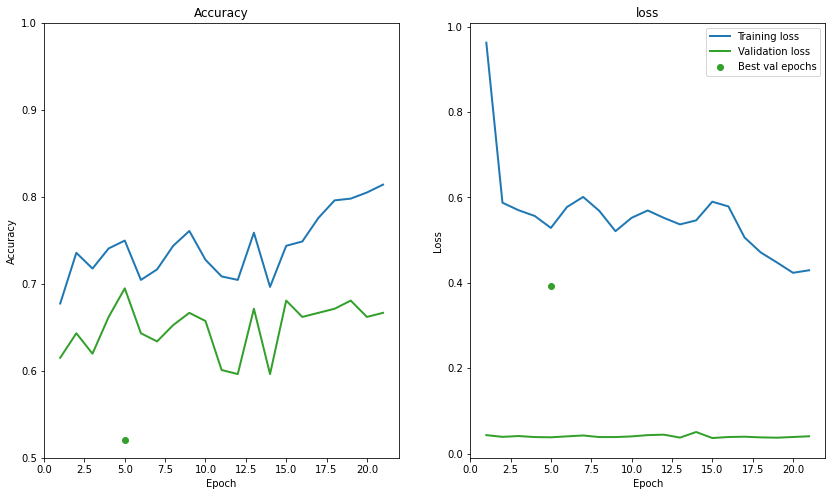

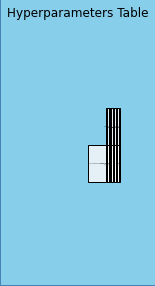

In [ ]:
 import pickle
 class optuna_study():
   def __init__(self,model_type,n_trials=5000,timeout_in_min=100,use_load_study=True):
     self.study_dir_path = '/content/drive/MyDrive/eye_pos_new/studies/'
     self.study_name = model_type +' optimization'
     if use_load_study:
       #study = optuna.load_study(study_name=self.study_name, storage=self.study_dir_path+self.study_name+'.pkl')
       with open(self.study_dir_path+self.study_name+'.pkl','rb') as file:
        study = pickle.load(file)
     else:
      study = optuna.create_study(
        study_name= self.study_name,
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=1),
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
     study.optimize(self.optuna_objective, n_trials=n_trials, timeout = timeout_in_min*60)
     plot_slice(study)
     print(f'best params{study.best_params}')
     print(f'best cv value{study.best_value}')
     self.optimzed_study = study
     self.evalute()
   def optuna_objective(self,trial):
      model_init_params = {'kernel_size_1': trial.suggest_int(name="kernel_size_1", low=4, high=10),
                           'kernel_size_2': trial.suggest_int(name="kernel_size_2", low=3, high=7),
                           'kernel_size_3': trial.suggest_int(name="kernel_size_3", low=1, high=5),
                'ch_multiply' : trial.suggest_float(name="ch_multiply", low=0.3, high=2),
                'dropout_p' : trial.suggest_float(name="dropout_p", low=0, high=0.5,step=0.1)}
      training_params = {'learning_rate' : trial.suggest_loguniform(name="learning_rate", low=1e-5, high=1e-2),
                'n_epochs' : trial.suggest_int(name="n_epochs", low=12, high=35)}
      return self.objective(model_init_params,training_params)
   def objective(self,model_init_params,training_params):
      net = SimpleConvolutionalNetwork(bmm_atten=False,**model_init_params)
      train_history, val_history,best_model_epoch = train(net, batch_size=batch_size,metrics=metrics, **training_params)
      return val_history[metrics][-1]
   def evalute(self):
    with open(self.study_dir_path+self.study_name+'.pkl','wb') as file:
      pickle.dump(self.optimzed_study,file)
    lr = self.optimzed_study.best_params['learning_rate']
    n_epochs = self.optimzed_study.best_params['n_epochs']
    ch_multiply = self.optimzed_study.best_params['ch_multiply']
    dropout_p = self.optimzed_study.best_params['dropout_p']
    net = SimpleConvolutionalNetwork(ch_multiply=1,dropout_p=0.1,bmm_atten=False)
    train_history, val_history,best_model_epoch = train(net, batch_size=batch_size, n_epochs=n_epochs, learning_rate=lr,metrics=metrics)
    plot_model_scores(train_history, val_history,test_loader,best_model_epoch,metrics=metrics)

metrics='acc'

batch_size = 12


weight_decay=0.001

#net_prob(net,x[6:8,:,:],1,1)
# forward one trial
# net(th.unsqueeze(th.tensor( x[0,:,:].swapaxes(0,1),dtype=th.float),dim=0))
optuna_study(model_type='CNN')
summerize_hyper_param()